In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib
from matplotlib.lines import Line2D
import calendar as cal
import plotly.figure_factory as ff
import matplotlib.dates as mdates

from modules import utils as ut
from modules import data_processing as dp
from modules import data_retrieval as dr 
from modules import statistics as st
from modules import seasonal_data_grouper as sdg
from eval import *
%matplotlib inline

## AVAILABLE STATIONS

In [2]:
#reading stations from json file
with open('stations/stations.json') as json_file:
    stations = json.load(json_file)

# Ordenar las estaciones por latitud
estaciones_ordenadas = sorted(stations.items(), key=lambda x: x[1]['latitude'])
#invertir el orden
estaciones_ordenadas = estaciones_ordenadas[::-1]


In [3]:
#estaciones_ordenadas

In [4]:
dict_of_names = {}
with open('modules/conv_stat_names.json') as file:
    dict_of_names = json.load(file)

#dict_of_names['stations']

In [5]:
stn = 'IPR'
obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True)

In [6]:
#sum all as OA 
df_mod = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))
df_mod['OA'] = df_mod.sum(axis=1)
df_mod = df_mod[['OA']]

In [7]:
df_mod[df_mod['OA'] > 20]

OA
2018-01-24  22.186687
2018-02-09  23.087527
2018-12-21  22.413714
2018-12-27  28.758038
2018-12-28  27.436485

In [32]:
#get months with highest OA
obs[obs['pm2p5oa']>20]

pm2p5oa
2018-01-14   23.415
2018-01-15   24.801
2018-01-16   20.664
2018-01-23   28.581
2018-01-24   25.137
2018-01-25   28.959
2018-01-29   26.502
2018-01-31   24.507
2018-02-11   40.257
2018-02-15   21.189
2018-02-16   25.074
2018-02-17   25.074
2018-03-07   21.000
2018-11-29   22.890
2018-12-01   25.704
2018-12-02   24.570
2018-12-03   20.685
2018-12-05   21.609
2018-12-06   21.189
2018-12-14   22.806
2018-12-15   24.801
2018-12-16   28.266
2018-12-17   36.960
2018-12-18   37.905
2018-12-19   27.384
2018-12-22   26.838
2018-12-23   25.956
2018-12-26   25.620
2018-12-27   27.867
2018-12-28   43.932
2018-12-29   32.277
2018-12-31   27.804

### MASS 

In [8]:

def plot_mass_contributions(stn):
    # Obtener datos de observaciones y modelo
    data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True)
    data_mod_sa = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))
    
    # Crear DataFrame para las contribuciones
    df = data_mod_sa.copy()
    df['oares'] = df['poares'] + df['soares']
    df['oatrf'] = df['poatrf'] + df['soatrf']
    df['oashp'] = df['poashp'] + df['soashp']
    df['oagfs'] = df['poagfs'] + df['soagfs']
    df['oaoth'] = df['poaoth'] + df['soaoth']
    
    # Eliminar columnas sobrantes
    columnas_a_eliminar = ['poares', 'soares', 'poatrf', 'soatrf', 'poashp', 'soashp', 'poagfs', 'soagfs', 'poaoth', 'soaoth']
    df = df.drop(columns=columnas_a_eliminar)
    
    # Ordenar las categorías
    orden_categorias = ['oashp', 'oagfs', 'oares', 'oatrf', 'oaoth']
    df = df[orden_categorias]
    
    # Definir colores y etiquetas personalizadas
    colores = {
        'oares': '#1f77b4',  # Azul claro
        'oagfs': '#ff7f0e',  # Naranja
        'oatrf': '#000000',  # Negro mate
        'oashp': '#2ca02c',
        'oaoth': '#8c564b'
    }
    
    etiquetas_personalizadas = {
        'oagfs': 'GFAS',
        'oares': 'RESI',
        'oatrf': 'TRAF',
        'oashp': 'SHIP',
        'oaoth': 'OTHR'
    }
    
    # Crear el gráfico de áreas
    ax = df.plot.area(stacked=True, alpha=0.5, color=[colores.get(col, 'gray') for col in df.columns], figsize=(12, 6))
    
    # Añadir puntos de observación
    color_obs = 'red'
    ax.plot(data_obs, color=color_obs, marker='o', linestyle='--', ms=3, lw=0.8, alpha=0.6)
    
    # Añadir títulos y etiquetas
    plt.title(stn, fontsize=16, fontweight='bold')
    plt.xlabel('months', fontsize=14)
    plt.ylabel(r'OA ($\mu g/m^3$)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Añadir rejilla
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Crear una lista de etiquetas con colores personalizados
    etiquetas_con_colores = [
        (etiquetas_personalizadas.get(col, col), colores.get(col, None))
        for col in df.columns
    ]
    
    # Añadir leyenda con etiquetas personalizadas y colores
    handles = [plt.Line2D([0], [0], color=color, lw=4) for etiqueta, color in etiquetas_con_colores]
    labels = [etiqueta for etiqueta, _ in etiquetas_con_colores]
    
    # Añadir leyenda de observaciones
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_obs, markersize=10))
    labels.append('OBS')
    
    plt.legend(handles=handles, labels=labels, loc='upper center', fontsize='small', title='Contribution', title_fontsize='13', ncol=6)

    #set limite del eje y como el maximo entre mod y obs 
    max_df = df.sum(axis=1).values.max()
    max_data_obs = data_obs.max().values[0]

    # Obtener el máximo entre max_df y max_data_obs
    max_val = max(max_df, max_data_obs)
    plt.ylim(-0.1, max_val+0.1)

    #crear carpeta para guardar figuras
    os.makedirs("figures_paper", exist_ok=True)
    #guardar figura
    plt.savefig("figures_paper/{}_mass_contributions.png".format(stn), dpi=300, bbox_inches='tight')
    # Mostrar el gráfico
    plt.show()

# Llama a la función con el nombre de la estación
#plot_mass_contributions('MSY')

In [6]:
#ut.plot_line_mass('RIG')

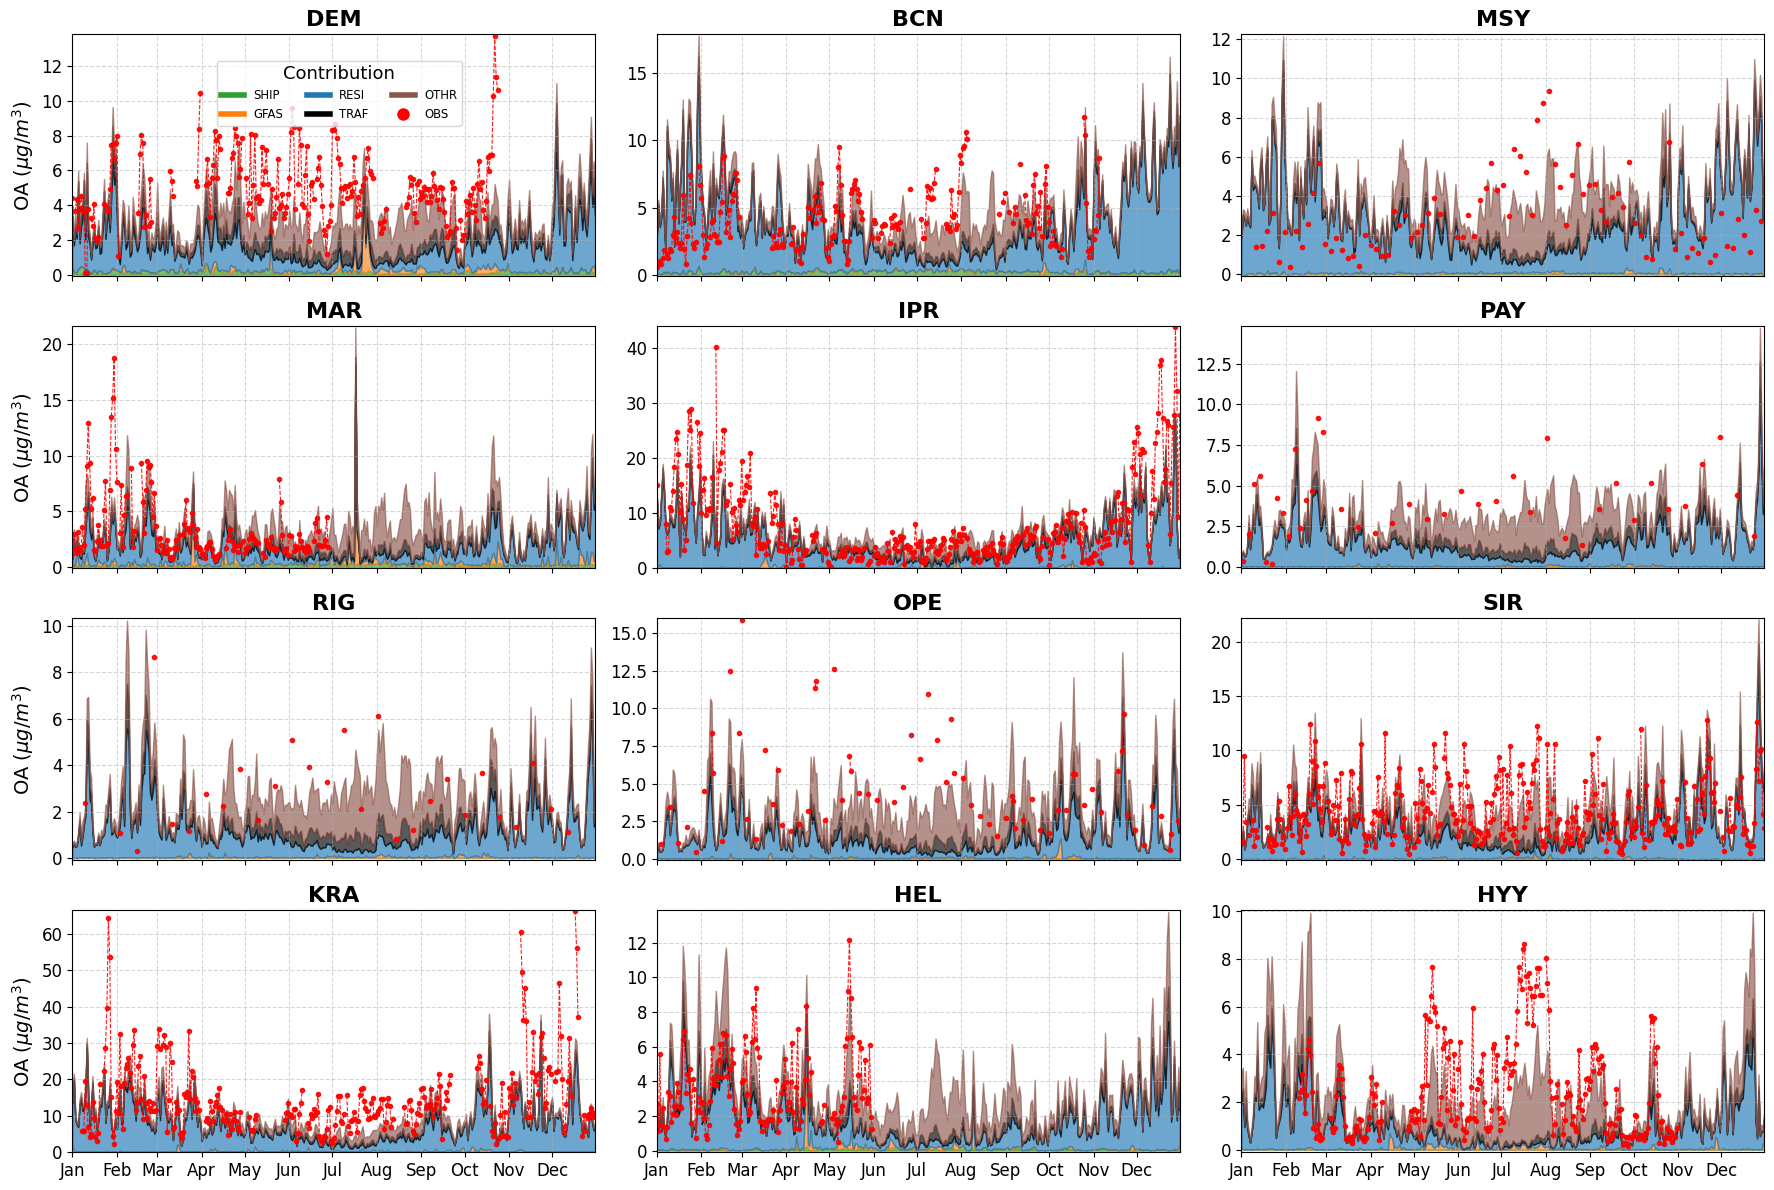

In [34]:

def plot_mass_contributions_panel(stations, m_o_y=True):
    fig, axs = plt.subplots(4, 3, figsize=(18, 12), sharex=True, sharey=False)
    axs = axs.flatten()  # Convertir la matriz de ejes en una lista para facilitar la iteración

    # Definir colores y etiquetas personalizadas fuera del bucle
    colores = {
        'oares': '#1f77b4',  # Azul claro
        'oagfs': '#ff7f0e',  # Naranja
        'oatrf': '#000000',  # Negro mate
        'oashp': '#2ca02c',  # Verde
        'oaoth': '#8c564b'   # Marrón
    }
    
    etiquetas_personalizadas = {
        'oagfs': 'GFAS',
        'oares': 'RESI',
        'oatrf': 'TRAF',
        'oashp': 'SHIP',
        'oaoth': 'OTHR'
    }

    for idx, stn in enumerate(stations):
        ax = axs[idx]
        
        # Obtener datos de observaciones y modelo
        
    
        if m_o_y:
            data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True)
            data_mod_sa = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))
            #Resample to monthly mean
            data_obs = data_obs.resample('M').mean()
            data_mod_sa = data_mod_sa.resample('M').mean()

            # Asegurar que los índices estén en formato datetime
            #data_obs.index = pd.to_datetime(data_obs.index)
            #data_mod_sa.index = pd.to_datetime(data_mod_sa.index)
            #data_obs, data_mod_sa = data_obs.align(data_mod_sa, join='inner', axis=0)

        else:
            data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True)
            data_mod_sa = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))

        # Crear DataFrame para las contribuciones
        df = data_mod_sa.copy()
        df['oares'] = df['poares'] + df['soares']
        df['oatrf'] = df['poatrf'] + df['soatrf']
        df['oashp'] = df['poashp'] + df['soashp']
        df['oagfs'] = df['poagfs'] + df['soagfs']
        df['oaoth'] = df['poaoth'] + df['soaoth']
        
        # Eliminar columnas sobrantes
        columnas_a_eliminar = ['poares', 'soares', 'poatrf', 'soatrf', 'poashp', 'soashp', 'poagfs', 'soagfs', 'poaoth', 'soaoth']
        df = df.drop(columns=columnas_a_eliminar)
        
        # Ordenar las categorías
        orden_categorias = ['oashp', 'oagfs', 'oares', 'oatrf', 'oaoth']
        df = df[orden_categorias]
        
        # Crear el gráfico de áreas en el eje correspondiente
        #df.plot.area(ax=ax, stacked=True, alpha=0.25, color=[colores.get(col, 'gray') for col in df.columns], legend=False)
        df['acumulado'] = 0

        # Iterar a través de cada categoría que deseas graficar
        for col in df.columns[:-1]:  # Excluye la columna 'acumulado' que agregaste
            # Sumar la columna actual a la columna 'acumulado'
            df['acumulado'] += df[col]

            # Graficar la columna 'acumulado'
            ax.fill_between(df.index, df['acumulado'], df['acumulado'] - df[col], 
                            color=colores.get(col, 'gray'), alpha=0.65)

        # Opcional: Eliminar la columna 'acumulado' si ya no la necesitas
        df = df.drop(columns=['acumulado'])
        # Añadir puntos de observación
        color_obs = 'red'
        ax.plot(data_obs, color=color_obs, marker='o', linestyle='--', ms=3 if m_o_y==False else 6, lw=0.8, alpha=0.9)
        
        # Añadir títulos y etiquetas
        ax.set_title(stn, fontsize=16, fontweight='bold')
        #ax.set_xlabel('months', fontsize=14)
        #ax.set_ylabel(r'OA ($\mu g/m^3$)', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        if idx in [0, 3, 6, 9]:
            ax.set_title(stn, fontsize=16, fontweight='bold')
            ax.set_ylabel(r'OA ($\mu g/m^3$)', fontsize=14)
        # Añadir rejilla
        ax.grid(True, linestyle='--', alpha=0.5)
        

        max_df = df.sum(axis=1).values.max()
        max_data_obs = data_obs.max().values[0]
        
        max_val = max(max_df, max_data_obs)
        ax.set_ylim(-0.1, max_val + 0.1)

        # Configurar el formato de las etiquetas del eje x para que muestren las iniciales de los meses
        ax.xaxis.set_major_locator(mdates.MonthLocator())  # Colocar un tick por cada mes
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # %b da el nombre abreviado del mes en inglés
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Coloca un tick cada 1 mes
        ax.set_xlim(df.index.min(), df.index.max())

    # Rotar las etiquetas para que se muestren mejor
    #for label in ax.get_xticklabels():
    #    label.set_rotation(45)
    #    label.set_horizontalalignment('right')

    # Ajustar espaciado entre subgráficos
    plt.tight_layout()

    # Crear una sola leyenda para todos los subgráficos
    etiquetas_con_colores = [
        (etiquetas_personalizadas.get(col, col), colores.get(col, None))
        for col in df.columns
    ]
    
    handles = [plt.Line2D([0], [0], color=color, lw=4) for etiqueta, color in etiquetas_con_colores]
    labels = [etiqueta for etiqueta, _ in etiquetas_con_colores]
    
    color_obs = 'red'  # Definir color de observaciones
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_obs, markersize=10))
    labels.append('OBS')

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.20, 0.95), fontsize='small', title='Contribution', title_fontsize='13', ncol=3)

    # Crear carpeta para guardar figuras
    os.makedirs("figures_paper", exist_ok=True)
    # Guardar figura
    plt.savefig(f"figures_paper/mass_contributions_panel_{'m' if m_o_y==True else 'y'}.png", dpi=300, bbox_inches='tight')
    # Mostrar el gráfico
    plt.show()


# Llama a la función con la lista de nombres de las estaciones
stations = dict_of_names['stations'].values()
plot_mass_contributions_panel(stations, m_o_y=False)

In [36]:
def get_mod(stn, soa=False):
    df = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))
    if soa:
        df['soa'] = df['soares'] + df['soatrf'] + df['soashp'] + df['soagfs'] + df['soaoth'] 
        df = df.drop(columns=['soares', 'soatrf', 'soashp', 'soagfs', 'soaoth'])

        return df
    else:
        df['oares'] = df['poares'] + df['soares']
        df['oatrf'] = df['poatrf'] + df['soatrf']
        df['oashp'] = df['poashp'] + df['soashp']
        df['oagfs'] = df['poagfs'] + df['soagfs']
        df['oaoth'] = df['poaoth'] + df['soaoth']

        columnas_a_eliminar = ['poares', 'soares', 'poatrf', 'soatrf', 'poashp', 'soashp', 'poagfs', 'soagfs', 'poaoth', 'soaoth']
        df = df.drop(columns=columnas_a_eliminar)
        return df

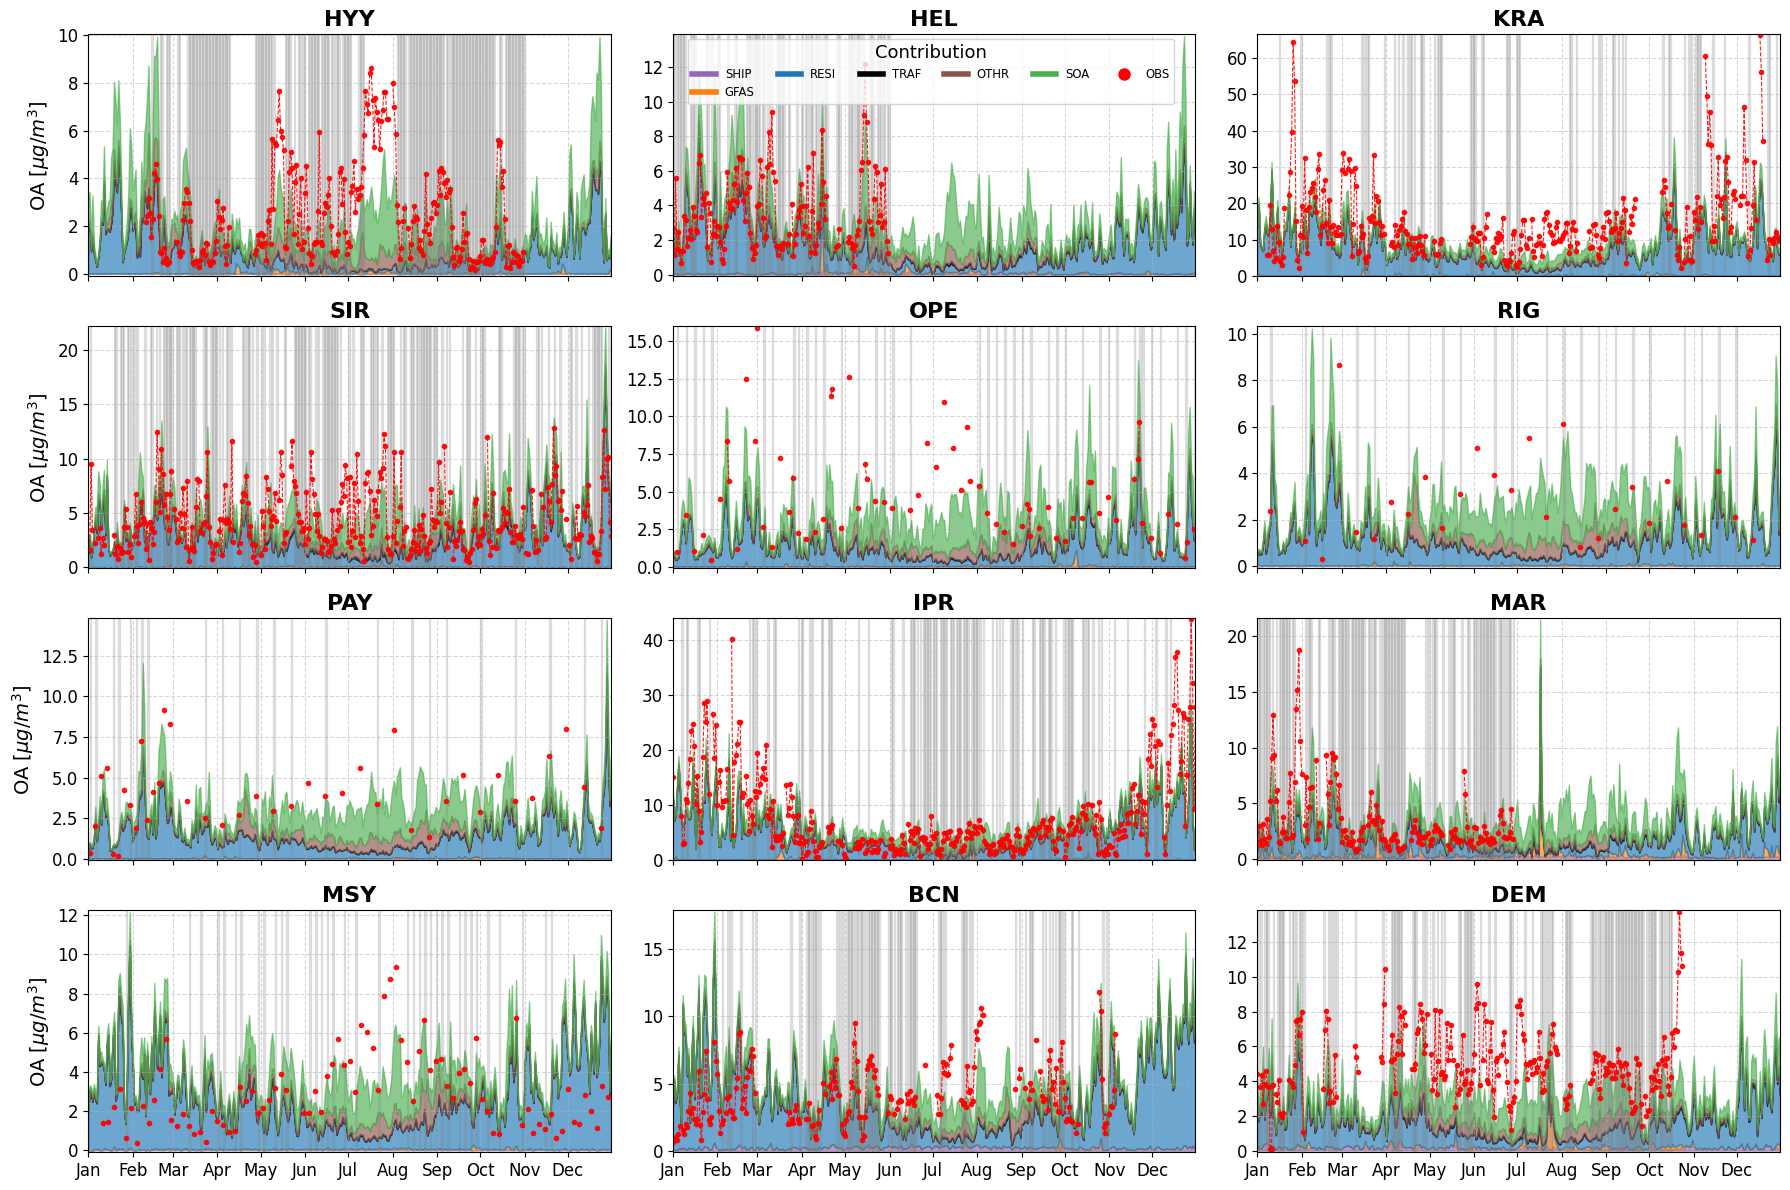

In [38]:

def plot_mass_contributions_panel_wsoa(stations, m_o_y=True):
    fig, axs = plt.subplots(4, 3, figsize=(18, 12), sharex=True, sharey=False)
    axs = axs.flatten()  # Convertir la matriz de ejes en una lista para facilitar la iteración

    # Definir colores y etiquetas personalizadas fuera del bucle
    colores = {
        'oares': '#1f77b4',  # Azul claro
        'oagfs': '#ff7f0e',  # Naranja
        'oatrf': '#000000',  # Negro mate
        'oashp': '#9467bd',  # morado
        'oaoth': '#8c564b',   # Marrón
        'soa': '#4CAF50',
        'poares': '#1f77b4',  # Azul claro
        'poagfs': '#ff7f0e',  # Naranja
        'poatrf': '#000000',  # Negro mate
        'poashp': '#9467bd',  # morado
        'poaoth': '#8c564b',   # Marrón
    }
    
    etiquetas_personalizadas = {
        'oagfs': 'GFAS',
        'oares': 'RESI',
        'oatrf': 'TRAF',
        'oashp': 'SHIP',
        'oaoth': 'OTHR',
        'soa': 'SOA',
        'poagfs': 'GFAS',
        'poares': 'RESI',
        'poatrf': 'TRAF',
        'poashp': 'SHIP',
        'poaoth': 'OTHR',
    }

    for idx, stn in enumerate(stations):
        ax = axs[idx]
        # Obtener datos de observaciones y modelo
        if m_o_y:
            data_obs_i = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True)
            data_mod_sa_i = get_mod(stn, soa=True)

            #collocation data
            data_obs_, data_mod_sa_ = st.preproc_data_collocation(data_obs_i, data_mod_sa_i, filled=True)
            #Resample to monthly mean
            data_obs = data_obs_.resample('MS').mean()
            df = data_mod_sa_.resample('MS').mean()
            #data_obs, df = data_obs.align(df, join='outer')
            #df.to_csv(f'data_mod_sa_{stn}.csv')
            #data_obs.to_csv(f'data_obs_{stn}.csv')

        else:
            data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True)
            df = get_mod(stn, soa=True)

        # Ordenar las categorías
        orden_categorias = ['poashp', 'poagfs', 'poares', 'poatrf', 'poaoth', 'soa']

        df = df[orden_categorias]
        # Crear el gráfico de áreas en el eje correspondiente
        #df.plot.area(ax=ax, stacked=True, alpha=0.25, color=[colores.get(col, 'gray') for col in df.columns], legend=False)
        df['acumulado'] = 0

        # Iterar a través de cada categoría que deseas graficar
        for col in df.columns[:-1]:  # Excluye la columna 'acumulado' que agregaste
            # Sumar la columna actual a la columna 'acumulado'
            df['acumulado'] += df[col]
           
            # Graficar la columna 'acumulado'
            ax.fill_between(df.index, df['acumulado'], df['acumulado'] - df[col], 
                            color=colores.get(col, 'gray'), alpha=0.65)

        # Eliminar la columna 'acumulado' 
        df = df.drop(columns=['acumulado'])
        # Añadir puntos de observación
        color_obs = 'red'
        ax.plot(data_obs, color=color_obs, marker='o', linestyle='--', ms=3 if m_o_y==False else 6, lw=0.8, alpha=0.9)
        
        # Añadir títulos y etiquetas
        ax.set_title(stn, fontsize=16, fontweight='bold')
        #ax.set_xlabel('months', fontsize=14)
        #ax.set_ylabel(r'OA ($\mu g/m^3$)', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        if idx in [0, 3, 6, 9]:
            ax.set_title(stn, fontsize=16, fontweight='bold')
            ax.set_ylabel(r'OA [$\mu g/m^3$]', fontsize=14)
        # Añadir rejilla
        ax.grid(True, linestyle='--', alpha=0.5)
        

        max_df = df.sum(axis=1).values.max()
        max_data_obs = data_obs.max().values[0]
        
        max_val = max(max_df, max_data_obs)
        ax.set_ylim(-0.1, max_val + 0.1)

        #adding a shade of best days
        dates_best = ut.calculate_absorption_cases(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                       SA=False, mode='by_station', points='best', model='monarch_best', case='strongly')
        dates_best[dates_best <= 0.] = np.nan 
        dates_best = dates_best.dropna()
        dates_best = dates_best.index

        for date in dates_best:
            ax.axvspan(date, date + pd.DateOffset(days=1), color='gray', alpha=0.2)

    # Configurar el formato de las etiquetas del eje x para que muestren las iniciales de los meses
    #ax.xaxis.set_major_locator(mdates.MonthLocator())  # Colocar un tick por cada mes
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # %b da el nombre abreviado del mes en inglés
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Coloca un tick cada 1 mes
    #ax.set_xlim(df.index.min(), df.index.max())
    #set ticks as first letter of the month
        if m_o_y:
            if not isinstance(df.index, pd.DatetimeIndex):
                df.index = pd.to_datetime(df.index)

            # Establecer los xticks y xticklabels
            ax.set_xticks(df.index)
            ax.set_xticklabels([cal.month_abbr[i.month][0] for i in df.index])
        else:
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            ax.set_xlim(df.index.min(), df.index.max())
    
    # Rotar las etiquetas para que se muestren mejor
    for label in ax.get_xticklabels():
        label.set_rotation(0)  # Rotar las etiquetas a 0 grados (horizontal)
        label.set_horizontalalignment('center')

    # Ajustar espaciado entre subgráficos
    plt.tight_layout()

    # Crear una sola leyenda para todos los subgráficos
    etiquetas_con_colores = [
        (etiquetas_personalizadas.get(col, col), colores.get(col, None))
        for col in df.columns
    ]
    
    handles = [plt.Line2D([0], [0], color=color, lw=4) for etiqueta, color in etiquetas_con_colores]
    labels = [etiqueta for etiqueta, _ in etiquetas_con_colores]
    
    color_obs = 'red'  # Definir color de observaciones
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_obs, markersize=10))
    labels.append('OBS')

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.20, 0.95) if m_o_y else (0.52, 0.968),\
               fontsize='small', title='Contribution', title_fontsize='13', ncol=3 if m_o_y else 6)
    #bbox_to_anchor=(0.20, 0.95)
    # Crear carpeta para guardar figuras
    os.makedirs("figures_paper", exist_ok=True)
    # Guardar figura
    plt.savefig(f"figures_paper/mass_contributions_panel_wsoa_dayli_collocated{'m' if m_o_y==True else 'y'}.png", dpi=300, bbox_inches='tight')
    # Mostrar el gráfico
    plt.show()


# Llama a la función con la lista de nombres de las estaciones
stations = list(dict_of_names['stations'].values())
#invertir el orden
stations = stations[::-1]
plot_mass_contributions_panel_wsoa(stations, m_o_y=False)

## Donut mass contribution

0.2917920076288283
5.89950866997242
258.73425006866455
30.481663942337036
64.59275364875793


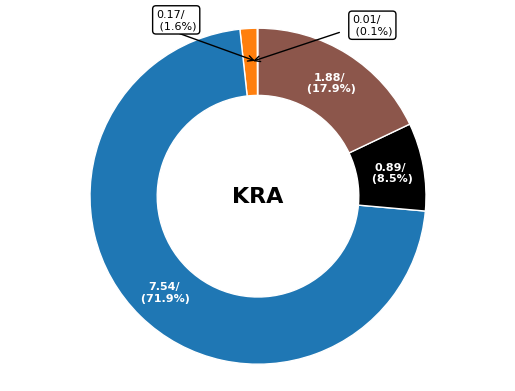

In [10]:
def plot_donut_contributions(stn):
    # Obtener los datos para la estación deseada
    data_mod_sa = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))
    
    # Crear DataFrame para las contribuciones
    df = data_mod_sa.copy()
    df['oares'] = df['poares'] + df['soares']
    df['oatrf'] = df['poatrf'] + df['soatrf']
    df['oashp'] = df['poashp'] + df['soashp']
    df['oagfs'] = df['poagfs'] + df['soagfs']
    df['oaoth'] = df['poaoth'] + df['soaoth']
    
    # Eliminar columnas sobrantes
    columnas_a_eliminar = ['poares', 'soares', 'poatrf', 'soatrf', 'poashp', 'soashp', 'poagfs', 'soagfs', 'poaoth', 'soaoth']
    df = df.drop(columns=columnas_a_eliminar)
    
    # Ordenar las categorías
    orden_categorias = ['oashp', 'oagfs', 'oares', 'oatrf', 'oaoth']
    df = df[orden_categorias]
    
    # Calcular la contribución media anual
    contribucion_media_anual = df.mean()
    
    # Obtener nombres de categorías y valores
    categorias = contribucion_media_anual.index
    valores = contribucion_media_anual.values
    
    # Define una paleta de colores para las categorías
    colores = {
        'oares': '#1f77b4',  # Azul claro
        'oagfs': '#ff7f0e',  # Naranja
        'oatrf': '#000000',  # Negro mate
        'oashp': '#2ca02c',
        'oaoth': '#8c564b'
    }
    
    # Obtener colores correspondientes a las categorías
    colores_categorias = [colores.get(cat, 'gray') for cat in categorias]
    
    # Etiquetas personalizadas para las categorías
    etiquetas_personalizadas = {
        'oagfs': 'GFAS',
        'oares': 'RES',
        'oatrf': 'TRF',
        'oashp': 'SHP',
        'oaoth': 'OTH'
    }
    
    # Obtener etiquetas personalizadas correspondientes a las categorías
    etiquetas_categorias = [etiquetas_personalizadas.get(cat, cat) for cat in categorias]
    
    # Crear un gráfico de donut
    fig, ax = plt.subplots()
    wedges, _ = ax.pie(valores, labels=None, autopct=None, startangle=90, wedgeprops=dict(width=0.4, edgecolor='w'),
                       colors=colores_categorias, textprops={'fontsize': 10, 'color': 'black', 'fontweight': 'bold'})

    # Agregar el nombre de la estación en el centro
    ax.text(0, 0, stn, ha='center', va='center', fontsize=16, fontweight='bold')
    fontsize = 8
    # Añadir los valores absolutos y los porcentajes al interior del sector del donut
    for wedge, etiqueta, valor in zip(wedges, etiquetas_categorias, valores):
        angle = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
        x = 0.8 * np.cos(np.deg2rad(angle))
        y = 0.8 * np.sin(np.deg2rad(angle))
        #ax.text(x, y, f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', 
        #        ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        print(wedge.theta2 - wedge.theta1)
        if (wedge.theta2 - wedge.theta1) == 2.407016381621361:
            #this is for BCN
            ax.annotate('', xy=(x, y), xytext=(-.5, .98), arrowprops=dict(arrowstyle='->'))
            ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(-68, 25),
                                textcoords='offset points', fontsize=fontsize,
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
                
        elif (wedge.theta2 - wedge.theta1) < 4 and (wedge.theta2 - wedge.theta1) > 3:
            #for MSY
            ax.annotate('', xy=(x, y), xytext=(-.5, .98), arrowprops=dict(arrowstyle='->'))
            ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(-68, 24),
                                textcoords='offset points', fontsize=fontsize,
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        elif (wedge.theta2 - wedge.theta1) > 2 and (wedge.theta2 - wedge.theta1) < 3:
            if stn in ['MSY', 'IPR', 'HYY']:
                ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
                ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(60, 24),
                                    textcoords='offset points', fontsize=fontsize,
                                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
            elif stn in ['PAY']:
                ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
                ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(-68, 24),
                                    textcoords='offset points', fontsize=fontsize,
                                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
            elif stn in ['SIR']:
                if (wedge.theta2 - wedge.theta1) == 2.3551327362656593:
                    ax.annotate('', xy=(x, y), xytext=(-.5, .98), arrowprops=dict(arrowstyle='->'))
                    ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(-68, 24),
                                        textcoords='offset points', fontsize=fontsize,
                                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
                elif (wedge.theta2 - wedge.theta1) == 2.2840231843292713:
                    ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
                    ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(60, 20),
                                        textcoords='offset points', fontsize=fontsize,
                                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

        elif (wedge.theta2 - wedge.theta1) > 5 and (wedge.theta2 - wedge.theta1) < 7:
            
            if stn in ['KRA']:
                if (wedge.theta2 - wedge.theta1) == 5.89950866997242:
                    #for KRA
                    ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
                    ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(-68, 24),
                                        textcoords='offset points', fontsize=fontsize,
                                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
            else:
            #for HEL
                ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
                ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(60, 24),
                                    textcoords='offset points', fontsize=fontsize,
                                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        elif (wedge.theta2 - wedge.theta1) == 0.2917920076288283:
            #for KRA
            ax.annotate('', xy=(x, y), xytext=(-.5, .98), arrowprops=dict(arrowstyle='->'))
            ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(68, 20),
                                textcoords='offset points', fontsize=fontsize,
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

            
        elif (wedge.theta2 - wedge.theta1) == 1.004049489274621:
            #for PAY
            ax.annotate('', xy=(x, y), xytext=(-.5, .98), arrowprops=dict(arrowstyle='->'))
            ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(60, 24),
                                textcoords='offset points', fontsize=fontsize,
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        elif (wedge.theta2 - wedge.theta1) == 1.9844325073063374:
            #for OPE
            ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
            ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(60, 24),
                                textcoords='offset points', fontsize=fontsize,
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        elif (wedge.theta2 - wedge.theta1) == 0.9832404926419258:
            #for RIG
            ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
            ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(60, 24),
                                textcoords='offset points', fontsize=fontsize,
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
            
        else:
            # Add the text label to the pie chart changed angle 0
            ax.text(x, y, f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', fontsize=fontsize, color='white',
                    fontweight='bold', ha='center', va='center', rotation=0)


    # Aspecto de donut (círculo en el centro)
    circle = plt.Circle((0, 0), 0.2, color='white')
    ax.add_artist(circle)

    # Título
    #ax.set_title("Contribución Media Anual")

    # Mostrar el gráfico de donut
    plt.axis('equal')  # Para asegurar que el gráfico sea circular
    plt.show()
# Llama a la función con el nombre de la estación
plot_donut_contributions('KRA')


In [11]:
#sa data
path = '/home/hnavarro/Desktop/PHD_BSC/GIT/absorption/NInventory/obs/mass_concentration/source_app/'

In [12]:
def get_apportion(stn):
    '''
    avaliable stations: DEM, BCN, HEL, HYY, KRA, and MAR
    '''
    station = dict_of_names['acr_first'][stn]
    df = pd.read_csv(path+f'sa_oa_2018_{station}.csv', index_col=0, parse_dates=True)
    #df = df.resample('M').mean()
    return df

In [13]:
get_apportion('BCN').columns

Index(['OA cooking', 'OA traffic', 'OA biomass burning', 'SOA'], dtype='object')

In [9]:
# Configuraciones de colores y etiquetas
etiquetas_mod = {
    'oagfs': 'GFAS',
    'oares': 'RES',
    'oatrf': 'TRF',
    'oashp': 'SHP',
    'oaoth': 'OTH',
    'soa': 'SOA',
    'poares': 'RES',
    'poatrf': 'TRF',
    'poashp': 'SHP',
    'poagfs': 'GFAS',
    'poaoth': 'OTH',
}

colores_mod = {
    'RES': '#1f77b4',  # Azul claro
    'GFAS': '#ff7f0e',  # Naranja
    'TRF': '#000000',  # Negro mate
    'SHP': '#9467bd',  # Morado
    'OTH': '#8c564b',  # Marrón
    'SOA': '#4CAF50'   # Verde mate
}

colores_obs = {
    'COA': '#0088ce',  # Azul
    'TRF': '#000000',  # same as in model
    'BBOA': '#ff7f0e',  # same as in gfas
    'SOA': '#4CAF50',   # Morado
    'COF': 'brown',
    'IND': 'red'
}

etiquetas_obs = {
    'BCN': {
        'OA cooking': 'COA',
        'OA traffic': 'TRF',
        'OA biomass burning': 'BBOA',
        'SOA': 'SOA',
    },
    'HYY': {
        'SOA': 'SOA'
    },
    'DEM': {
        'OA cooking': 'COA',
        'OA traffic': 'TRF',
        'OA biomass burning': 'BBOA',
        'SOA': 'SOA',

    },
    'HEL': {
        'Coffee': 'COF',
        'OA traffic': 'TRF',
        'SOA': 'SOA'
    },
    'KRA':{
        'OA cooking': 'COA',
        'OA traffic': 'TRF',
        'OA biomass burning': 'BBOA',
        'SOA': 'SOA',
    },
    'MAR': {
        'OA cooking': 'COA',
        'OA traffic': 'TRF',
        'OA biomass burning': 'BBOA',
        'SOA': 'SOA',
        'Sh-IndOA': 'IND',
    }

}

In [10]:
def get_cont_perc_abs_obs(stn):
    df_obs = get_apportion(stn)
    # Calcular la suma total anual de cada columna
    cont_total_anual_obs = df_obs.resample('YE').sum()

    # Calcular la suma total anual de todas las columnas
    cont_total_anual_obs_tot = df_obs.resample('YE').sum().sum(axis=1)

    # Calcular la contribución porcentual de cada columna como porcentaje del total anual
    cont_total_anual_obs_perc = np.round((cont_total_anual_obs.div(cont_total_anual_obs_tot, axis=0)) * 100, 1)
    #obtenemos tambien los valores absolutos
    cont_media_anual_obs = np.round(df_obs.resample('YE').mean(), 2)

    return cont_total_anual_obs_perc, cont_media_anual_obs

In [16]:
get_cont_perc_abs_obs('MAR')

(            OA traffic  OA cooking  Sh-IndOA  OA biomass burning   SOA
 date                                                                  
 2018-12-31        10.9        12.5       3.5                16.8  56.3,
             OA traffic  OA cooking  Sh-IndOA  OA biomass burning   SOA
 date                                                                  
 2018-12-31        0.55        0.63      0.18                0.84  2.82)

In [17]:
obs_perc, obs_abs = get_cont_perc_abs_obs('BCN')

In [18]:
def get_cont_perc_abs_mod(stn, soa=False):
    df = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))
    # Reading obs to do collocation
    obs = get_apportion(stn)

    # Doing collocation
    _ , df = st.preproc_data_collocation(obs, df, filled=False)
    if soa:
        df['soa'] = df['soares'] + df['soatrf'] + df['soashp'] + df['soagfs'] + df['soaoth'] 
        df = df.drop(columns=['soares', 'soatrf', 'soashp', 'soagfs', 'soaoth'])
        df_mean_cont = np.round(df.resample('YE').mean(), 2)
        df_sum_cont = df.resample('YE').sum()
        df_cont_tot = df_sum_cont.sum(axis=1)
        #calculando contribucion porcentual
        df_cont_perc = np.round((df_sum_cont.div(df_cont_tot, axis=0)) * 100, 2)
        return df_cont_perc, df_mean_cont
    else:
        df['oares'] = df['poares'] + df['soares']
        df['oatrf'] = df['poatrf'] + df['soatrf']
        df['oashp'] = df['poashp'] + df['soashp']
        df['oagfs'] = df['poagfs'] + df['soagfs']
        df['oaoth'] = df['poaoth'] + df['soaoth']

        columnas_a_eliminar = ['poares', 'soares', 'poatrf', 'soatrf', 'poashp', 'soashp', 'poagfs', 'soagfs', 'poaoth', 'soaoth']
        df = df.drop(columns=columnas_a_eliminar)
        df_mean_cont = np.round(df.resample('YE').mean(), 2)
        df_sum_cont = df.resample('YE').sum()
        df_cont_tot = df_sum_cont.sum(axis=1)
        #calculando contribucion porcentual
        df_cont_perc = np.round((df_sum_cont.div(df_cont_tot, axis=0)) * 100, 2)
        return df_cont_perc, df_mean_cont
    

In [19]:
get_cont_perc_abs_mod('BCN', soa=False)

(            oares  oatrf  oashp  oagfs  oaoth
 2018-12-31  83.97    4.4   2.34   0.33   8.96,
             oares  oatrf  oashp  oagfs  oaoth
 2018-12-31   6.09   0.32   0.17   0.02   0.65)

In [20]:
get_cont_perc_abs_mod('BCN', soa=True)

(            poares  poatrf  poashp  poagfs  poaoth   soa
 2018-12-31   83.97    1.41     2.2    0.22    2.99  9.21,
             poares  poatrf  poashp  poagfs  poaoth   soa
 2018-12-31    6.09     0.1    0.16    0.02    0.22  0.67)

In [21]:
get_cont_perc_abs_mod('BCN', soa=True)

(            poares  poatrf  poashp  poagfs  poaoth   soa
 2018-12-31   83.97    1.41     2.2    0.22    2.99  9.21,
             poares  poatrf  poashp  poagfs  poaoth   soa
 2018-12-31    6.09     0.1    0.16    0.02    0.22  0.67)

In [22]:
#data
stn = 'BCN'
model_perc, model_abs = get_cont_perc_abs_mod(stn, soa=True)
obs_perc, obs_abs = get_cont_perc_abs_obs(stn)

In [23]:
#categories
categorias_mod = model_perc.columns
etiquetas_mod_pie = [etiquetas_mod[cat] for cat in categorias_mod]
colores_mod_pie = [colores_mod[etiqueta] for etiqueta in etiquetas_mod_pie]

In [24]:
#categories obs
categorias_obs = obs_perc.columns
colores_obs_pie = [colores_obs[etiquetas_obs[stn][cat]] for cat in categorias_obs]
etiquetas_obs_pie = [etiquetas_obs[stn][cat] for cat in categorias_obs]

In [25]:
def func(pct, allvals, i):
    absolute = allvals[i]  # Usar directamente el valor absoluto correspondiente
    return f"{pct:.2f}%\n({absolute:.2f})"  # Mostrar con dos decimales

NameError: name 'connectionstyle' is not defined

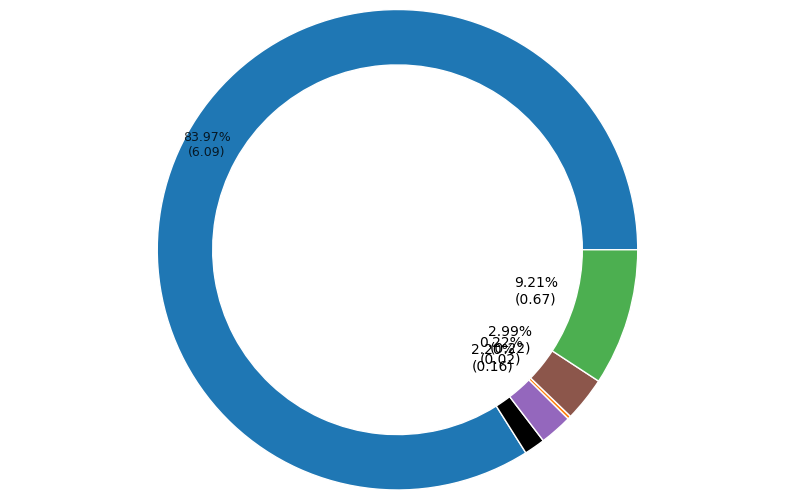

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('equal')
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
valores_model = [f'{pct:.2f}%\n({abs_val:.2f})' for pct, abs_val in zip(model_perc.values[0], model_abs.values[0])]

val_mod_iter = iter(valores_model)
outside_pie, texts_out, autotexts_out = ax.pie(model_perc.values[0], autopct=lambda pct: next(val_mod_iter), radius=1.3, colors=colores_mod_pie, #labels=etiquetas_mod_pie,\
                                 labeldistance=1.13, wedgeprops=dict(width=0.3, edgecolor='white'))
plt.setp(outside_pie, width=0.3, edgecolor='white')

if stn in ['BCN', 'DEM', 'MAR']:
    for i, (pie_wedge, autotext) in enumerate(zip(outside_pie, autotexts_out)):
        ang = (pie_wedge.theta2 - pie_wedge.theta1) / 2 + pie_wedge.theta1
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        face_color = pie_wedge.get_facecolor()
        
        # Para sectores pequeños, ajustar la posición de las etiquetas
        if pie_wedge.theta2 - pie_wedge.theta1  <9 and stn in ['DEM', 'MAR']:  # para DEM < 9 para el resto <10
            autotext.set_text('')  # Ocultar el texto automático
            # Determinar la posición de la anotación basada en el ángulo
            if y < 0:  # Si el sector está en la parte inferior
                xytext = (1.4 * x, 1.5 * y)  # Mover la etiqueta más hacia abajo
                connectionstyle = f"angle,angleA={ang-90},angleB=90,rad=0.2"  # Ajustar la conexión para que la flecha apunte hacia arriba
            else:
                xytext = (.8 * x, 1.1 * y)  # Mover la etiqueta más hacia arriba
                connectionstyle = f"angle,angleA={ang+90},angleB=-90,rad=0.2"  # Ajustar la conexión para que la flecha apunte hacia abajo
            
            arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle, color="black")
            ax.annotate(valores_model[i], xy=(x+0.4, y-0.07), xytext=xytext,
                        horizontalalignment="center", 
                        arrowprops=arrowprops,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.72))

        # Para el primer caso
        elif pie_wedge.theta2 - pie_wedge.theta1 == 5.0759997591376305:
            autotext.set_text('')  # Ocultar el texto automático
            arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle, color="black")
            if y < 0:
                xytext = (2.0 * x, 1.5 * y)  # Ajustar posición de la etiqueta
                connectionstyle = f"arc3,rad={0.5 if y > 0 else -0.5}"  # Ajustar curvatura de la flecha
                ax.annotate(valores_model[i], xy=(x+0.01, y-.099), xytext=xytext,
                            horizontalalignment="center", 
                            arrowprops=arrowprops,
                            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.72))

        # Para el segundo caso
        elif pie_wedge.theta2 - pie_wedge.theta1 == 0.7919999957084656:
            autotext.set_text('')  # Ocultar el texto automático
            arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle, color="black")
            if y< 0: 
                xytext = (2.0 * x, 1.1 * y)  # Ajustar posición de la etiqueta
                connectionstyle = f"arc3,rad={-0.1 if y > 0 else -0.1}"  # Ajustar curvatura de la flecha
                ax.annotate(valores_model[i], xy=(x+0.2, y-.2), xytext=xytext,
                            horizontalalignment="center", 
                            arrowprops=arrowprops,
                            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.72))

        else:
            if (face_color[0] == 0 and face_color[1] == 0 and face_color[2] == 0):
                autotext.set_color('white')
                autotext.set_position((x * 1.18, y * 1.18))
                autotext.set_alpha(0.95)
                autotext.set_fontsize(9)  # Ajusta esto según sea necesario
                autotext.set_horizontalalignment('center')
                autotext.set_verticalalignment('center')
            else:
                # Para sectores más grandes, centrar la etiqueta
                autotext.set_position((x * 1.18, y * 1.18))  # Ajusta la distancia al centro si es necesario
                autotext.set_alpha(0.8)
                autotext.set_fontsize(9)  # Ajusta esto según sea necesario
                autotext.set_horizontalalignment('center')
                autotext.set_verticalalignment('center')

elif stn in ['HYY', 'HEL']:
    for i, (pie_wedge, autotext) in enumerate(zip(outside_pie, autotexts_out)):
        ang = (pie_wedge.theta2 - pie_wedge.theta1) / 2 + pie_wedge.theta1
        x = np.cos(np.deg2rad(ang)) 
        y = np.sin(np.deg2rad(ang))
        face_color = pie_wedge.get_facecolor()
        # Para sectores pequeños, ajustar la posición de las etiquetas
        if pie_wedge.theta2 - pie_wedge.theta1 < 6:  # Ajusta el umbral según sea necesario
            autotext.set_text('')  # Ocultar el texto automático
             # Establecer propiedades de la caja de anotación y flecha
            bbox_props = dict(boxstyle="round,pad=0.03", fc="white", ec="black", lw=0.72)
            kw = dict(arrowprops=dict(arrowstyle="->", color="black"), bbox=bbox_props, zorder=0, va="center")
            # Determinar la alineación horizontal basada en la posición x
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            # Determinar la posición de la anotación basada en el ángulo
            if x >= 0:
                xytext = (1.5 * x, 2.5 * y)  # Mover la etiqueta más hacia afuera
                #connectionstyle = f"angle,angleA=90,angleB={ang},rad=0.1"  # Ajustar la conexión para que la flecha apunte hacia el sector
                connectionstyle = f"arc3,rad={-0.2 if y > 0 else 0.2}"
            else:
                xytext = (1.3 * x, 4. * y)  # Mover la etiqueta más hacia afuera
                #connectionstyle = f"angle,angleA=90,angleB={ang},rad=0.01"  # Ajustar la conexión para que la flecha apunte hacia el sector
                connectionstyle = f"arc3,rad={-0.2 if y > 0 else 0.2}"

            arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle, color="black")
            ax.annotate(valores_model[i], xy=(x - 0.1, y), xytext=xytext,#(1.6*np.sign(x), 1.6*y),
                horizontalalignment=horizontalalignment, arrowprops=arrowprops, bbox=bbox_props)

        else:
            face_color = pie_wedge.get_facecolor()
            if (face_color[0] == 0 and face_color[1] == 0 and face_color[2] == 0):
                autotext.set_color('white')
                autotext.set_position((x * 1.18, y * 1.18))
                autotext.set_alpha(0.95)
                autotext.set_fontsize(9)
                autotext.set_horizontalalignment('center')
                autotext.set_verticalalignment('center')
            else:
                # Para sectores más grandes, centrar la etiqueta
                autotext.set_position((x * 1.18, y * 1.18))  # Ajusta la distancia al centro si es necesario
                autotext.set_alpha(0.8)
                autotext.set_fontsize(9)  # Ajusta esto según sea necesario
                autotext.set_horizontalalignment('center')
                autotext.set_verticalalignment('center')

else:
    posiciones_anotaciones = []
    for i, (pie_wedge, autotext) in enumerate(zip(outside_pie, autotexts_out)):
        ang = (pie_wedge.theta2 - pie_wedge.theta1) / 2 + pie_wedge.theta1
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        face_color = pie_wedge.get_facecolor()

        if pie_wedge.theta2 - pie_wedge.theta1 < 1:
            autotext.set_text('')  # Ocultar el texto automático
            
            # Establecer propiedades de la caja de anotación y flecha
            bbox_props = dict(boxstyle="round,pad=0.03", fc="white", ec="black", lw=0.72)
            kw = dict(arrowprops=dict(arrowstyle="->", color="black"), bbox=bbox_props, zorder=0, va="center")
            
            # Determinar la alineación horizontal basada en la posición x
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]

            # Determinar la posición de la anotación basada en el ángulo
            xytext = (1.5 * x, 1.7 * y)  # Mover la etiqueta más hacia afuera
            connectionstyle = f"arc3,rad={-0.2 if y > 0 else 0.2}"

             # Configurar las propiedades de la flecha
            arrowprops = dict(arrowstyle="->", connectionstyle=connectionstyle, color="black")
            
            # Crear la anotación
            ax.annotate(valores_model[i], xy=(x, y-0.04), xytext=xytext,
                        horizontalalignment=horizontalalignment, arrowprops=arrowprops, bbox=bbox_props)

        # Para sectores pequeños, ajustar la posición de las etiquetas
        if pie_wedge.theta2 - pie_wedge.theta1 < 6 and pie_wedge.theta2 - pie_wedge.theta1 > 2:  # Ajusta el umbral según sea necesario
            autotext.set_text('')  # Ocultar el texto automático
            
            # Establecer propiedades de la caja de anotación y flecha
            bbox_props = dict(boxstyle="round,pad=0.03", fc="white", ec="black", lw=0.72)
            kw = dict(arrowprops=dict(arrowstyle="->", color="black"), bbox=bbox_props, zorder=0, va="center")
            
            # Determinar la alineación horizontal basada en la posición x
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            
            # Determinar la posición de la anotación basada en el ángulo
            if x >= 0:
                xytext = (1.5 * x, .5 * y)  # Mover la etiqueta más hacia afuera
                connectionstyle = f"arc3,rad={-0.2 if y > 0 else 0.2}"
            else:
                xytext = (1.3 * x, 1.5 * y)  # Mover la etiqueta más hacia afuera
                connectionstyle = f"arc3,rad={-0.2 if y > 0 else 0.1}"

            # Verificar si la anotación se solapa con otras
            for pos in posiciones_anotaciones:
                while (abs(pos[0] - xytext[0]) < 0.3 and abs(pos[1] - xytext[1]) < 0.2):
                    # Ajustar la posición de xytext si es necesario para evitar solapamientos
                    xytext = (xytext[0] + 0.5, xytext[1] + 0.01)

            # Guardar la posición de la anotación para comparaciones futuras
            posiciones_anotaciones.append(xytext)

            # Configurar las propiedades de la flecha
            arrowprops = dict(arrowstyle="->", connectionstyle=connectionstyle, color="black")
            
            # Crear la anotación
            ax.annotate(valores_model[i], xy=(x, y-0.04), xytext=xytext,
                        horizontalalignment=horizontalalignment, arrowprops=arrowprops, bbox=bbox_props)

        else:
            # Para sectores más grandes, centrar la etiqueta
            autotext.set_position((x * 1.18, y * 1.18))  # Ajusta la distancia al centro si es necesario
            autotext.set_alpha(0.8)
            autotext.set_fontsize(9)  # Ajusta esto según sea necesario
            autotext.set_horizontalalignment('center')
            autotext.set_verticalalignment('center')

#inside plot
valores_obs = [f'{pct:.2f}%\n({abs_val:.2f})' for pct, abs_val in zip(obs_perc.values[0], obs_abs.values[0])]

val_obs_iter = iter(valores_obs)
inside_pie, texts_in, autotexts_in = ax.pie(obs_perc.values[0], autopct=lambda pct: next(val_obs_iter), radius=1.3-0.3, colors=colores_obs_pie,\
                              wedgeprops=dict(width=0.4, edgecolor='white'))
plt.setp(inside_pie, width=0.4, edgecolor='white')

# Ajustar la transparencia y la posición del texto para el gráfico interior

for i, (pie_wedge, autotext) in enumerate(zip(inside_pie, autotexts_in)):
    ang = (pie_wedge.theta2 - pie_wedge.theta1) / 2 + pie_wedge.theta1
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
 
    face_color = pie_wedge.get_facecolor()
    # Verificar si el color es negro (RGB: 0, 0, 0)
    if (face_color[0] == 0 and face_color[1] == 0 and face_color[2] == 0):
        autotext.set_color('white')
        autotext.set_position((x * .8, y * .8))
        autotext.set_alpha(0.95)
        autotext.set_fontsize(9)  # Ajusta esto según sea necesario
        autotext.set_horizontalalignment('center')
        autotext.set_verticalalignment('center')
    else:
        autotext.set_position((x * .8, y * .8))  # Ajusta la distancia al centro si es necesario
        autotext.set_alpha(0.95)
        autotext.set_fontsize(9)  # Ajusta esto según sea necesario
        autotext.set_horizontalalignment('center')
        autotext.set_verticalalignment('center')
# Leyendas
legend_out = ax.legend(outside_pie, etiquetas_mod_pie, title="Mod (out)", loc="upper left", bbox_to_anchor=(0.07, 0.85))
legend_in = ax.legend(inside_pie, etiquetas_obs_pie, title="Obs (in)", loc="upper right", bbox_to_anchor=(.92, 0.85))

# Agregar las leyendas al gráfico
ax.add_artist(legend_out)
ax.add_artist(legend_in)
ax.text(0, 0, stn, ha='center', va='center', fontsize=16, fontweight='bold')
plt.margins(0,0)

#save on figures_paper
os.makedirs('figures_paper', exist_ok=True)
plt.savefig(f'figures_paper/fig_conc_mass_{stn}_collocation.png', dpi=300, bbox_inches='tight')
plt.show()

## DONUT MASS BY SEASON

In [ ]:
def get_cont_perc_abs_obs_season(stn):
    df_obs = sdg.season(get_apportion(stn))

    results_season = {}

    for season, df in df_obs.items():
        if df.dropna().empty:
            continue

        # Calcular la suma total de cada columna para la temporada
        suma_temporada = df.sum()

        # Calcular la suma total de todas las columnas para la temporada
        suma_total_temporada = suma_temporada.sum()

        # Calcular la contribución porcentual de cada columna como porcentaje del total de la temporada
        contribucion_porcentual = np.round((suma_temporada / suma_total_temporada) * 100, 1)

        # Calcular los valores medios para la temporada
        valores_medios_temporada = np.round(df.mean(), 2)

        results_season[season] = {
            'perc_cont': contribucion_porcentual,
            'abs_cont': valores_medios_temporada
        }

    return results_season

In [ ]:
def get_cont_perc_abs_mod_season(stn, soa=False):
    df = sdg.season(pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn])))
    # Reading obs to do collocation
    obs = sdg.season(get_apportion(stn))

    results_season = {}
    for season, df_season in df.items():
        if df_season.dropna().empty:
            continue
        else:
            # Doing collocation
            _ , df = st.preproc_data_collocation(obs[season], df_season, filled=False)

            if soa:
                df['soa'] = df['soares'] + df['soatrf'] + df['soashp'] + df['soagfs'] + df['soaoth'] 
                df = df.drop(columns=['soares', 'soatrf', 'soashp', 'soagfs', 'soaoth'])
                #summing and calculating percentage
                df_sum_cont = df.sum()
                df_cont_tot = df_sum_cont.sum()
                #calculando contribucion porcentual
                df_cont_perc = np.round((df_sum_cont / df_cont_tot) * 100, 2)
                #calculating mean values
                df_mean_cont = np.round(df.mean(), 2)
                results_season[season] = {
                    'perc_cont': df_cont_perc,
                    'abs_cont': df_mean_cont
                }
            else:
                df['oares'] = df['poares'] + df['soares']
                df['oatrf'] = df['poatrf'] + df['soatrf']
                df['oashp'] = df['poashp'] + df['soashp']
                df['oagfs'] = df['poagfs'] + df['soagfs']
                df['oaoth'] = df['poaoth'] + df['soaoth']

                columnas_a_eliminar = ['poares', 'soares', 'poatrf', 'soatrf', 'poashp', 'soashp', 'poagfs', 'soagfs', 'poaoth', 'soaoth']
                df = df.drop(columns=columnas_a_eliminar)
                #summing and calculating percentage
                df_sum_cont = df.sum()
                df_cont_tot = df_sum_cont.sum()
                #calculando contribucion porcentual
                df_cont_perc = np.round((df_sum_cont / df_cont_tot) * 100, 2)
                #calculating mean values
                df_mean_cont = np.round(df.mean(), 2)
                results_season[season] = {
                    'perc_cont': df_cont_perc,
                    'abs_cont': df_mean_cont
                }
        #drop season if empty
        if not results_season[season]['perc_cont'].any():
            results_season.pop(season)
            
    return results_season

    

In [ ]:
stn = 'MAR'
datos_modelo = get_cont_perc_abs_mod_season(stn, soa=True)
datos_observacion = get_cont_perc_abs_obs_season(stn)

In [ ]:
def get_color_tags_mod(df, etiquetas_mod, colores_mod):
    """
    Genera las etiquetas y colores para un DataFrame dado.

    :param df: DataFrame del cual obtener las categorías.
    :param etiquetas_mod: Diccionario que mapea las categorías a sus etiquetas.
    :param colores_mod: Diccionario que mapea las etiquetas a sus colores.
    :return: Una tupla que contiene la lista de colores y la lista de etiquetas.
    """
    categorias_mod = df.index
    etiquetas_mod_pie = [etiquetas_mod[cat] for cat in categorias_mod]
    colores_mod_pie = [colores_mod[etiqueta] for etiqueta in etiquetas_mod_pie]

    return colores_mod_pie, etiquetas_mod_pie

In [ ]:
def get_color_tags_obs(df, etiquetas_obs, colores_obs, stn):
    """
    Genera las etiquetas y colores para un DataFrame dado, basado en un conjunto de estaciones específicas.

    :param df: DataFrame del cual obtener las categorías.
    :param etiquetas_obs: Diccionario que mapea las categorías a sus etiquetas para cada estación.
    :param colores_obs: Diccionario que mapea las etiquetas a sus colores.
    :param stn: La estación específica para la cual se generarán las etiquetas y colores.
    :return: Una tupla que contiene la lista de colores y la lista de etiquetas.
    """
    categorias_obs = df.index
    colores_obs_pie = [colores_obs[etiquetas_obs[stn][cat]] for cat in categorias_obs]
    etiquetas_obs_pie = [etiquetas_obs[stn][cat] for cat in categorias_obs]

    return colores_obs_pie, etiquetas_obs_pie


In [ ]:
stn

'MAR'

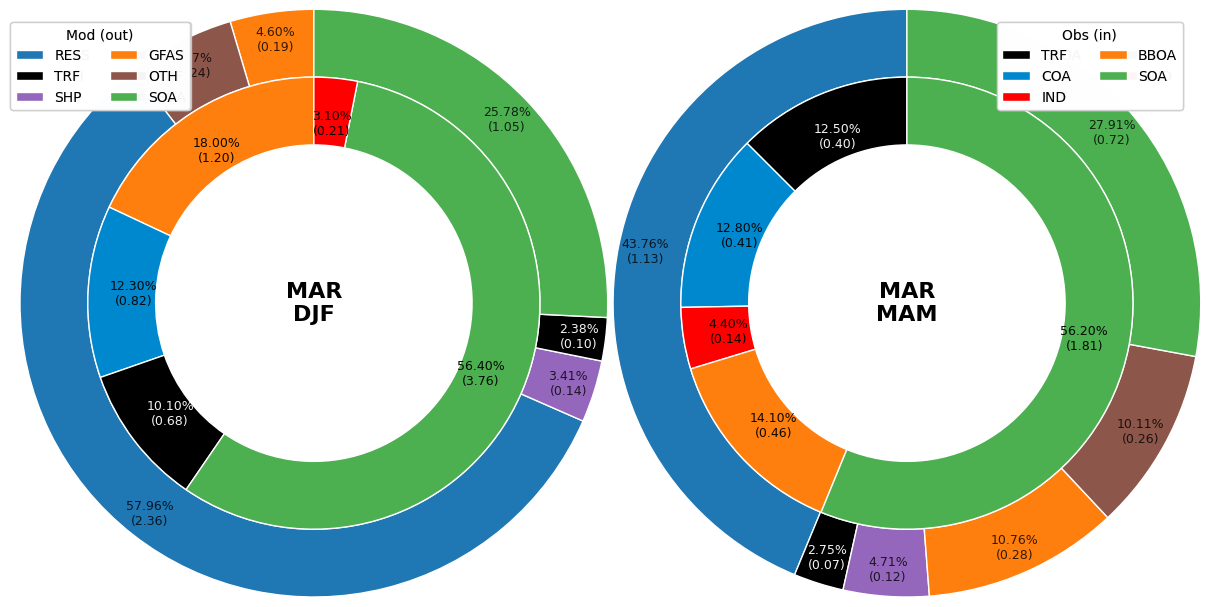

In [ ]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']

# Crear una figura para los subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 12)) # Ajusta el tamaño según sea necesario

# Aplanar el arreglo de ejes para facilitar el acceso en el bucle
axs = axs.flatten()

for i, season in enumerate(seasons):
    if season in datos_observacion.keys():
        # Datos de la temporada específica
        obs_data = datos_observacion[season]['perc_cont']
        mod_data = datos_modelo[season]['perc_cont']

        # Obtener colores y etiquetas para los datos de observación y modelo
        c_obs, t_obs = get_color_tags_obs(obs_data, etiquetas_obs, colores_obs, stn)
        c_mod, t_mod = get_color_tags_mod(mod_data, etiquetas_mod, colores_mod)

        # Crear gráficos de rosquilla para los datos del modelo con etiquetas y porcentajes personalizados
        valores_model = [f'{pct:.2f}%\n({abs_val:.2f})' for pct, abs_val in zip(mod_data.values, datos_modelo[season]['abs_cont'].values)]
        val_mod_iter = iter(valores_model)
        outside_pie, texts_out, autotexts_out = axs[i].pie(mod_data.values, autopct=lambda pct: next(val_mod_iter), radius=1.3, colors=c_mod, labeldistance=1.13, wedgeprops=dict(width=0.3, edgecolor='white'), startangle=90)
        plt.setp(outside_pie, width=0.3, edgecolor='white')
        for j, (pie_wedge, autotext) in enumerate(zip(outside_pie, autotexts_out)):
            ang = (pie_wedge.theta2 - pie_wedge.theta1) / 2 + pie_wedge.theta1
            x = np.cos(np.deg2rad(ang)) 
            y = np.sin(np.deg2rad(ang))
            face_color = pie_wedge.get_facecolor()
            # Para sectores pequeños, ajustar la posición de las etiquetas
            if pie_wedge.theta2 - pie_wedge.theta1 < 1:  # Ajusta el umbral según sea necesario
                autotext.set_text('')  # Ocultar el texto automático
                # Establecer propiedades de la caja de anotación y flecha
                bbox_props = dict(boxstyle="round,pad=0.03", fc="white", ec="black", lw=0.72)
                kw = dict(arrowprops=dict(arrowstyle="->", color="black"), bbox=bbox_props, zorder=0, va="center")
                # Determinar la alineación horizontal basada en la posición x
                horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
                # Determinar la posición de la anotación basada en el ángulo
                if x >= 0:
                    xytext = (1.5 * x, 2.5 * y)  # Mover la etiqueta más hacia afuera
                    #connectionstyle = f"angle,angleA=90,angleB={ang},rad=0.1"  # Ajustar la conexión para que la flecha apunte hacia el sector
                    connectionstyle = f"arc3,rad={-0.2 if y > 0 else 0.2}"
                else:
                    xytext = (1.3 * x, 4. * y)  # Mover la etiqueta más hacia afuera
                    #connectionstyle = f"angle,angleA=90,angleB={ang},rad=0.01"  # Ajustar la conexión para que la flecha apunte hacia el sector
                    connectionstyle = f"arc3,rad={-0.2 if y > 0 else 0.2}"

                arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle, color="black")
                ax.annotate(valores_model[i], xy=(x - 0.1, y), xytext=xytext,#(1.6*np.sign(x), 1.6*y),
                    horizontalalignment=horizontalalignment, arrowprops=arrowprops, bbox=bbox_props)

            else:
                face_color = pie_wedge.get_facecolor()
                if (face_color[0] == 0 and face_color[1] == 0 and face_color[2] == 0):
                    autotext.set_color('white')
                    autotext.set_position((x * 1.18, y * 1.18))
                    autotext.set_alpha(0.95)
                    autotext.set_fontsize(9)
                    autotext.set_horizontalalignment('center')
                    autotext.set_verticalalignment('center')
                else:
                    # Para sectores más grandes, centrar la etiqueta
                    autotext.set_position((x * 1.18, y * 1.18))  # Ajusta la distancia al centro si es necesario
                    autotext.set_alpha(0.8)
                    autotext.set_fontsize(9)  # Ajusta esto según sea necesario
                    autotext.set_horizontalalignment('center')
                    autotext.set_verticalalignment('center')

        # Crear gráficos de rosquilla para los datos de observación con etiquetas y porcentajes personalizados
        valores_obs = [f'{pct:.2f}%\n({abs_val:.2f})' for pct, abs_val in zip(obs_data.values, datos_observacion[season]['abs_cont'].values)]
        val_obs_iter = iter(valores_obs)
        inside_pie, texts_in, autotexts_in = axs[i].pie(obs_data.values, autopct=lambda pct: next(val_obs_iter), radius=1, colors=c_obs, labeldistance=0.7, wedgeprops=dict(width=0.3, edgecolor='white'), startangle=90)
        plt.setp(inside_pie, width=0.3, edgecolor='white')
        for k, (pie_wedge, autotext) in enumerate(zip(inside_pie, autotexts_in)):
            ang = (pie_wedge.theta2 - pie_wedge.theta1) / 2 + pie_wedge.theta1
            x = np.cos(np.deg2rad(ang))
            y = np.sin(np.deg2rad(ang))
            face_color = pie_wedge.get_facecolor()
            # Verificar si el color es negro (RGB: 0, 0, 0)
            if (face_color[0] == 0 and face_color[1] == 0 and face_color[2] == 0):
                autotext.set_color('white')
                autotext.set_position((x * .8, y * .8))
                autotext.set_alpha(0.95)
                autotext.set_fontsize(9)  # Ajusta esto según sea necesario
                autotext.set_horizontalalignment('center')
                autotext.set_verticalalignment('center')
            else:
                autotext.set_position((x * .8, y * .8))  # Ajusta la distancia al centro si es necesario
                autotext.set_alpha(0.95)
                autotext.set_fontsize(9)  # Ajusta esto según sea necesario
                autotext.set_horizontalalignment('center')
                autotext.set_verticalalignment('center')
            
        axs[i].text(0, 0, f'{stn}\n{season}', ha='center', va='center', fontsize=16, fontweight='bold')
        
        # Título para cada subgráfico
        #axs[i].set_title(f'{season}')
        # Leyendas
        legend_out = axs[0].legend(outside_pie, t_mod, title="Mod (out)", loc="upper left", bbox_to_anchor=(-0.05, 1.01), ncol=2)
        legend_in = axs[1].legend(inside_pie, t_obs, title="Obs (in)", loc="upper right", bbox_to_anchor=(1., 1.01), ncol=2)

        # Agregar las leyendas al gráfico
        axs[0].add_artist(legend_out)
        axs[1].add_artist(legend_in)
    else:
        # Ocultar los ejes si no hay datos
        axs[i].axis('off')
        #eliminar los subplots vacios
        fig.delaxes(axs[i])

plt.margins(0,0)
# Ajustar el layout para evitar superposiciones
plt.tight_layout(pad=1.0)

os.makedirs('figures_paper/sa_seasonal/', exist_ok=True)
plt.savefig(f'figures_paper/sa_seasonal/fig_conc_mass_{stn}_collocation_seasonal.png', dpi=300, bbox_inches='tight')
# Mostrar el gráfico
plt.show()

## MASS STATISTICS

In [ ]:
dict_of_names['stations'].values()

dict_values(['DEM', 'BCN', 'MSY', 'MAR', 'IPR', 'PAY', 'RIG', 'OPE', 'SIR', 'KRA', 'HEL', 'HYY'])

In [ ]:
def calcular_metricas_estaciones():
    # Inicializa un DataFrame para almacenar los resultados
    resultados = []
    
    # Lista de nombres de estaciones (ajusta esto según tus necesidades)
    nombres_estaciones = list(dict_of_names['stations'].values())
    #reverse
    nombres_estaciones = nombres_estaciones[::-1]

    for stn in nombres_estaciones:
        # Obtener datos observados y modelados
        data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True)
        data_mod_tot = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]).sum(axis=1),
                                    columns=['pm2p5oa'])

        # Calcular métricas
        corr = st.calculate_corr(data_obs, data_mod_tot)
        fb = st.calculate_fb(data_obs, data_mod_tot)
        fac2 = st.calculate_fac2(data_obs, data_mod_tot)

        # Obtener el nombre de la estación
        nombre_estacion = ut.convention_names_stations()["acr_first"][stn]
        
        # Añadir los resultados al DataFrame
        resultados.append({
            'STN': stn,
            'CORR': corr,
            'FAC2': fac2,
            'FB': fb
        })
        

    # Convertir la lista de resultados en un DataFrame de pandas
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.set_index('STN')
    #ordenar alfabeticamente

    return df_resultados



In [ ]:
# Llamar a la función y mostrar los resultados
df_resultados = calcular_metricas_estaciones()
df_resultados

CORR   FAC2     FB
STN                    
HYY  0.54  71.31 -16.75
HEL  0.56  81.75  19.31
KRA  0.57  75.17 -32.17
SIR  0.47  74.39  11.71
OPE  0.56  73.24 -17.75
RIG  0.70  75.00  -8.14
PAY  0.77  85.00 -21.14
IPR  0.68  65.12 -11.95
MAR  0.68  76.09 -37.17
MSY  0.21  57.65  37.90
BCN  0.33  69.90  24.81
DEM  0.40  80.37 -34.57

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

df_for_plotly = df_resultados.reset_index()


nombres_columnas = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df_for_plotly.columns.values]

# Crear una tabla Plotly
trace = go.Table(
    header=dict(values=nombres_columnas,
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df_for_plotly[col] for col in df_for_plotly.columns],
               fill_color='lavender',
               align='left'))

layout = go.Layout(
    width=700, 
    height=600
)

# Crear la figura con Plotly
fig = go.Figure(data=[trace], layout=layout)
if not os.path.exists('results_mass_stats'):
    os.makedirs('results_mass_stats')
# Guardar la figura como PNG usando Orca
pio.write_image(fig, 'results_mass_stats/tabla_resultados.png')



In [ ]:
def calcular_metricas_estaciones_seasons():
    # Inicializar una lista para almacenar los resultados
    resultados = []

    # Lista de nombres de estaciones y temporadas
    nombres_estaciones = list(dict_of_names['stations'].values())
    nombres_estaciones = nombres_estaciones[::-1]
    seasons = ['DJF', 'MAM', 'JJA', 'SON']

    for stn in nombres_estaciones:
        # Diccionario para almacenar los resultados de la estación actual
        resultados_estacion = {'STN': stn}

        for season in seasons:
            try:
                # Obtener datos observados y modelados para la estación y temporada actual
                data_obs_season = sdg.season(dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True))[season]
                data_mod_season = sdg.season(pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]).sum(axis=1), columns=['pm2p5oa']))[season]

                # Calcular métricas
                corr = st.calculate_corr(data_obs_season, data_mod_season)
                fb = st.calculate_fb(data_obs_season, data_mod_season)
                fac2 = st.calculate_fac2(data_obs_season, data_mod_season)
                nme = st.calculate_nme(data_obs_season, data_mod_season)
                nmb = st.calculate_nmb(data_obs_season, data_mod_season)
            except Exception as e:
                # En caso de un error (por ejemplo, datos faltantes), usar NaN para las métricas
                corr = np.nan
                fb = np.nan
                fac2 = np.nan
                nme = np.nan 
                nmb = np.nan

            # Añadir los resultados al diccionario de la estación
            resultados_estacion[('r', season)] = corr
            resultados_estacion[('FAC2', season)] = fac2
            resultados_estacion[('FB', season)] = fb
            resultados_estacion[('NME', season)] = nme 
            resultados_estacion[('NMB', season)] = nmb

        # Añadir los resultados de la estación a la lista de resultados
        resultados.append(resultados_estacion)
    
    # Convertir la lista de resultados en un DataFrame de pandas
    df_resultados = pd.DataFrame(resultados)

    # Configurar 'STN' como índice del DataFrame
    df_resultados = df_resultados.set_index('STN')

    # Crear MultiIndex para las columnas
    df_resultados.columns = pd.MultiIndex.from_tuples(df_resultados.columns, names=['Metric', 'Season'])
    #sort alphabetically the by station name

    
    return df_resultados

# Llamar a la función y mostrar los resultados
df_seasonal = calcular_metricas_estaciones_seasons()


In [ ]:
df_seasonal

Metric     r   FAC2     FB     NME     NMB     r   FAC2     FB    NME    NMB  \
Season   DJF    DJF    DJF     DJF     DJF   MAM    MAM    MAM    MAM    MAM   
STN                                                                            
HYY     0.94  23.53  84.43  146.11  146.11  0.64  79.17  -9.02  45.37  -8.63   
HEL     0.65  66.10  45.89   70.61   59.55  0.72  93.59  -3.64  33.46  -3.58   
KRA     0.53  73.33 -26.97   44.80  -23.77  0.67  90.48 -20.53  32.72 -18.62   
SIR     0.61  61.84  28.93   58.73   33.82  0.55  79.27  -3.06  37.00  -3.02   
OPE     0.80  70.59  -4.48   45.92   -4.38  0.85  68.42 -52.85  43.28 -41.81   
RIG     0.94  40.00  10.77   53.95   11.38 -0.06  71.43 -14.61  50.09 -13.62   
PAY     0.84  76.47 -12.39   32.32  -11.67  0.09  85.71 -13.43  28.80 -12.58   
IPR     0.62  61.54 -50.53   43.89  -40.34  0.33  49.32  17.31  70.19  18.95   
MAR     0.61  80.77 -29.05   37.95  -25.36  0.49  77.78  38.48  63.81  47.64   
MSY     0.66  14.29  95.00  180.93  180.93  0.39  57.14  54.86  86.62  75.59   
BCN     0.58  41.82  70.13  112.18  108.01  0.62  80.00  28.34  44.92  33.02   
DEM     0.47  83.33  -0.40   36.28   -0.40  0.41  86.21 -38.31  35.59 -32.15   

Metric     r    FAC2     FB    NME    NMB     r    FAC2     FB    NME    NMB  
Season   JJA     JJA    JJA    JJA    JJA   SON     SON    SON    SON    SON  
STN                                                                           
HYY     0.84   73.56 -52.56  43.73 -41.62  0.83   72.13  -3.78  39.10  -3.71  
HEL      NaN     NaN    NaN    NaN    NaN   NaN     NaN    NaN    NaN    NaN  
KRA     0.55   65.43 -55.38  44.73 -43.37  0.34   74.63 -32.54  41.06 -27.99  
SIR     0.63   87.78 -12.93  38.48 -12.14  0.36   66.25  32.90  64.81  39.37  
OPE     0.57   66.67 -51.30  43.48 -40.83  0.78   85.00  29.82  49.58  35.05  
RIG     0.77   75.00 -24.56  32.22 -21.88  0.61  100.00   3.16  26.98   3.21  
PAY     0.86  100.00 -32.95  33.78 -28.29  0.51   87.50 -31.94  29.23 -27.54  
IPR     0.26   75.28  17.77  45.24  19.50  0.52   71.43  21.84  52.85  24.51  
MAR     0.48   96.00  15.29  33.37  16.56   NaN     NaN    NaN    NaN    NaN  
MSY     0.63   86.96 -31.59  29.38 -27.28  0.52   70.00  48.39  69.02  63.84  
BCN     0.80   86.96 -37.33  32.21 -31.46  0.37   75.00  13.24  45.74  14.17  
DEM     0.38   72.22 -50.43  42.66 -40.27  0.58   83.02 -32.00  30.10 -27.59

In [ ]:
from modules import goal_criteria_st as gcs

In [ ]:
# Formatear el DataFrame
df_formatted = df_seasonal.style.format(subset=['NME', 'NMB', 'FB', 'FAC2', 'r'], precision=2)

# Aplicar las funciones a las columnas específicas
df_formatted = df_formatted.applymap(gcs.goal_nmb, subset="NMB")
df_formatted = df_formatted.applymap(gcs.goal_nme, subset="NME")
df_formatted = df_formatted.applymap(gcs.goal_fb, subset="FB")
df_formatted = df_formatted.applymap(gcs.criteria_fac2, subset="FAC2")
df_formatted = df_formatted.applymap(gcs.criteria_nme, subset="NME")
df_formatted = df_formatted.applymap(gcs.criteria_nmb, subset="NMB")
df_formatted = df_formatted.applymap(gcs.criteria_fb, subset='FB')

# Mostrar el DataFrame formateado
df_formatted

/tmp/ipykernel_72084/3739975674.py:5: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_formatted = df_formatted.applymap(gcs.goal_nmb, subset="NMB")
/tmp/ipykernel_72084/3739975674.py:6: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_formatted = df_formatted.applymap(gcs.goal_nme, subset="NME")
/tmp/ipykernel_72084/3739975674.py:7: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_formatted = df_formatted.applymap(gcs.goal_fb, subset="FB")
/tmp/ipykernel_72084/3739975674.py:8: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_formatted = df_formatted.applymap(gcs.criteria_fac2, subset="FAC2")
/tmp/ipykernel_72084/3739975674.py:9: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_formatted = df_formatted.applymap(gcs.criteria_nme, subset="NME")
/tmp/ipykernel_72084/3739975674.py:10: FutureWarning: Styler.applymap has been deprecat

In [ ]:
latex_df = df_formatted.to_latex(
        caption="Selected statistics",
        clines="skip-last;data",
        convert_css=True,
        position_float="centering",
        multicol_align="|c|",
        hrules=True,
    )
 
    
print('*********************************')
print('           For latex             ')
print('*********************************')
print(latex_df)
print('*********************************')

*********************************
           For latex             
*********************************
\begin{table}
\centering
\caption{Selected statistics}
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}
\toprule
Metric & r & FAC2 & FB & NME & NMB & r & FAC2 & FB & NME & NMB & r & FAC2 & FB & NME & NMB & r & FAC2 & FB & NME & NMB \\
Season & DJF & DJF & DJF & DJF & DJF & MAM & MAM & MAM & MAM & MAM & JJA & JJA & JJA & JJA & JJA & SON & SON & SON & SON & SON \\
STN &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
HYY & 0.94 & 23.53 & 84.43 & 146.11 & 146.11 & 0.64 & \bfseries 79.17 & {\cellcolor{gray}} \bfseries -9.02 & \bfseries 45.37 & {\cellcolor{gray}} \bfseries -8.63 & 0.84 & \bfseries 73.56 & \bfseries -52.56 & {\cellcolor{gray}} \bfseries 43.73 & \bfseries -41.62 & 0.83 & \bfseries 72.13 & {\cellcolor{gray}} \bfseries -3.78 & {\cellcolor{gray}} \bfseries 39.10 & {\cellcolor{gray}} \bfseries -3.71 \\
HEL & 0.65 & \bfseries 66.10 & \bfseries 45.89 & 70.61 & 59.55 & 0

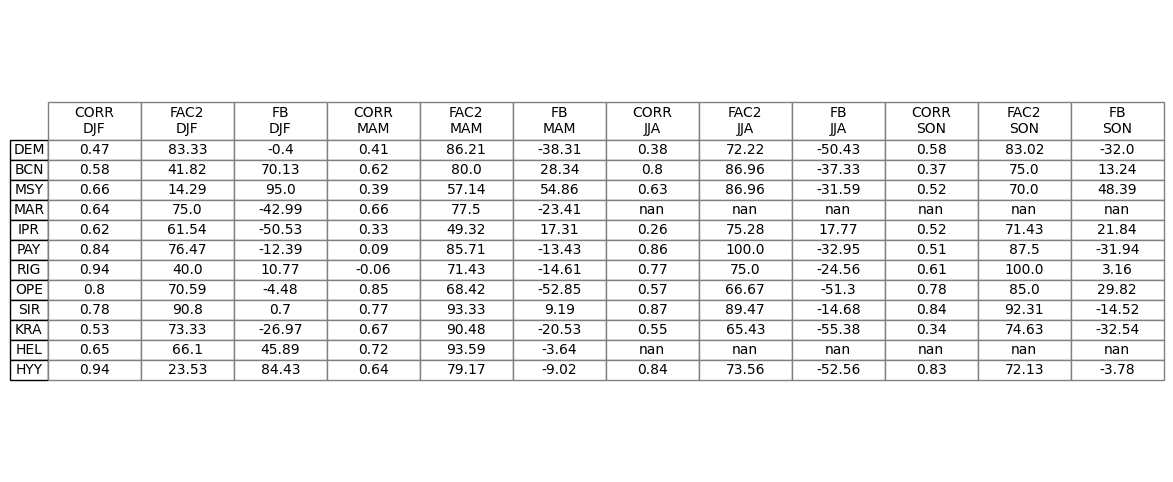

In [ ]:
nombres_columnas = ['\n'.join(col).strip() for col in df_resultados_temporadas.columns.values]

# Crea una figura y un eje con matplotlib
fig, ax = plt.subplots(figsize=(12, 6))  # Ajusta el tamaño según sea necesario

# Oculta los ejes
ax.axis('off')

# Crea una tabla en el eje
tabla = ax.table(cellText=df_resultados_temporadas.values, 
                 colLabels=nombres_columnas, 
                 rowLabels=df_resultados_temporadas.index, 
                 cellLoc = 'center', rowLoc = 'center',
                 loc='center')

# Estilo al estilo LaTeX
# Desactivar todas las líneas de la cuadrícula excepto las del encabezado y la del final
for key, cell in tabla.get_celld().items():
    if key[1] == -1:  # Encabezado
        cell.set_linewidth(1)
        cell.set_edgecolor('black')
    else:
        cell.set_linewidth(1)
        cell.set_edgecolor('gray')  # Poner el mismo color que el fondo

# Ajusta la altura del encabezado de la tabla
# Itera solo sobre las celdas del encabezado
for col in range(len(nombres_columnas)):
    tabla[(0, col)].set_height(0.07)  # Ajusta este valor según sea necesario

# Ajusta la escala de la tabla
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)  # Ajusta el tamaño de la fuente según sea necesario
tabla.scale(1.2, 1.2)  # Ajusta el tamaño de la celda según sea necesario


#crear una carpeta para guardar los resultados
if not os.path.exists('results_mass_stats'):
    os.makedirs('results_mass_stats')
# Guarda la figura
plt.savefig('results_mass_stats/tabla_resultados_by_season.png', bbox_inches='tight', dpi=300)

In [ ]:
data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"]['BCN'], remove_negatives=True)
data_mod_sa = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"]['BCN']).sum(axis=1), columns=['pm2p5oa'])

In [ ]:
obs, mod = st.preproc_data_collocation(data_obs, data_mod_sa, filled=False)

In [ ]:
st.statistics4taylor(obs, mod)

{'std_obs': 2.244253882408223,
 'std_mod': 2.7123568763421426,
 'corr': 0.33,
 'rmse': 3.13}

In [ ]:

def calculate_taylor_statistics(stations, get_mass_obs, get_mass_mod, preproc_data_collocation, statistics4taylor):
    """
    Calculate Taylor diagram statistics for multiple stations.

    Args:
    stations (dict): A dictionary with station acronyms and their full names.
    get_mass_obs (function): Function to get observed data.
    get_mass_mod (function): Function to get modeled data.
    preproc_data_collocation (function): Function to preprocess and collocate data.
    statistics4taylor (function): Function to calculate statistics for Taylor diagram.

    Returns:
    dict: A dictionary with Taylor diagram statistics for each station.
    """
    taylor_statistics = {}

    for station_acronym, station_name in stations.items():
        # Obtain observed and modeled data for the current station
        data_obs = get_mass_obs(station_name, remove_negatives=True)
        data_mod_sa = pd.DataFrame(get_mass_mod(station_name).sum(axis=1), columns=['pm2p5oa'])

        # Preprocess and align the data
        obs, mod = preproc_data_collocation(data_obs, data_mod_sa, filled=False)

        # Calculate statistics for the Taylor diagram
        statistics = statistics4taylor(obs, mod)

        # Add the statistics to the dictionary
        taylor_statistics[station_acronym] = statistics

    return taylor_statistics

# Example usage
# Assuming the required functions and station list are defined
stations = ut.convention_names_stations()["acr_first"]
taylor_stats = calculate_taylor_statistics(stations, dr.get_mass_obs, dr.get_mass_mod, st.preproc_data_collocation, st.statistics4taylor)


In [ ]:
def get_refstd_global(stations, get_mass_obs, get_mass_mod, preproc_data_collocation, statistics4taylor):
    """
    Calculate the global reference standard deviation for multiple stations.
    """
    all_obs_data = []  # Lista para acumular todos los datos observados

    for station_acronym, station_name in stations.items():
        # Obtener datos observados y modelados para la estación actual
        data_obs = get_mass_obs(station_name, remove_negatives=True)
        
        # Asumiendo que la función 'get_mass_mod' y 'preproc_data_collocation' ya hacen lo necesario
        # y que solo necesitas los datos observados para calcular la desviación estándar de referencia global
        data_mod = get_mass_mod(station_name)  # Este paso puede ser opcional dependiendo de tu flujo de trabajo

        # Preprocesar y colocalizar los datos (este paso es específico de tu flujo de trabajo y puede variar)
        obs, mod = preproc_data_collocation(data_obs, data_mod, filled=False)
        
        # Agregar los datos observados procesados a la lista acumulativa
        all_obs_data.append(obs)

    # Concatenar todos los datos observados en un DataFrame de pandas
    all_obs_data_concat = pd.concat(all_obs_data)

    # Calcular la desviación estándar global de los datos observados acumulados
    refstd_global = all_obs_data_concat.std()

    return refstd_global
# Assuming the required functions and station list are defined
refstd_global = get_refstd_global(stations, dr.get_mass_obs, dr.get_mass_mod, st.preproc_data_collocation, st.statistics4taylor)

In [ ]:
taylor_stats

{'DEM': {'std_obs': 2.012300151001275,
  'std_mod': 1.376279677831296,
  'corr': 0.4,
  'rmse': 2.43},
 'BCN': {'std_obs': 2.244253882408223,
  'std_mod': 2.7123568763421426,
  'corr': 0.33,
  'rmse': 3.13},
 'MSY': {'std_obs': 1.9309765142390294,
  'std_mod': 2.0509084792351295,
  'corr': 0.21,
  'rmse': 2.86},
 'MAR': {'std_obs': 2.8964815331631972,
  'std_mod': 1.9775241207240832,
  'corr': 0.57,
  'rmse': 2.4},
 'IPR': {'std_obs': 7.761707566817686,
  'std_mod': 4.1859649980730325,
  'corr': 0.68,
  'rmse': 5.89},
 'PAY': {'std_obs': 2.140246647166346,
  'std_mod': 1.499130243653848,
  'corr': 0.77,
  'rmse': 1.57},
 'RIG': {'std_obs': 1.8232017358313437,
  'std_mod': 1.1812700575723785,
  'corr': 0.7,
  'rmse': 1.32},
 'OPE': {'std_obs': 3.2343233814804675,
  'std_mod': 2.7437460893196244,
  'corr': 0.56,
  'rmse': 2.93},
 'SIR': {'std_obs': 2.769999357395043,
  'std_mod': 2.837872375972037,
  'corr': 0.47,
  'rmse': 2.94},
 'KRA': {'std_obs': 10.241886370534898,
  'std_mod': 6.02

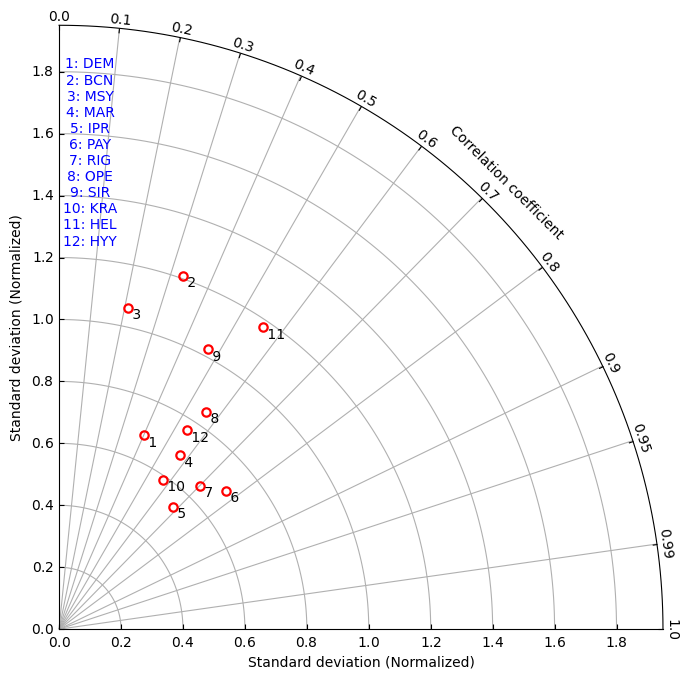

In [ ]:
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa


class TaylorDiagram(object):
  def __init__(self, STD ,fig=None, rect=111, label='_', sampleSTDs=None):
    self.STD = STD
    tr = PolarAxes.PolarTransform()
    self.labels = {} 
    # Correlation labels
    rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
    tlocs = np.arccos(rlocs) # Conversion to polar angles
    gl1 = gf.FixedLocator(tlocs) # Positions
    tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
    # Standard deviation axis extent
    self.smin = 0
    self.smax = .3 * self.STD
    gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
    if fig is None:
      fig = plt.figure()
    ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
    fig.add_subplot(ax)
    # Angle axis
    ax.axis['top'].set_axis_direction('bottom')
    ax.axis['top'].label.set_text("Correlation coefficient")
    ax.axis['top'].toggle(ticklabels=True, label=True)
    ax.axis['top'].major_ticklabels.set_axis_direction('top')
    ax.axis['top'].label.set_axis_direction('top')
    # X axis
    ax.axis['left'].set_axis_direction('bottom')
    ax.axis['left'].label.set_text("Standard deviation (Normalized)")
    ax.axis['left'].toggle(ticklabels=True, label=True)
    ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
    ax.axis['left'].label.set_axis_direction('bottom')
    # Y axis
    ax.axis['right'].set_axis_direction('top')
    ax.axis['right'].label.set_text("Standard deviation (Normalized)")
    ax.axis['right'].toggle(ticklabels=True, label=True)
    ax.axis['right'].major_ticklabels.set_axis_direction('left')
    ax.axis['right'].label.set_axis_direction('top')
    # Useless
    ax.axis['bottom'].set_visible(False)
    # Contours along standard deviations
    ax.grid()
    self._ax = ax # Graphical axes
    self.ax = ax.get_aux_axes(tr) # Polar coordinates
    # Add reference point and STD contour
    l , = self.ax.plot([0], self.STD, 'k*', ls='', ms=12, label=label)
    t = np.linspace(0, (np.pi / 2.0))
    r = np.zeros_like(t) + self.STD
    #self.ax.plot(t, r, 'k--', label='_')
    # Collect sample points for latter use (e.g. legend)
    self.samplePoints = [l]
    '''def add_sample(self,STD,r,*args,label=None,**kwargs):
      l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
      self.samplePoints.append(l)
      #añadir la etiqueta al punto
      if label is not None:
          # Calcula una posición ajustada para el texto si es necesario
          x_text = np.arccos(r)
          y_text = STD
          self.ax.text(x_text, y_text, ' ' + label, ha='left', va='top')
      return l'''

  def add_sample(self, STD, r, identifier, *args, **kwargs):
      l, = self.ax.plot(np.arccos(r), STD, *args, **kwargs)
      self.ax.text(np.arccos(r), STD, f' {identifier}', ha='left', va='top')
      if 'label' in kwargs:  # Aquí asumimos que 'label' se pasa como un kwarg
          self.labels[identifier] = kwargs['label']  # Asignación de la etiqueta al identificador
      return l


  def add_contours(self, levels=5, **kwargs):
    rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
    RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
    contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
    return contours

'''def srl(obsSTD, s, r, l, fname):
  fig=plt.figure(figsize=(8,8))
  dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='ref')
  #plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)
  srlc = zip(s, r, l)
   
  #for i in srlc:
  #  dia.add_sample(i[0], i[1], label=i[2], marker='o',mec = 'red', mfc = 'none', mew=1.6)
  for std, corr, label in srlc:
    dia.add_sample(std, corr, label=label, marker='o', mec='red', mfc='none', mew=1.6)


  spl = [p.get_label() for p in dia.samplePoints]
  #fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='small'), loc=[0.7,0.3])
  plt.show()'''
def srl(obsSTD, s, r, l, fname):
    fig = plt.figure(figsize=(8, 8))
    dia = TaylorDiagram(obsSTD, fig=fig, rect=111, label='Ref')
    identifier = 1  # Inicializa un identificador numérico para las muestras
    
    for std, corr, label in zip(s, r, l):
        # Añade la muestra sin pasar la etiqueta a add_sample
        dia.add_sample(std, corr, identifier=identifier, marker='o', mec='red', mfc='none', mew=1.6)
        # Guarda la etiqueta con su identificador en el diccionario de labels
        dia.labels[identifier] = label
        identifier += 1

    # Calcular la separación vertical entre las etiquetas
    vertical_spacing = 0.008 * dia.STD

    # Ajustar las coordenadas x e y de las etiquetas
    x_offset = 0.1  # Desplazamiento horizontal
    y_offset = 1.9  # Desplazamiento vertical
    
    # Recorrer el diccionario de etiquetas comenzando desde el ID 1
    for id in range(1, len(dia.labels) + 1):
        label = dia.labels[id]
        x = x_offset  # Ajustar el desplazamiento horizontal
        y = -(id * vertical_spacing) + y_offset  # Ajustar el desplazamiento vertical hacia arriba
        plt.text(x, y, f'{id}: {label}', fontsize=10, ha='center', va='top', color='blue')
    #save on figures_paper
    os.makedirs('figures_paper/taylor_diagram_mass', exist_ok=True)
    plt.savefig(f'figures_paper/taylor_diagram_mass/{fname}', dpi=300, bbox_inches='tight')

    plt.show()




std_obs = [taylor_stats[site]['std_obs'] for site in taylor_stats]
obsSTD = refstd_global.values[0] #min(std_obs)

s = [taylor_stats[site]['std_mod']/taylor_stats[site]['std_obs'] for site in taylor_stats]
r = [taylor_stats[site]['corr'] for site in taylor_stats]

l = [site for site in taylor_stats]


fname = 'TaylorDiagram_mass.png'
srl(obsSTD, s, r, l, fname)

In [ ]:
refstd_global.values[0]

6.737019676227106

In [ ]:
taylor_stats['BCN']['std_mod']

2.7123568763421426

# OPTIMIZED RI 

In [6]:
#by station
method = 'SLSQP'
path_ri = 'ri_tables/'

In [7]:
stations = list(dict_of_names['acr_first'].keys())[::-1]
stations

['HYY',
 'HEL',
 'KRA',
 'SIR',
 'OPE',
 'RIG',
 'PAY',
 'IPR',
 'MAR',
 'MSY',
 'BCN',
 'DEM']

In [13]:
data_por_estacion = {}

# Iterar sobre cada estación
for stn in stations:
    # Cargar los dataframes para la estación actual
    weakly_by_stn = pd.read_csv(f"{path_ri}monarch_best_weakly/RI_by_station/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    moderately_by_stn = pd.read_csv(f"{path_ri}monarch_best_moderately/RI_by_station/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    strongly_by_stn = pd.read_csv(f"{path_ri}monarch_best_strongly/RI_by_station/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    oa_by_stn = pd.read_csv(f"{path_ri}monarch_best_oa/RI_by_station/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0) 
    
    # Unir los DataFrames
    df_unido = pd.concat([weakly_by_stn, moderately_by_stn, strongly_by_stn, oa_by_stn], axis=1)
    
    # Renombrar las columnas para que reflejen las categorías 'w', 'm', 's'
    num_columnas = len(weakly_by_stn.columns)
    nuevas_columnas = ['w', 'm', 's', 'oa']
    df_unido.columns = nuevas_columnas
    
    # Asignar el dataframe combinado al diccionario para la estación actual
    data_por_estacion[stn] = df_unido

# Para ver la estructura de datos para una estación específica, por ejemplo 'BCN'
print(data_por_estacion['MSY'])

              w       m       s      oa
RI_name                                
poagfs   0.1582  0.0181  0.1219     NaN
soagfs   0.0011  0.0049  0.0181     NaN
poares   0.0079  0.0181  0.0181     NaN
soares   0.0079  0.0181  0.0181     NaN
poashp   0.0592  0.0181  0.0181     NaN
soashp   0.0011  0.0049  0.0049     NaN
poatrf   0.0011  0.0011  0.0011     NaN
soatrf   0.0011  0.0011  0.0011     NaN
poaoth   0.0011  0.0011  0.0011     NaN
soaoth   0.0011  0.0011  0.0011     NaN
oa          NaN     NaN     NaN  0.0051


In [34]:
#read new ri 
df = data_por_estacion

In [35]:
df 

{'HYY':               w       m       s      oa
 RI_name                                
 poagfs   0.0354  0.0354  0.1219     NaN
 soagfs   0.0011  0.0049  0.0181     NaN
 poares   0.0213  0.0209  0.0193     NaN
 soares   0.0111  0.0204  0.0187     NaN
 poashp   0.0344  0.0353  0.1219     NaN
 soashp   0.0344  0.0353  0.1100     NaN
 poatrf   0.0354  0.0354  0.0354     NaN
 soatrf   0.0354  0.0354  0.0354     NaN
 poaoth   0.0034  0.0034  0.0027     NaN
 soaoth   0.0028  0.0029  0.0026     NaN
 oa          NaN     NaN     NaN  0.0104,
 'HEL':               w       m       s      oa
 RI_name                                
 poagfs   0.1604  0.1719  0.1559     NaN
 soagfs   0.0011  0.0049  0.0181     NaN
 poares   0.0380  0.0381  0.0382     NaN
 soares   0.0297  0.0069  0.0162     NaN
 poashp   0.1604  0.1719  0.1559     NaN
 soashp   0.0354  0.1604  0.1487     NaN
 poatrf   0.0354  0.0354  0.0354     NaN
 soatrf   0.0354  0.0354  0.0354     NaN
 poaoth   0.0027  0.0020  0.0025     NaN
 

In [36]:
df.items()

dict_items([('HYY',               w       m       s      oa
RI_name                                
poagfs   0.0354  0.0354  0.1219     NaN
soagfs   0.0011  0.0049  0.0181     NaN
poares   0.0213  0.0209  0.0193     NaN
soares   0.0111  0.0204  0.0187     NaN
poashp   0.0344  0.0353  0.1219     NaN
soashp   0.0344  0.0353  0.1100     NaN
poatrf   0.0354  0.0354  0.0354     NaN
soatrf   0.0354  0.0354  0.0354     NaN
poaoth   0.0034  0.0034  0.0027     NaN
soaoth   0.0028  0.0029  0.0026     NaN
oa          NaN     NaN     NaN  0.0104), ('HEL',               w       m       s      oa
RI_name                                
poagfs   0.1604  0.1719  0.1559     NaN
soagfs   0.0011  0.0049  0.0181     NaN
poares   0.0380  0.0381  0.0382     NaN
soares   0.0297  0.0069  0.0162     NaN
poashp   0.1604  0.1719  0.1559     NaN
soashp   0.0354  0.1604  0.1487     NaN
poatrf   0.0354  0.0354  0.0354     NaN
soatrf   0.0354  0.0354  0.0354     NaN
poaoth   0.0027  0.0020  0.0025     NaN
soaoth   0

In [37]:
frames = {}
for location, d in df.items():
    df_temp = pd.DataFrame(d)
    #df_temp.set_index('RI_name', inplace=True)
    frames[location] = df_temp

# Combine into a single DataFrame with MultiIndex columns
df_combined = pd.concat(frames, axis=1)

df_combined

HYY                             HEL                          \
              w       m       s      oa       w       m       s      oa   
RI_name                                                                   
poagfs   0.0354  0.0354  0.1219     NaN  0.1604  0.1719  0.1559     NaN   
soagfs   0.0011  0.0049  0.0181     NaN  0.0011  0.0049  0.0181     NaN   
poares   0.0213  0.0209  0.0193     NaN  0.0380  0.0381  0.0382     NaN   
soares   0.0111  0.0204  0.0187     NaN  0.0297  0.0069  0.0162     NaN   
poashp   0.0344  0.0353  0.1219     NaN  0.1604  0.1719  0.1559     NaN   
soashp   0.0344  0.0353  0.1100     NaN  0.0354  0.1604  0.1487     NaN   
poatrf   0.0354  0.0354  0.0354     NaN  0.0354  0.0354  0.0354     NaN   
soatrf   0.0354  0.0354  0.0354     NaN  0.0354  0.0354  0.0354     NaN   
poaoth   0.0034  0.0034  0.0027     NaN  0.0027  0.0020  0.0025     NaN   
soaoth   0.0028  0.0029  0.0026     NaN  0.0027  0.0020  0.0025     NaN   
oa          NaN     NaN     NaN  0.0104     NaN     NaN     NaN  0.0284   

            KRA          ...     MSY             BCN                          \
              w       m  ...       s      oa       w       m       s      oa   
RI_name                  ...                                                   
poagfs   0.0316  0.0316  ...  0.1219     NaN  0.1604  0.4636  0.5375     NaN   
soagfs   0.0011  0.0049  ...  0.0181     NaN  0.0011  0.0049  0.0181     NaN   
poares   0.0316  0.0316  ...  0.0181     NaN  0.0276  0.0273  0.0272     NaN   
soares   0.0095  0.0192  ...  0.0181     NaN  0.0155  0.0273  0.0138     NaN   
poashp   0.0316  0.0315  ...  0.0181     NaN  0.0168  0.0194  0.0195     NaN   
soashp   0.0011  0.0049  ...  0.0049     NaN  0.0168  0.0194  0.0195     NaN   
poatrf   0.0011  0.0011  ...  0.0011     NaN  0.0354  0.0354  0.0354     NaN   
soatrf   0.0011  0.0011  ...  0.0011     NaN  0.0354  0.0354  0.0354     NaN   
poaoth   0.0011  0.0011  ...  0.0011     NaN  0.0249  0.0322  0.0354     NaN   
soaoth   0.0011  0.0011  ...  0.0011     NaN  0.0178  0.0109  0.0081     NaN   
oa          NaN     NaN  ...     NaN  0.0051     NaN     NaN     NaN  0.0262   

            DEM                          
              w       m       s      oa  
RI_name                                  
poagfs   0.0584  0.0575  0.1219     NaN  
soagfs   0.0011  0.0049  0.0181     NaN  
poares   0.0584  0.0575  0.0583     NaN  
soares   0.0182  0.0249  0.0236     NaN  
poashp   0.0049  0.0181  0.0181     NaN  
soashp   0.0011  0.0049  0.0049     NaN  
poatrf   0.0011  0.0011  0.0011     NaN  
soatrf   0.0011  0.0011  0.0011     NaN  
poaoth   0.0033  0.0031  0.0011     NaN  
soaoth   0.0033  0.0030  0.0011     NaN  
oa          NaN     NaN     NaN  0.0156  

[11 rows x 48 columns]

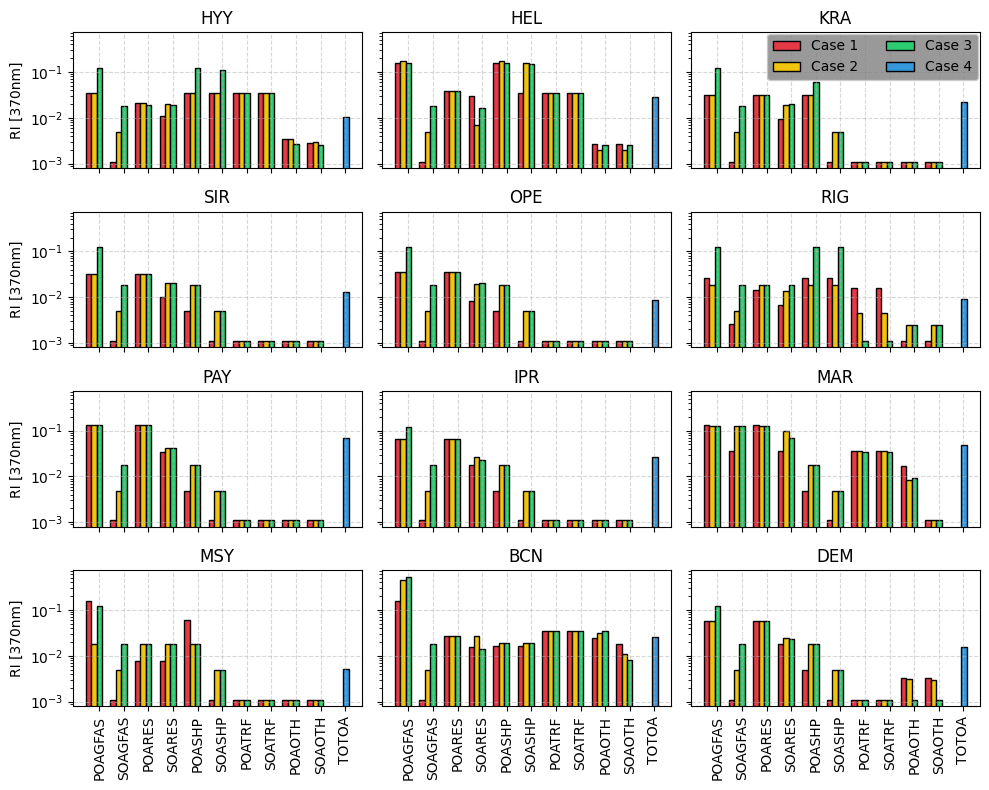

In [38]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 8), sharex=True, sharey=True)

# Aplanar el array de ejes para facilitar su iteración
axes = axes.flatten()

legend_labels = {'w': 'Case 1', 'm': 'Case 2', 's': 'Case 3', 'oa': 'Case 4'}
new_paleta_colores = ['#E63946',  # Rojo Carmesí
                      '#F1C40F',  # Amarillo Dorado
                      '#2ECC71',  # Verde Esmeralda
                      '#3498DB'] 
hatches = ['/', 'o', 'x', '-']

group_width = 1.5
num_bars = len(legend_labels)
bar_width = group_width / num_bars
group_spacing = 0.2  # Spacing between groups

#handles = [plt.Rectangle((0,0),1,1, color=new_paleta_colores[i], hatch=hatches[i]) for i in range(len(legend_labels))]
handles = [mpatches.Patch(facecolor=new_paleta_colores[i], edgecolor='black') for i in range(len(legend_labels))] #, hatch=hatches[i]
new_order = ['POAGFAS', 'SOAGFAS', 'POARES', 'SOARES', 'POASHP', 'SOASHP', 'POATRF', 'SOATRF', 'POAOTH', 'SOAOTH', 'TOTOA']

for i, (stn, df) in enumerate(data_por_estacion.items()):
    ax = axes[i]

    for j, (orig_col, new_label) in enumerate(legend_labels.items()):
        positions = np.arange(len(df)) * (group_width + group_spacing) - group_width / 2 + j * bar_width

        if orig_col == 'oa':
            positions += bar_width - 0.7 # Center the 'oa' bar when it is alone in its group
            

        ax.bar(positions, df[orig_col], width=bar_width, color=new_paleta_colores[j], edgecolor='black',\
             label=new_label) # hatch=hatches[j],

    ax.set_yscale('log')
    ax.title.set_text(stn)
    ax.set_xticks(np.arange(len(df)) * (group_width + group_spacing))
    ax.set_xticklabels(new_order, rotation=90)
    ax.grid(True, linestyle='--', alpha=0.5)
    #set the y label only in the left side
    if i % 3 == 0:
        ax.set_ylabel('RI [370nm]')

plt.tight_layout()
fig.legend(handles, list(legend_labels.values()), loc='upper right', bbox_to_anchor=(.99, .96), ncols=2, facecolor='gray')

os.makedirs('figures_paper/ri_optimized', exist_ok=True)
fig.savefig(f"figures_paper/ri_optimized/opt_by_stn.png", dpi=300, bbox_inches='tight')

plt.show()

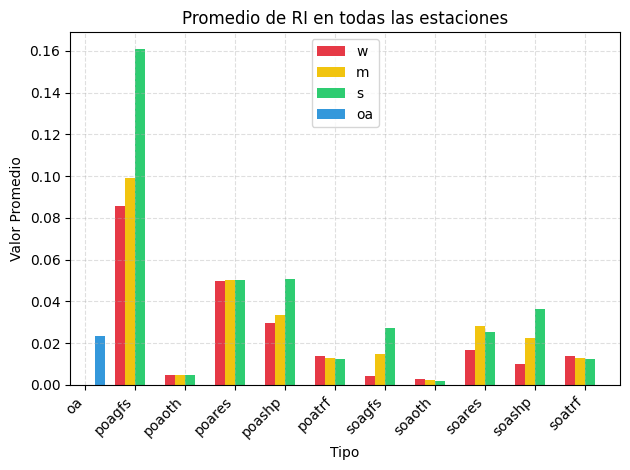

In [39]:
paleta_colores = ['#E63946',  # Rojo Carmesí
                      '#F1C40F',  # Amarillo Dorado
                      '#2ECC71',  # Verde Esmeralda
                      '#3498DB']  # Azul Brillante
#promediando todos los valores para cada tipo
df_consolidado = pd.DataFrame(columns=['w', 'm', 's', 'oa'])

# Sumar o promediar los valores para 'w', 'm', 's' de cada estación
for stn, df in data_por_estacion.items():
    df_consolidado = df_consolidado.add(df, fill_value=0)

# Dividir para obtener el promedio si eso es lo que deseas
df_consolidado = df_consolidado / len(data_por_estacion)

# Crear un gráfico de barras con los valores consolidados
fig, ax = plt.subplots()

# Ancho de las barras
bar_width = 0.2

# Posiciones de las barras
index = df_consolidado.index
n_groups = len(index)
bar_positions = [x - bar_width*1.5 for x in range(n_groups)]

# Crear las barras
ax.bar(bar_positions, df_consolidado['w'], width=bar_width, label='w', color='#E63946')
ax.bar([p + bar_width for p in bar_positions], df_consolidado['m'], width=bar_width, label='m', color='#F1C40F')
ax.bar([p + bar_width*2 for p in bar_positions], df_consolidado['s'], width=bar_width, label='s', color='#2ECC71')
ax.bar([p + bar_width*3 for p in bar_positions], df_consolidado['oa'], width=bar_width, label='oa', color='#3498DB')

# Añadir las etiquetas y el título
ax.set_xlabel('Tipo')
ax.set_ylabel('Valor Promedio')
ax.set_title('Promedio de RI en todas las estaciones')
ax.set_xticks([p + bar_width*1.5 for p in bar_positions])
ax.set_xticklabels(index, rotation=45, ha='right')
ax.grid(True, linestyle='--', alpha=0.4)

# Añadir la leyenda
ax.legend()

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()

# Guardar la figura
fig.savefig(f"figures_paper/ri_optimized/opt_by_stn_averaged.png", dpi=300, bbox_inches='tight')

In [8]:
#all
weakly_all = pd.read_csv(f"{path_ri}monarch_best_weakly/RI_all/RI_{method}_best.csv", index_col=0)
moderately_all = pd.read_csv(f"{path_ri}monarch_best_moderately/RI_all/RI_{method}_best.csv", index_col=0)
strongly_all = pd.read_csv(f"{path_ri}monarch_best_strongly/RI_all/RI_{method}_best.csv", index_col=0)
oa_all = pd.read_csv(f"{path_ri}monarch_best_oa/RI_all/RI_{method}_best.csv", index_col=0)

In [9]:
df_all = pd.concat([weakly_all, moderately_all, strongly_all, oa_all], axis=1)
columnas = ['w', 'm', 's', 'oa']

df_all.columns = columnas

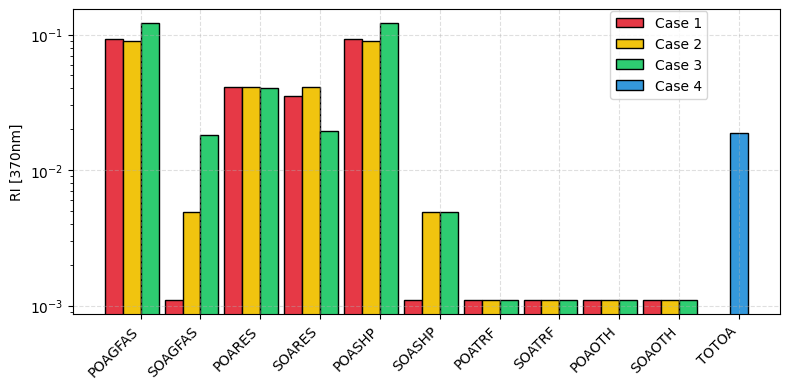

In [42]:
#hacer un grafico de barras 
fig, ax = plt.subplots(figsize=(8, 4))

# Ancho de las barras
bar_width = 0.3

# Posiciones de las barras
index = df_all.index
n_groups = len(index)
bar_positions = [x - bar_width*1.5 for x in range(n_groups)]


# Crear las barras
ax.bar(bar_positions, df_all['w'], width=bar_width, label='Case 1', color='#E63946', edgecolor='black')
ax.bar([p + bar_width for p in bar_positions], df_all['m'], width=bar_width, label='Case 2', color='#F1C40F', edgecolor='black')
ax.bar([p + bar_width*2 for p in bar_positions], df_all['s'], width=bar_width, label='Case 3', color='#2ECC71', edgecolor='black')
ax.bar([p + bar_width*1.5 for p in bar_positions], df_all['oa'], width=bar_width, label='Case 4', color='#3498DB', edgecolor='black')

# Añadir las etiquetas y el título
#ax.set_xlabel('Categoría')
ax.set_ylabel('RI [370nm]')
#ax.set_title('Optimización en todas las estaciones')
ax.set_xticks([p + bar_width*1.5 for p in bar_positions])
ax.set_xticklabels(new_order, rotation=45, ha='right')
ax.grid(True, linestyle='--', alpha=0.4)
#log scale
ax.set_yscale('log')

# Añadir la leyenda
# Ubicar la leyenda a la derecha del gráfico
ax.legend(loc='center left', bbox_to_anchor=(.75, 0.85))

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()

# Guardar la figura
fig.savefig(f"figures_paper/ri_optimized/opt_all.png", dpi=300, bbox_inches='tight')

## Without SOA in BrC RI calculation

In [43]:
stations 

['HYY',
 'HEL',
 'KRA',
 'SIR',
 'OPE',
 'RIG',
 'PAY',
 'IPR',
 'MAR',
 'MSY',
 'BCN',
 'DEM']

In [10]:
data_nosoa = {}

# Iterar sobre cada estación
for stn in stations:
    # Cargar los dataframes para la estación actual
    weakly_by_stn = pd.read_csv(f"{path_ri}monarch_best_weakly/RI_by_station/no_secondary/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    moderately_by_stn = pd.read_csv(f"{path_ri}monarch_best_moderately/RI_by_station/no_secondary/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    strongly_by_stn = pd.read_csv(f"{path_ri}monarch_best_strongly/RI_by_station/no_secondary/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    new_case = pd.read_csv(f"{path_ri}monarch_best_newcase/RI_by_station/no_secondary/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    oa_by_stn = pd.read_csv(f"{path_ri}monarch_best_oa/RI_by_station/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0) 
    
    # Unir los DataFrames
    df_unido = pd.concat([weakly_by_stn, moderately_by_stn, strongly_by_stn, new_case, oa_by_stn], axis=1)
    
    # Renombrar las columnas para que reflejen las categorías 'w', 'm', 's'
    num_columnas = len(weakly_by_stn.columns)
    nuevas_columnas = ['c1', 'c2', 'c3', 'c4', 'c5']
    df_unido.columns = nuevas_columnas
    
    # Asignar el dataframe combinado al diccionario para la estación actual
    data_nosoa[stn] = df_unido

# Para ver la estructura de datos para una estación específica, por ejemplo 'BCN'

In [35]:
[data_nosoa[i].loc['traf'] for i in stations ]

[c1    0.0354
 c2    0.0354
 c3    0.0354
 c4    0.0381
 c5       NaN
 Name: traf, dtype: float64,
 c1    0.0354
 c2    0.0354
 c3    0.0354
 c4    0.0708
 c5       NaN
 Name: traf, dtype: float64,
 c1    0.0011
 c2    0.0011
 c3    0.0011
 c4    0.0049
 c5       NaN
 Name: traf, dtype: float64,
 c1    0.0011
 c2    0.0011
 c3    0.0011
 c4    0.0049
 c5       NaN
 Name: traf, dtype: float64,
 c1    0.0011
 c2    0.0011
 c3    0.0011
 c4    0.0049
 c5       NaN
 Name: traf, dtype: float64,
 c1    0.0160
 c2    0.0023
 c3    0.0011
 c4    0.0159
 c5       NaN
 Name: traf, dtype: float64,
 c1    0.0011
 c2    0.0011
 c3    0.0011
 c4    0.0049
 c5       NaN
 Name: traf, dtype: float64,
 c1    0.0011
 c2    0.0011
 c3    0.0011
 c4    0.0049
 c5       NaN
 Name: traf, dtype: float64,
 c1    0.0354
 c2    0.0354
 c3    0.0354
 c4    0.0477
 c5       NaN
 Name: traf, dtype: float64,
 c1    0.0011
 c2    0.0011
 c3    0.0011
 c4    0.0049
 c5       NaN
 Name: traf, dtype: float64,
 c1    0.0

In [25]:
reg_stns = ['HYY', 'OPE', 'RIG', 'PAY', 'IPR', 'MSY']
sub_stns = ['SIR', 'KRA', 'DEM']
urb_stns = ['BCN', 'MAR', 'HEL']
#remove TRAF from HYY

In [26]:
data_nosoa_reg = {k: data_nosoa[k] for k in reg_stns}
#remove RI_name label, and put key as index column in a tble with c1, c2, c3, c4 columns
frames = {}
for location, d in data_nosoa_reg.items():
    df_temp = pd.DataFrame(d)
    #df_temp.set_index('RI_name', inplace=True)
    frames[location] = df_temp

#select just C4 as df
df_combined = pd.concat(frames, axis=1)
#just c4
df_combined.loc[:, (slice(None), 'c4')]

HYY     OPE     RIG     PAY     IPR     MSY
             c4      c4      c4      c4      c4      c4
RI_name                                                
gfas     0.0375  0.0348  0.0264  0.1304  0.0629  0.0768
resi     0.0207  0.0348  0.0142  0.1304  0.0629  0.0076
ship     0.0375  0.0049  0.0264  0.0049  0.0049  0.0306
traf     0.0375  0.0049  0.0159  0.0049  0.0049  0.0049
othr     0.0030  0.0011  0.0011  0.0011  0.0011  0.0011
oa          NaN     NaN     NaN     NaN     NaN     NaN

In [27]:
#get regional station
data_nosoa_reg = {k: data_nosoa[k] for k in reg_stns}
#remove RI_name label, and put key as index column in a tble with c1, c2, c3, c4 columns
frames = {}
for location, d in data_nosoa_reg.items():
    df_temp = pd.DataFrame(d)
    #df_temp.set_index('RI_name', inplace=True)
    frames[location] = df_temp

# Combine into a single DataFrame with MultiIndex columns
df_combined = pd.concat(frames, axis=1).T 
#put colum traf from HYY as np.nan
df_combined.loc[('HYY', 'c1'), 'traf'] = np.nan
df_combined.loc[('HYY', 'c2'), 'traf'] = np.nan
df_combined.loc[('HYY', 'c3'), 'traf'] = np.nan
df_combined.loc[('HYY', 'c4'), 'traf'] = np.nan
# calculate median and std deviation from all stations for each category for c1, c2, c3, c4
#select only C1 from all stations
df_c1 = df_combined.xs('c1', level=1).drop('oa', axis=1)
df_c2 = df_combined.xs('c2', level=1).drop('oa', axis=1)
df_c3 = df_combined.xs('c3', level=1).drop('oa', axis=1)
df_c4 = df_combined.xs('c4', level=1).drop('oa', axis=1)


In [39]:
#calculate median and std deviation through all stations
df_c1_med = df_c1.median(axis=0)
df_c1_std = df_c1.std(axis=0)
df_c1_mean = df_c1.mean(axis=0)
#put in a df with rows as median and std deviation
df_c1_med_std = pd.DataFrame([df_c1_med, df_c1_mean, df_c1_std], index=['median', 'mean', 'std']).round(4)
#add a subindex row to indicate is C1
df_c1_med_std['category'] = 'c1'
#add the same for the rest of cases
df_c2_med = df_c2.median(axis=0)
df_c2_std = df_c2.std(axis=0)
df_c2_mean = df_c2.mean(axis=0)
df_c2_med_std = pd.DataFrame([df_c2_med,df_c2_mean, df_c2_std], index=['median','mean', 'std']).round(4)
df_c2_med_std['category'] = 'c2'

df_c3_med = df_c3.median(axis=0)
df_c3_std = df_c3.std(axis=0)
df_c3_mean = df_c3.mean(axis=0)
#remove name
df_c3_med_std = pd.DataFrame([df_c3_med,df_c3_mean, df_c3_std], index=['median', 'mean', 'std']).round(4)
df_c3_med_std['category'] = 'c3'
#case 4
df_c4_med = df_c4.median(axis=0)
df_c4_std = df_c4.std(axis=0)
df_c4_mean = df_c4.mean(axis=0)
df_c4_med_std = pd.DataFrame([df_c4_med,df_c4_mean, df_c4_std], index=['median','mean', 'std']).round(4)
df_c4_med_std['category'] = 'c4'



#concatenate all the dataframes
df_med_std = pd.concat([df_c1_med_std, df_c2_med_std, df_c3_med_std, df_c4_med_std])
#rename RI_name of the firs column to ''
df_med_std.rename(index={'RI_name': ''}, inplace=True)
df_med_std 

RI_name    gfas    resi    ship    traf    othr category
median   0.0499  0.0282  0.0156  0.0011  0.0011       c1
mean     0.0619  0.0458  0.0196  0.0041  0.0015       c1
std      0.0396  0.0469  0.0168  0.0067  0.0009       c1
median   0.0356  0.0285  0.0181  0.0011  0.0011       c2
mean     0.0506  0.0482  0.0210  0.0013  0.0018       c2
std      0.0434  0.0448  0.0071  0.0005  0.0010       c2
median   0.1219  0.0278  0.0181  0.0011  0.0011       c3
mean     0.1241  0.0476  0.0527  0.0011  0.0014       c3
std      0.0053  0.0447  0.0536  0.0000  0.0005       c3
median   0.0502  0.0277  0.0156  0.0049  0.0011       c4
mean     0.0615  0.0451  0.0182  0.0071  0.0014       c4
std      0.0387  0.0462  0.0150  0.0049  0.0008       c4

In [40]:
#now for sub_stations
data_nosoa_sub = {k: data_nosoa[k] for k in sub_stns}
#remove RI_name label, and put key as index column in a tble with c1, c2, c3, c4 columns
frames = {}
for location, d in data_nosoa_sub.items():
    df_temp = pd.DataFrame(d)
    #df_temp.set_index('RI_name', inplace=True)
    frames[location] = df_temp

# Combine into a single DataFrame with MultiIndex columns
df_combined_sub = pd.concat(frames, axis=1).T
# calculate median and std deviation from all stations for each category for c1, c2, c3, c4
#select only C1 from all stations
df_c1_sub = df_combined_sub.xs('c1', level=1).drop('oa', axis=1)
df_c2_sub = df_combined_sub.xs('c2', level=1).drop('oa', axis=1)
df_c3_sub = df_combined_sub.xs('c3', level=1).drop('oa', axis=1)
df_c4_sub = df_combined_sub.xs('c4', level=1).drop('oa', axis=1)
#calculate median and std deviation through all stations
df_c1_med_sub = df_c1_sub.median(axis=0)
df_c1_std_sub = df_c1_sub.std(axis=0)
df_c1_mean_sub = df_c1_sub.mean(axis=0)
#put in a df with rows as median and std deviation
df_c1_med_std_sub = pd.DataFrame([df_c1_med_sub, df_c1_mean_sub, df_c1_std_sub], index=['median', 'mean', 'std']).round(4)

df_c1_med_std_sub['category'] = 'c1'
#add the same for the rest of cases
df_c2_med_sub = df_c2_sub.median(axis=0)
df_c2_std_sub = df_c2_sub.std(axis=0)
df_c2_mean_sub = df_c2_sub.mean(axis=0)
df_c2_med_std_sub = pd.DataFrame([df_c2_med_sub,df_c2_mean_sub, df_c2_std_sub], index=['median', 'mean', 'std']).round(4)
df_c2_med_std_sub['category'] = 'c2'

df_c3_med_sub = df_c3_sub.median(axis=0)
df_c3_std_sub = df_c3_sub.std(axis=0)
df_c3_mean_sub = df_c3_sub.mean(axis=0)
#remove name
df_c3_med_std_sub = pd.DataFrame([df_c3_med_sub, df_c3_mean_sub, df_c3_std_sub], index=['median', 'mean', 'std']).round(4)
df_c3_med_std_sub['category'] = 'c3'

df_c4_med_sub = df_c4_sub.median(axis=0)
df_c4_std_sub = df_c4_sub.std(axis=0)
df_c4_mean_sub = df_c4_sub.mean(axis=0)
df_c4_med_std_sub = pd.DataFrame([df_c4_med_sub, df_c4_mean_sub, df_c4_std_sub], index=['median', 'mean', 'std']).round(4)
df_c4_med_std_sub['category'] = 'c4'
#concatenate all the dataframes
df_med_std_sub = pd.concat([df_c1_med_std_sub, df_c2_med_std_sub, df_c3_med_std_sub, df_c4_med_std_sub])
#rename RI_name of the firs column to ''
df_med_std_sub.rename(index={'RI_name': ''}, inplace=True)

df_med_std_sub


RI_name    gfas    resi    ship    traf    othr category
median   0.0324  0.0324  0.0049  0.0011  0.0011       c1
mean     0.0409  0.0409  0.0049  0.0011  0.0014       c1
std      0.0154  0.0154  0.0000  0.0000  0.0005       c1
median   0.0320  0.0320  0.0181  0.0011  0.0011       c2
mean     0.0403  0.0403  0.0191  0.0011  0.0013       c2
std      0.0148  0.0148  0.0017  0.0000  0.0003       c2
median   0.1219  0.0320  0.0181  0.0011  0.0011       c3
mean     0.1219  0.0395  0.0181  0.0011  0.0011       c3
std      0.0000  0.0135  0.0000  0.0000  0.0000       c3
median   0.0311  0.0311  0.0181  0.0049  0.0011       c4
mean     0.0385  0.0385  0.0181  0.0049  0.0013       c4
std      0.0129  0.0129  0.0000  0.0000  0.0003       c4

In [41]:
#regional stations
data_nosoa_urb = {k: data_nosoa[k] for k in urb_stns}
#remove RI_name label, and put key as index column in a tble with c1, c2, c3, c4 columns
frames = {}
for location, d in data_nosoa_urb.items():
    df_temp = pd.DataFrame(d)
    #df_temp.set_index('RI_name', inplace=True)
    frames[location] = df_temp

# Combine into a single DataFrame with MultiIndex columns
df_combined_urb = pd.concat(frames, axis=1).T

# calculate median and std deviation from all stations for each category for c1, c2, c3, c4
#select only C1 from all stations
df_c1_urb = df_combined_urb.xs('c1', level=1).drop('oa', axis=1)
df_c2_urb = df_combined_urb.xs('c2', level=1).drop('oa', axis=1)
df_c3_urb = df_combined_urb.xs('c3', level=1).drop('oa', axis=1)
df_c4_urb = df_combined_urb.xs('c4', level=1).drop('oa', axis=1)
#calculate median and std deviation through all stations
df_c1_med_urb = df_c1_urb.median(axis=0)
df_c1_std_urb = df_c1_urb.std(axis=0)
df_c1_mean_urb = df_c1_urb.mean(axis=0)
#put in a df with rows as median and std deviation
df_c1_med_std_urb = pd.DataFrame([df_c1_med_urb,df_c1_mean_urb, df_c1_std_urb], index=['median', 'mean', 'std']).round(4)
df_c1_med_std_urb['category'] = 'c1'
#add the same for the rest of cases
df_c2_med_urb = df_c2_urb.median(axis=0)
df_c2_std_urb = df_c2_urb.std(axis=0)
df_c2_mean_urb = df_c2_urb.mean(axis=0)
df_c2_med_std_urb = pd.DataFrame([df_c2_med_urb, df_c2_mean_urb, df_c2_std_urb], index=['median', 'mean', 'std']).round(4)
df_c2_med_std_urb['category'] = 'c2'

df_c3_med_urb = df_c3_urb.median(axis=0)
df_c3_std_urb = df_c3_urb.std(axis=0)
df_c3_mean_urb = df_c3_urb.mean(axis=0)
#remove name
df_c3_med_std_urb = pd.DataFrame([df_c3_med_urb, df_c3_mean_urb, df_c3_std_urb], index=['median', 'mean', 'std']).round(4)
df_c3_med_std_urb['category'] = 'c3'

df_c4_med_urb = df_c4_urb.median(axis=0)
df_c4_std_urb = df_c4_urb.std(axis=0)
df_c4_mean_urb = df_c4_urb.mean(axis=0)
df_c4_med_std_urb = pd.DataFrame([df_c4_med_urb, df_c4_mean_urb, df_c4_std_urb], index=['median', 'mean', 'std']).round(4)
df_c4_med_std_urb['category'] = 'c4'
#concatenate all the dataframes
df_med_std_urb = pd.concat([df_c1_med_std_urb, df_c2_med_std_urb, df_c3_med_std_urb, df_c4_med_std_urb])
#rename RI_name of the firs column to ''
df_med_std_urb.rename(index={'RI_name': ''}, inplace=True)

df_med_std_urb

RI_name    gfas    resi    ship    traf    othr category
median   0.0973  0.0380  0.0153  0.0354  0.0036       c1
mean     0.0924  0.0635  0.0418  0.0354  0.0098       c1
std      0.0354  0.0535  0.0481  0.0000  0.0109       c1
median   0.0971  0.0382  0.0183  0.0354  0.0033       c2
mean     0.0998  0.0635  0.0445  0.0354  0.0092       c2
std      0.0238  0.0534  0.0456  0.0000  0.0102       c2
median   0.1219  0.0378  0.0181  0.0354  0.0033       c3
mean     0.1229  0.0634  0.0527  0.0345  0.0091       c3
std      0.0017  0.0535  0.0599  0.0015  0.0110       c3
median   0.0788  0.0337  0.0181  0.0477  0.0033       c4
mean     0.0927  0.0625  0.0383  0.0517  0.0083       c4
std      0.0292  0.0553  0.0350  0.0174  0.0106       c4

In [2]:
def process_data(df, urb_stns):
    # Filter data for urban stations
    data_nosoa_urb = {k: df[k] for k in urb_stns}

    # Create individual DataFrames and set index
    frames = {}
    for location, d in data_nosoa_urb.items():
        df_temp = pd.DataFrame(d)
        frames[location] = df_temp

    # Combine into a single DataFrame with MultiIndex columns
    df_combined_urb = pd.concat(frames, axis=1).T

    # Calculate median, mean, and std deviation for each category
    results = []
    categories = ['c1', 'c2', 'c3', 'c4']
    for cat in categories:
        df_cat = df_combined_urb.xs(cat, level=1).drop('oa', axis=1)
        median = df_cat.median(axis=0).round(4)
        std = df_cat.std(axis=0).round(4)
        mean = df_cat.mean(axis=0).round(4)
        df_med_std_mean = pd.DataFrame([median, mean, std], index=['median', 'mean', 'std'])
        df_med_std_mean['category'] = cat
        results.append(df_med_std_mean)

    # Concatenate all the dataframes
    df_med_std_urb = pd.concat(results)

    # Rename the first column index name if necessary
    df_med_std_urb.rename(index={'RI_name': ''}, inplace=True)

    return df_med_std_urb

# Example usage:
# Assuming 'df' is your DataFrame and 'urb_stns' is a list of urban station identifiers
# result_df = process_data(df, urb_stns)

In [3]:
process_data(data_nosoa, urb_stns)

NameError: name 'data_nosoa' is not defined

In [17]:
#get average in all stations for each category and case
df_consolidado_nosoa = []

# Sumar o promediar los valores para 'w', 'm', 's' de cada estación
for stn, df in data_nosoa.items():
    #remove station column
    df = df
    #concatenate all the values
    df_consolidado_nosoa.append(df)

#concatenate all the values
df_consolidado_nosoa = pd.concat(df_consolidado_nosoa)

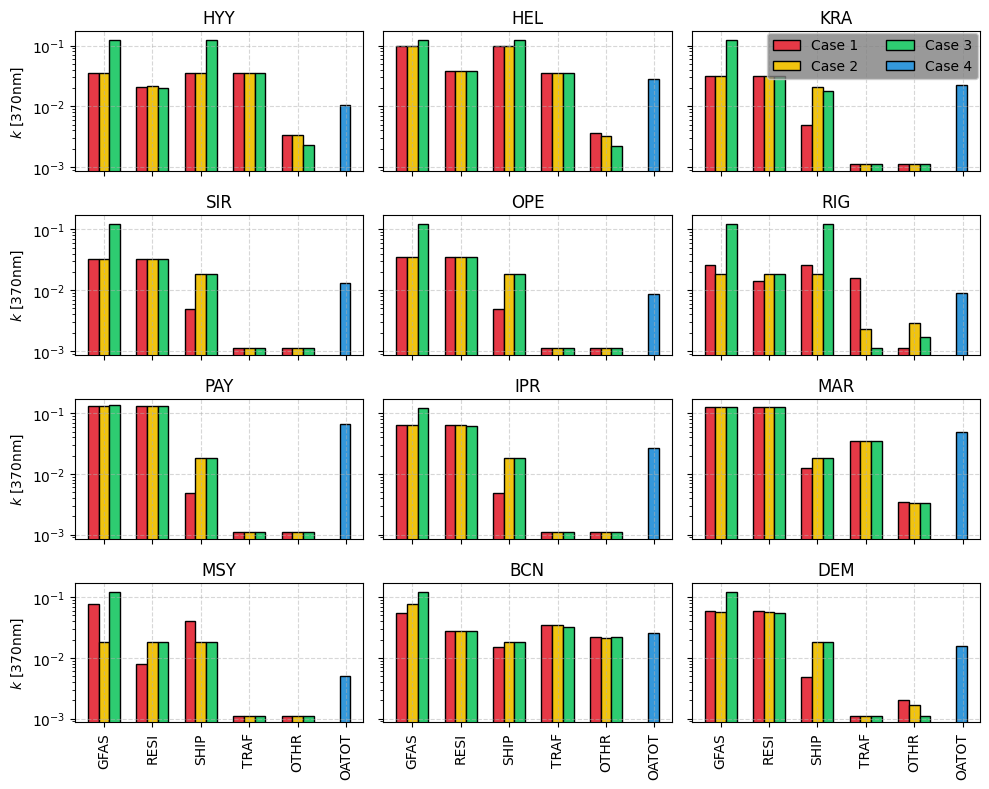

In [48]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 8), sharex=True, sharey=True)

# Aplanar el array de ejes para facilitar su iteración
axes = axes.flatten()

legend_labels = {'c1': 'Case 1', 'c2': 'Case 2', 'c3': 'Case 3', 'c4': 'Case 4'}
new_paleta_colores = ['#E63946',  # Rojo Carmesí
                      '#F1C40F',  # Amarillo Dorado
                      '#2ECC71',  # Verde Esmeralda
                      '#3498DB'] 
hatches = ['/', 'o', 'x', '-']

group_width = 1.5
num_bars = len(legend_labels)
bar_width = group_width / num_bars
group_spacing = 0.2  # Spacing between groups

#handles = [plt.Rectangle((0,0),1,1, color=new_paleta_colores[i], hatch=hatches[i]) for i in range(len(legend_labels))]
handles = [mpatches.Patch(facecolor=new_paleta_colores[i], edgecolor='black') for i in range(len(legend_labels))] #, hatch=hatches[i]
new_order = ['GFAS', 'RESI', 'SHIP', 'TRAF', 'OTHR', 'OATOT']

for i, (stn, df) in enumerate(data_nosoa.items()):
    ax = axes[i]

    # Iterate through the sources and plot bars
    for j, (orig_col, new_label) in enumerate(legend_labels.items()):
        if orig_col == 'c4':  # Assuming 'oa' is the identifier for the 'OA' bar
            # Center the 'OA' bar within its allocated space
            center_offset = (group_width - bar_width) 
            oa_positions = np.arange(len(df)) * (group_width + group_spacing) + .3*center_offset
            ax.bar(oa_positions, df[orig_col], width=bar_width, color=new_paleta_colores[j], edgecolor='black', label=new_label)
        else:
            positions = np.arange(len(df)) * (group_width + group_spacing) + j * bar_width
            ax.bar(positions, df[orig_col], width=bar_width, color=new_paleta_colores[j], edgecolor='black', label=new_label)

    ax.set_yscale('log')
    ax.title.set_text(stn)

    # Set x-ticks to align with the bar centers. Specifically adjust for 'TOTOA'
    tick_positions = np.arange(len(df)) * (group_width + group_spacing) + group_width / 2 - bar_width / 1
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(new_order, rotation=90)
    ax.grid(True, linestyle='--', alpha=0.5)

    if i % 3 == 0:
        ax.set_ylabel('$k$ [370nm]')

plt.tight_layout()
fig.legend(handles, list(legend_labels.values()), loc='upper right', bbox_to_anchor=(.99, .96), ncols=2, facecolor='gray')

os.makedirs('figures_paper/ri_optimized/no_soa', exist_ok=True)
fig.savefig(f"figures_paper/ri_optimized/no_soa/opt_by_stn.png", dpi=300, bbox_inches='tight')

plt.show()

In [49]:
combined_df = pd.DataFrame()

# Concatenamos los DataFrames del diccionario en un único DataFrame
for key, df in data_nosoa.items():
    # Agregamos una columna para identificar el grupo al que pertenecen los datos
    df['station'] = key
    # Reorganizamos las columnas para que 'Location' sea la primera
    df = df.reset_index().set_index(['station', 'RI_name'])
    combined_df = pd.concat([combined_df, df])


In [50]:
#see max and min for each category and case
def getminmax(case):
    if case=='c4':
        max_values = combined_df[case].max()
        min_values = combined_df[case].min()
        max_stn = combined_df[case].idxmax()
        min_stn = combined_df[case].idxmin()
        return f'case: {case}, max: {max_values} in {max_stn}, min: {min_values} in {min_stn}'
    else:
        max_values = combined_df[case].max()
        min_values = combined_df[case].min()
        max_stn = combined_df[case].idxmax()
        min_stn = combined_df[case].idxmin()
        return f'case: {case}, max: {max_values} in {max_stn}, min: {min_values} in {min_stn}'
    

In [51]:
getminmax('c1')

"case: c1, max: 0.1324 in ('PAY', 'gfas'), min: 0.0011 in ('KRA', 'traf')"

In [52]:
getminmax('c2')

"case: c2, max: 0.1323 in ('PAY', 'gfas'), min: 0.0011 in ('KRA', 'traf')"

In [53]:
getminmax('c3')

"case: c3, max: 0.1349 in ('PAY', 'gfas'), min: 0.0011 in ('KRA', 'traf')"

In [54]:
getminmax('c4')

"case: c4, max: 0.0675 in ('PAY', 'oa'), min: 0.0051 in ('MSY', 'oa')"

## RI by inventory

In [55]:
def get_rifromcrv42(stn, soacontr=False):
    #get the ri from crv4.2
    if soacontr:
        ri_w = pd.read_csv(f'ri_tables/monarch_best_weakly/RI_by_station/RI_SLSQP_{dict_of_names["acr_first"][stn]}_best.csv')
        ri_m = pd.read_csv(f'ri_tables/monarch_best_moderately/RI_by_station/RI_SLSQP_{dict_of_names["acr_first"][stn]}_best.csv')
        ri_s = pd.read_csv(f'ri_tables/monarch_best_strongly/RI_by_station/RI_SLSQP_{dict_of_names["acr_first"][stn]}_best.csv')
        #change ri_values name as w, m, s, and set the index as the ri_name
        ri_w.set_index('RI_name', inplace=True)
        ri_m.set_index('RI_name', inplace=True)
        ri_s.set_index('RI_name', inplace=True)
        ri_w.columns = ['w']
        ri_m.columns = ['m']
        ri_s.columns = ['s']
        #build as dict
        #ri = {'w': ri_w, 'm': ri_m, 's': ri_s}
        df = pd.concat([ri_w, ri_m, ri_s], axis=1)
        
    else:
        ri_w = pd.read_csv(f'ri_tables/monarch_best_weakly/RI_by_station/no_secondary/RI_SLSQP_{dict_of_names["acr_first"][stn]}_best.csv')
        ri_m = pd.read_csv(f'ri_tables/monarch_best_moderately/RI_by_station/no_secondary/RI_SLSQP_{dict_of_names["acr_first"][stn]}_best.csv')
        ri_s = pd.read_csv(f'ri_tables/monarch_best_strongly/RI_by_station/no_secondary/RI_SLSQP_{dict_of_names["acr_first"][stn]}_best.csv')
        #change ri_values name as w, m, s, and set the index as the ri_name
        ri_w.set_index('RI_name', inplace=True)
        ri_m.set_index('RI_name', inplace=True)
        ri_s.set_index('RI_name', inplace=True)
        ri_w.columns = ['w']
        ri_m.columns = ['m']
        ri_s.columns = ['s']
        #build as dict
        #ri = {'w': ri_w, 'm': ri_m, 's': ri_s}
        df = pd.concat([ri_w, ri_m, ri_s], axis=1)

    return df


def get_rifromhv3(stn, soacontr=False):
    #get the ri from hermes inventory
    if soacontr:
        ri_w = pd.read_csv(f'ri_tables/monarch_best_weakly/RI_by_emissioninventory/RI_SLSQP_{dict_of_names["acr_first"][stn]}_best.csv')
        ri_m = pd.read_csv(f'ri_tables/monarch_best_moderately/RI_by_emissioninventory/RI_SLSQP_{dict_of_names["acr_first"][stn]}_best.csv')
        ri_s = pd.read_csv(f'ri_tables/monarch_best_strongly/RI_by_emissioninventory/RI_SLSQP_{dict_of_names["acr_first"][stn]}_best.csv')
        #change ri_values name as w, m, s, and set the index as the ri_name
        ri_w.set_index('RI_name', inplace=True)
        ri_m.set_index('RI_name', inplace=True)
        ri_s.set_index('RI_name', inplace=True)
        ri_w.columns = ['w']
        ri_m.columns = ['m']
        ri_s.columns = ['s']
        #build as dict
        #ri = {'w': ri_w, 'm': ri_m, 's': ri_s}
        df = pd.concat([ri_w, ri_m, ri_s], axis=1)

    else:
        ri_w = pd.read_csv(f'ri_tables/monarch_best_weakly/RI_by_emissioninventory_nsoa/no_secondary/RI_SLSQP_{dict_of_names["acr_first"][stn]}_best.csv')
        ri_m = pd.read_csv(f'ri_tables/monarch_best_moderately/RI_by_emissioninventory_nsoa/no_secondary/RI_SLSQP_{dict_of_names["acr_first"][stn]}_best.csv')
        ri_s = pd.read_csv(f'ri_tables/monarch_best_strongly/RI_by_emissioninventory_nsoa/no_secondary/RI_SLSQP_{dict_of_names["acr_first"][stn]}_best.csv')
        #change ri_values name as w, m, s, and set the index as the ri_name
        ri_w.set_index('RI_name', inplace=True)
        ri_m.set_index('RI_name', inplace=True)
        ri_s.set_index('RI_name', inplace=True)
        ri_w.columns = ['w']
        ri_m.columns = ['m']
        ri_s.columns = ['s']
        #build as dict
        df = pd.concat([ri_w, ri_m, ri_s], axis=1)
        #ri = {'w': ri_w, 'm': ri_m, 's': ri_s}


    return df 


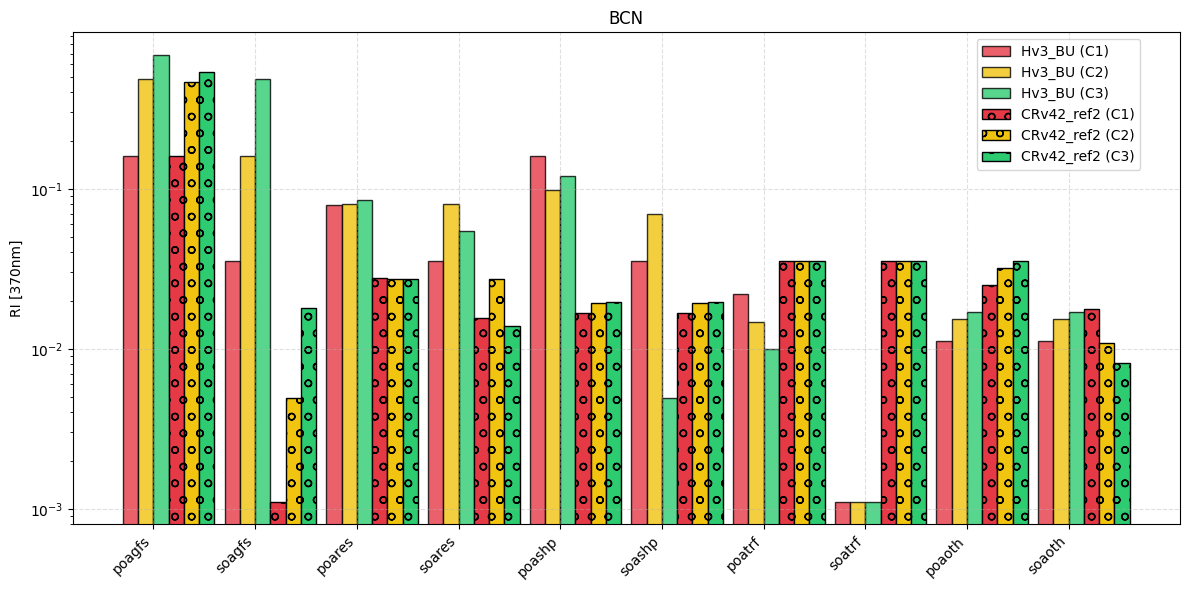

In [56]:
station= 'BCN'
soacontr = True
hermes = get_rifromhv3(station, soacontr=soacontr)
cams = get_rifromcrv42(station, soacontr=soacontr)

#plot the ri from hermes and cams in the same plot as bars
paleta_colores = ['#E63946',  # Rojo Carmesí
                  '#F1C40F',  # Amarillo Dorado
                  '#2ECC71']  # Verde Esmeralda

# Configuraciones iniciales
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.15  # Ancho de las barras
index = np.arange(len(hermes.index))  # Índices para cada grupo de barras
# Etiquetas para la leyenda
labels = ['C1', 'C2', 'C3']
# Crear las barras para 'w', 'm', y 's' de hermes usando la paleta de colores
for i, col in enumerate(['w', 'm', 's']):
    hermes_positions = [x + bar_width * i for x in index]
    if i< 3:
        ax.bar(hermes_positions, hermes[col], width=bar_width, label=f'Hv3_BU ({labels[i]})', color=paleta_colores[i], edgecolor='black', alpha=0.8)
    else:
        ax.bar(hermes_positions, hermes[col], width=bar_width, label=f'Hv3_BU ({labels[i]})', color=paleta_colores[i], edgecolor='black')

# Crear las barras para 'w', 'm', y 's' de cams, utilizando la misma paleta pero con hatches
offset = len(['w', 'm', 's']) * bar_width
for i, col in enumerate(['w', 'm', 's']):
    cams_positions = [x + offset + bar_width * i for x in index]
    ax.bar(cams_positions, cams[col], width=bar_width, label=f'CRv42_ref2 ({labels[i]})', color=paleta_colores[i], edgecolor='black', hatch='o')

# Configuración de las etiquetas y título
ax.set_ylabel('RI [370nm]')
ax.set_xticks([x + offset / 2 for x in index])
ax.set_xticklabels(hermes.index, rotation=45, ha='right')
ax.grid(True, linestyle='--', alpha=0.4)

# Escala logarítmica
ax.set_yscale('log')
#set title
ax.set_title(station)

# Añadir leyenda
ax.legend(loc='upper left', bbox_to_anchor=(.81, 1))

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
fig.savefig(f"figures_paper/ri_optimized/opt_hermes_cams_{station}_{'s' if soacontr else 'ns'}.png", dpi=300, bbox_inches='tight')
plt.show()

# Guardar la figura



## RI ALL FOR CRV42_RE2

In [11]:
data_w = pd.read_csv(f'ri_tables/monarch_best_weakly/RI_all/no_secondary/RI_SLSQP_best.csv')
data_m = pd.read_csv(f'ri_tables/monarch_best_moderately/RI_all/no_secondary/RI_SLSQP_best.csv')
data_s = pd.read_csv(f'ri_tables/monarch_best_strongly/RI_all/no_secondary/RI_SLSQP_best.csv')
data_oa = pd.read_csv(f'ri_tables/monarch_best_oa/RI_all/RI_SLSQP_best.csv')

data_w.set_index('RI_name', inplace=True)
data_m.set_index('RI_name', inplace=True)
data_s.set_index('RI_name', inplace=True)
data_oa.set_index('RI_name', inplace=True)

data_w.columns = ['w']
data_m.columns = ['m']
data_s.columns = ['s']
data_oa.columns = ['oa']

df_all = pd.concat([data_w, data_m, data_s, data_oa], axis=1)

In [12]:
df_all 

w       m       s      oa
RI_name                                
gfas     0.0646  0.0656  0.1219     NaN
resi     0.0411  0.0410  0.0397     NaN
ship     0.0646  0.0656  0.1081     NaN
traf     0.0011  0.0011  0.0011     NaN
othr     0.0011  0.0011  0.0011     NaN
oa          NaN     NaN     NaN  0.0187

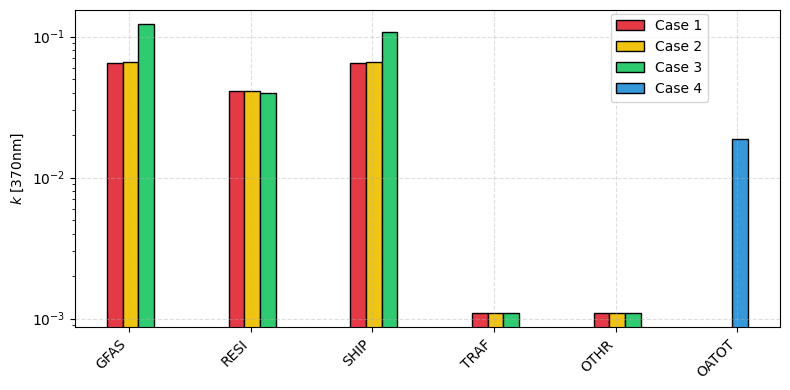

In [59]:
#  Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Bar width
bar_width = 0.8

# Rename columns
df_all.columns = ['c1', 'c2', 'c3', 'c4']

# Define legend labels
legend_labels = {'c1': 'Case 1', 'c2': 'Case 2', 'c3': 'Case 3', 'c4': 'Case 4'}

# Define a new color palette
new_color_palette = ['#E63946',  # Crimson Red
                     '#F1C40F',  # Golden Yellow
                     '#2ECC71',  # Emerald Green
                     '#3498DB']  # Blue

# Define the new order of categories
new_order = ['GFAS', 'RESI', 'SHIP', 'TRAF', 'OTHR', 'OATOT']

# Positions of the bars
index = df_all.index
n_groups = len(index)

# Adjust the x-ticks to be centered for each group of bars
# The adjustment will depend on the number of bars and groups
adjusted_bar_positions = np.arange(n_groups) * (n_groups + 0.2) + bar_width / 2 * (len(legend_labels) - 1)

# Create the bars for each category
for i, (orig_col, new_label) in enumerate(legend_labels.items()):
    if orig_col == 'c4':
        positions = adjusted_bar_positions + i * bar_width - bar_width * (len(legend_labels) - 1) /.81 + 0.7
    else:
        positions = adjusted_bar_positions + i * bar_width - bar_width * (len(legend_labels) - 1) / 3.3
    ax.bar(positions, df_all[orig_col], width=bar_width, color=new_color_palette[i], edgecolor='black', label=new_label)

# Add labels and title
ax.set_ylabel('$k$ [370nm]')
ax.set_xticks(adjusted_bar_positions)
ax.set_xticklabels(new_order, rotation=45, ha='right')
ax.grid(True, linestyle='--', alpha=0.4)

# Set the y-axis to logarithmic scale
ax.set_yscale('log')

# Add the legend
# Position the legend to the left of the plot
ax.legend(loc='center left', bbox_to_anchor=(0.75, 0.85))

# Adjust the layout and display the plot
plt.tight_layout()
fig.savefig(f"figures_paper/ri_optimized/opt_all.png", dpi=300, bbox_inches='tight')
plt.show()


# ABSORPTION

* scatterplot weakly
* scatterplot moderately
* scatterplot strongly
* scatterplot total oa 
* statistics to recommend between w, m, s
* explicit simulation BrC based on best k from above
* donut plot with inside mass modeled 

In [13]:
station_names = list(dict_of_names['acr_first'].keys())

In [14]:
def calculate_statistics(stn, points):
    # Calcula los valores para cada caso y la observación
    abs_mod_weakly = ut.calculate_absorption_cases(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                   SA=False, mode='by_station', points=points, model='monarch_best', case='weakly')
    abs_mod_moderately = ut.calculate_absorption_cases(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                       SA=False, mode='by_station', points=points, model='monarch_best', case='moderately')
    abs_mod_strongly = ut.calculate_absorption_cases(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                     SA=False, mode='by_station', points=points, model='monarch_best', case='strongly')
    abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)

    abs_tot_oa = ut.calculate_absorption4oa(dict_of_names['acr_first'][stn], best=True, points=points,\
                                             mass_mode='best', mode='by_station', model='monarch_best_oa')
    #hacer collocation de los datos para cada caso 
    #abs_observed, abs_mod_weakly = st.preproc_data_collocation(abs_observed, abs_mod_weakly, filled=False)
    #abs_observed, abs_mod_moderately = st.preproc_data_collocation(abs_observed, abs_mod_moderately, filled=False)
    #abs_observed, abs_mod_strongly = st.preproc_data_collocation(abs_observed, abs_mod_strongly, filled=False)
    #abs_observed, abs_tot = st.preproc_data_collocation(abs_observed, abs_tot_oa, filled=False)
    # Calcular las métricas
    corr_weakly = st.calculate_corr(abs_observed, abs_mod_weakly)
    corr_moderately = st.calculate_corr(abs_observed, abs_mod_moderately)
    corr_strongly = st.calculate_corr(abs_observed, abs_mod_strongly)
    corr_tot = st.calculate_corr(abs_observed, abs_tot_oa)
    fb_weakly = st.calculate_fb(abs_observed, abs_mod_weakly)
    fb_moderately = st.calculate_fb(abs_observed, abs_mod_moderately)
    fb_strongly = st.calculate_fb(abs_observed, abs_mod_strongly)
    fb_tot = st.calculate_fb(abs_observed, abs_tot_oa)
    fac2_weakly = st.calculate_fac2(abs_observed, abs_mod_weakly)
    fac2_moderately = st.calculate_fac2(abs_observed, abs_mod_moderately)
    fac2_strongly = st.calculate_fac2(abs_observed, abs_mod_strongly)
    fac2_tot = st.calculate_fac2(abs_observed, abs_tot_oa)

    # Crear un diccionario para almacenar los resultados para cada caso
    resultados = {
        'weakly': {
            'r': corr_weakly,
            'fb': fb_weakly,
            'fac2': fac2_weakly
        },
        'moderately': {
            'r': corr_moderately,
            'fb': fb_moderately,
            'fac2': fac2_moderately
        },
        'strongly': {
            'r': corr_strongly,
            'fb': fb_strongly,
            'fac2': fac2_strongly
        },
        'total': {
            'r': corr_tot,
            'fb': fb_tot,
            'fac2': fac2_tot

        }
    }

    return resultados

In [15]:
def calculate_statistics_nosoa(stn, points, mode='by_station'):
    # Calcula los valores para cada caso y la observación
    abs_mod_weakly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                   SA=False, mode=mode, points=points, model='monarch_best', case='weakly')
    abs_mod_moderately = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                       SA=False, mode=mode, points=points, model='monarch_best', case='moderately')
    abs_mod_strongly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                     SA=False, mode=mode, points=points, model='monarch_best', case='strongly')
    abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)

    abs_tot_oa = ut.calculate_absorption4oa_ns(dict_of_names['acr_first'][stn], best=True, points=points,\
                                             mass_mode='best', mode=mode, model='monarch_best_oa')
    #hacer collocation de los datos para cada caso 
    #abs_observed, abs_mod_weakly = st.preproc_data_collocation(abs_observed, abs_mod_weakly, filled=False)
    #abs_observed, abs_mod_moderately = st.preproc_data_collocation(abs_observed, abs_mod_moderately, filled=False)
    #abs_observed, abs_mod_strongly = st.preproc_data_collocation(abs_observed, abs_mod_strongly, filled=False)
    #abs_observed, abs_tot = st.preproc_data_collocation(abs_observed, abs_tot_oa, filled=False)
    # Calcular las métricas
    corr_weakly = st.calculate_corr(abs_observed, abs_mod_weakly)
    corr_moderately = st.calculate_corr(abs_observed, abs_mod_moderately)
    corr_strongly = st.calculate_corr(abs_observed, abs_mod_strongly)
    corr_tot = st.calculate_corr(abs_observed, abs_tot_oa)
    fb_weakly = st.calculate_fb(abs_observed, abs_mod_weakly)
    fb_moderately = st.calculate_fb(abs_observed, abs_mod_moderately)
    fb_strongly = st.calculate_fb(abs_observed, abs_mod_strongly)
    fb_tot = st.calculate_fb(abs_observed, abs_tot_oa)
    fac2_weakly = st.calculate_fac2(abs_observed, abs_mod_weakly)
    fac2_moderately = st.calculate_fac2(abs_observed, abs_mod_moderately)
    fac2_strongly = st.calculate_fac2(abs_observed, abs_mod_strongly)
    fac2_tot = st.calculate_fac2(abs_observed, abs_tot_oa)

    # Crear un diccionario para almacenar los resultados para cada caso
    resultados = {
        'weakly': {
            'r': corr_weakly,
            'fb': fb_weakly,
            'fac2': fac2_weakly
        },
        'moderately': {
            'r': corr_moderately,
            'fb': fb_moderately,
            'fac2': fac2_moderately
        },
        'strongly': {
            'r': corr_strongly,
            'fb': fb_strongly,
            'fac2': fac2_strongly
        },
        'total': {
            'r': corr_tot,
            'fb': fb_tot,
            'fac2': fac2_tot

        }
    }

    return resultados

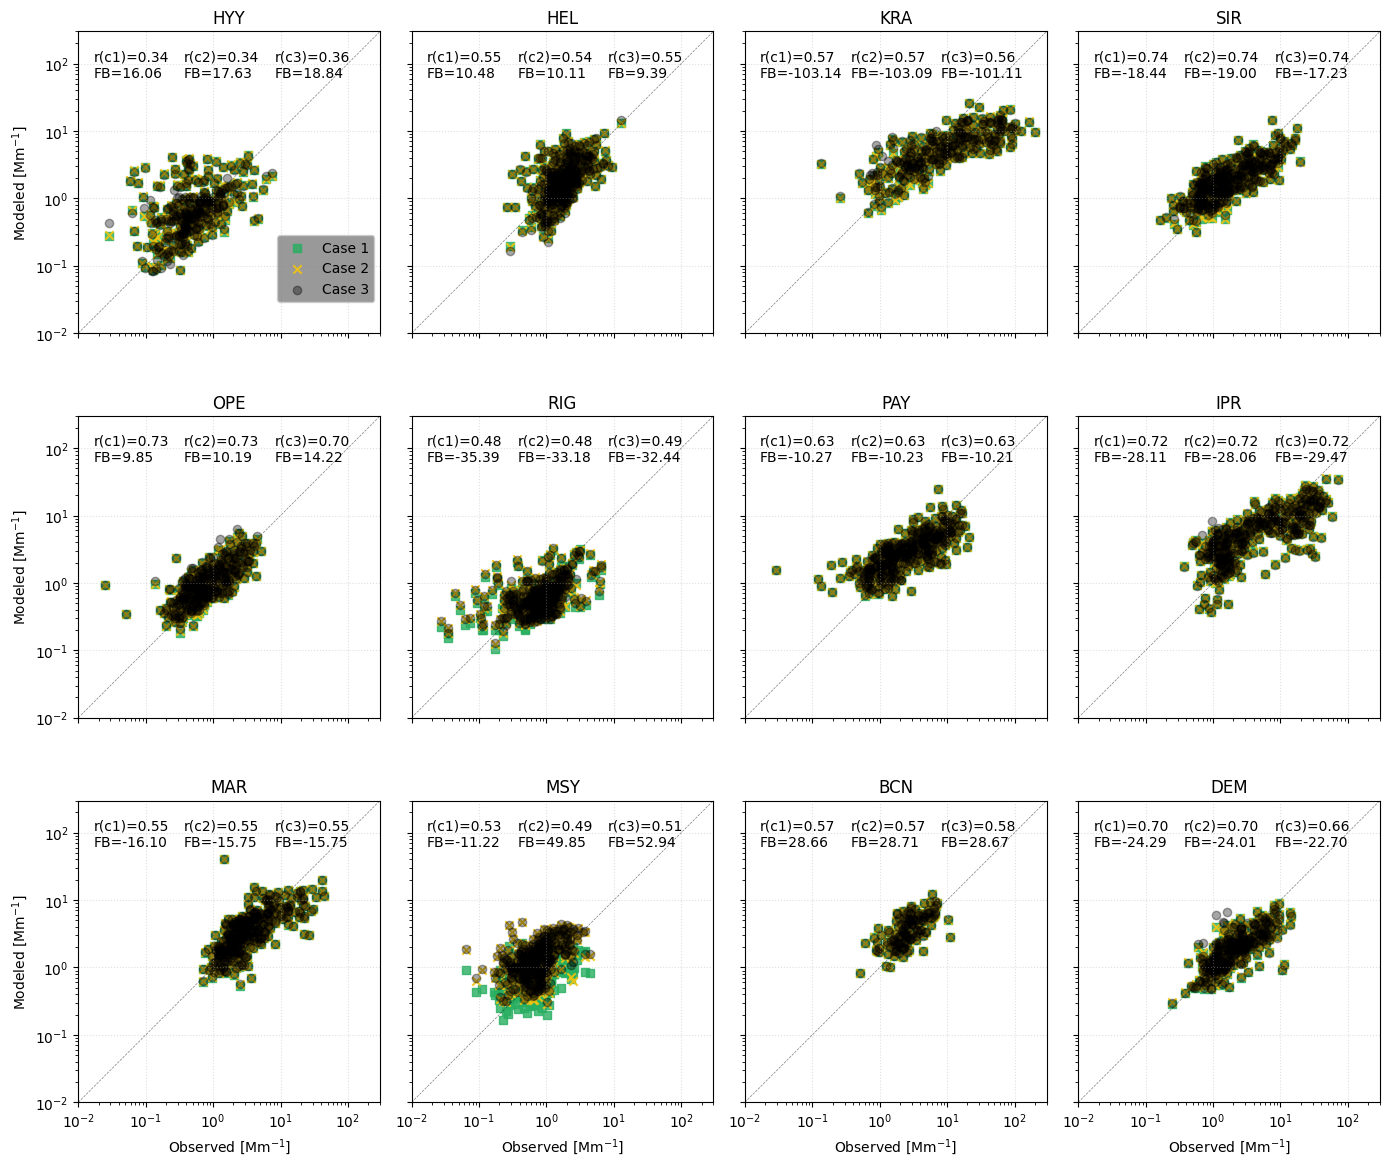

In [63]:
def plot_scatter_log_nosoa(stations, points='best'):
    #plot in one figure
    fig, axs = plt.subplots(3, 4, figsize=(14, 14), sharex=True, sharey=True)
    #reduce space between subplots
    fig.subplots_adjust(hspace=-0.45, wspace=0.12)
    #flatten the axs
    axs = axs.flatten()

    for i, stn in enumerate(stations):
        # Calcula los valores para cada caso y la observación
        abs_mod_weakly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                       SA=False, mode='by_station', points=points, model='monarch_best', case='weakly')
        abs_mod_moderately = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                           SA=False, mode='by_station', points=points, model='monarch_best', case='moderately')
        abs_mod_strongly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                         SA=False, mode='by_station', points=points, model='monarch_best', case='strongly')
        abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)

        if stn =='MAR':
            abs_mod_weakly.to_csv('abs_mod_weakly_MAR.csv')
            abs_observed.to_csv('abs_observed_MAR.csv')


        axs[i].scatter(abs_observed, abs_mod_weakly, color='#27AE60', label='Case 1', alpha=0.8, marker='s')
        axs[i].scatter(abs_observed, abs_mod_moderately, color='#F1C40F', label='Case 2', alpha=0.9, marker='x', linewidth=1.5)
        axs[i].scatter(abs_observed, abs_mod_strongly, color='black', label='Case 3', alpha=0.35)

        axs[i].minorticks_on()
        axs[i].set_xlim([0.01, 300])
        axs[i].set_ylim([0.01,300])

        #plot a diagonal line
        axs[i].plot([0.01, 300], [0.01, 300], linestyle='--', color='black', alpha=0.5, linewidth=0.5)
        #set title
        axs[i].set_title(stn)
        #set axis labels just in the bottom and left subplots
        if i in [8, 9, 10, 11]:
            axs[i].set_xlabel('Observed [Mm$^{-1}$]')
        if i in [0, 4, 8]:
            axs[i].set_ylabel('Modeled [Mm$^{-1}$]')
        #add annotation with correlation coefficient, and mean bias for each case/station using the function calculate_statistics
        #calculate statistics
        results = calculate_statistics_nosoa(stn, points)
        #add annotation
        axs[i].annotate(f"r(c1)={results['weakly']['r']:.2f}\nFB={results['weakly']['fb']:.2f}", 
                        xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
        axs[i].annotate(f"r(c2)={results['moderately']['r']:.2f}\nFB={results['moderately']['fb']:.2f}", 
                        xy=(0.35, 0.85), xycoords='axes fraction', fontsize=10)
        axs[i].annotate(f"r(c3)={results['strongly']['r']:.2f}\nFB={results['strongly']['fb']:.2f}", 
                        xy=(0.65, 0.85), xycoords='axes fraction', fontsize=10)

        #set log scale
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')
        #set grid dotted
        axs[i].grid(True, linestyle=':', alpha=0.4)
        axs[i].set_aspect('equal', adjustable='box')
        #add legend in bottom of only first subplot
        axs[0].legend(loc='lower center', bbox_to_anchor=(0.82, 0.08), ncol=1, facecolor='gray')
    # Ajustar el layout para evitar la superposición
    plt.tight_layout()

    os.makedirs('figures_paper/scatter_opt/', exist_ok=True)
    #savefig 
    plt.savefig(f"figures_paper/scatter_opt/scatter_opt_3cases_{points}_nosoa.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_scatter_log_nosoa(station_names[::-1], points='complete')

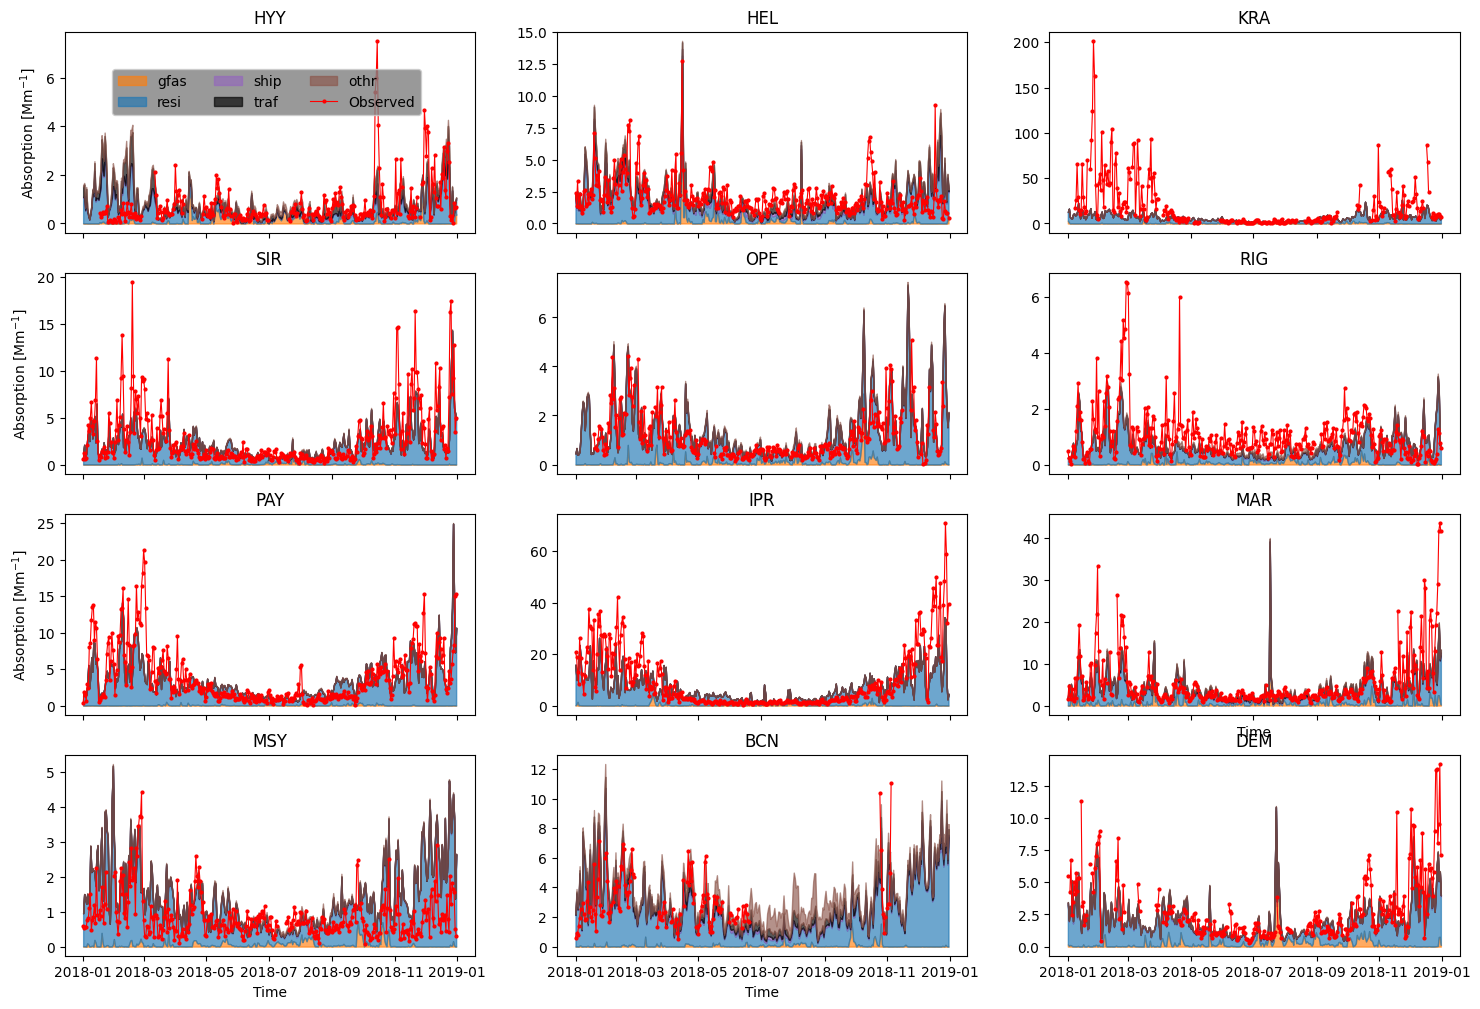

In [64]:
def plot_ts_nosoa(stations, points='best'):
    #plot in one figure
    fig, axs = plt.subplots(4, 3, figsize=(18, 12), sharex=True, sharey=False)
    axs = axs.flatten() 
    #reduce space between subplots
    #fig.subplots_adjust(hspace=0.45, wspace=0.12)
    colores = {
        'resi': '#1f77b4',  # Azul claro
        'gfas': '#ff7f0e',  # Naranja
        'traf': '#000000',  # Negro mate
        'ship': '#9467bd',  # morado
        'othr': '#8c564b',   # Marrón
    }
    #flatten the axs
    axs = axs.flatten()
    for i, stn in enumerate(stations):
        # Calcula los valores para cada caso y la observación
        #abs_mod_weakly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
        #                                               SA=False, mode='by_station', points=points, model='monarch_best', case='weakly')
        #abs_mod_moderately = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
        #                                                   SA=False, mode='by_station', points=points, model='monarch_best', case='moderately')
        abs_mod_strongly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                         SA=True, mode='by_station', points=points, model='monarch_best', case='strongly')
        abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)

        #make an area plot of strongly
        abs_mod_strongly['acumulado'] = 0

        # Iterar a través de cada categoría que deseas graficar
        for col in abs_mod_strongly.columns[:-1]:  # Excluye la columna 'acumulado' que agregaste
            # Sumar la columna actual a la columna 'acumulado'
            abs_mod_strongly['acumulado'] += abs_mod_strongly[col]
           
            # Graficar la columna 'acumulado'
            axs[i].fill_between(abs_mod_strongly.index, abs_mod_strongly['acumulado'], abs_mod_strongly['acumulado'] - abs_mod_strongly[col], 
                            alpha=0.65, color=colores[col], label=col)

        # Graficar la observación
        axs[i].plot(abs_observed.index, abs_observed, color='red', label='Observed', linewidth=.8, marker='o', markersize=2)

        #set title
        axs[i].set_title(stn)
        #set axis labels just in the bottom and left subplots
        if i in [8, 9, 10]:
            axs[i].set_xlabel('Time')
        if i in [0, 3, 6]:
            axs[i].set_ylabel('Absorption [Mm$^{-1}$]')
    #legend
    axs[0].legend(loc='upper left', bbox_to_anchor=(0.1, 0.85), ncol=3, facecolor='gray')

plot_ts_nosoa(station_names[::-1], points='complete')

AttributeError: module 'modules.utils' has no attribute 'calculate_absorption4oa'

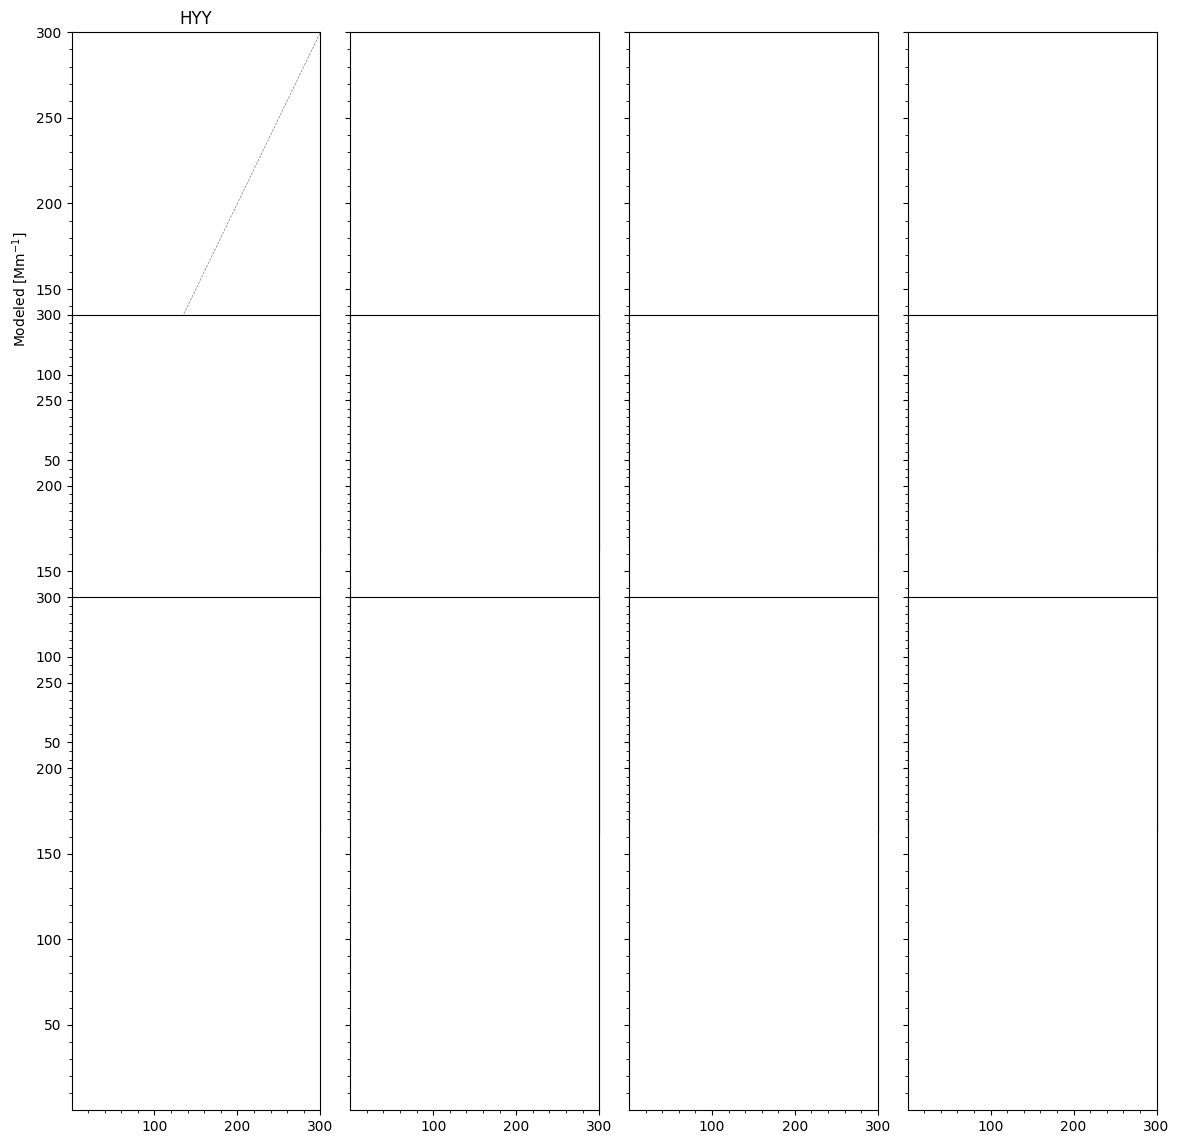

In [65]:
def plot_scatter_log(stations, points='best'):
    #plot in one figure
    fig, axs = plt.subplots(3, 4, figsize=(14, 14), sharex=True, sharey=True)
    #reduce space between subplots
    fig.subplots_adjust(hspace=-0.45, wspace=0.12)
    #flatten the axs
    axs = axs.flatten()

    for i, stn in enumerate(stations):
        # Calcula los valores para cada caso y la observación
        abs_mod_weakly = ut.calculate_absorption_cases(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                       SA=False, mode='by_station', points=points, model='monarch_best', case='weakly')
        abs_mod_moderately = ut.calculate_absorption_cases(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                           SA=False, mode='by_station', points=points, model='monarch_best', case='moderately')
        abs_mod_strongly = ut.calculate_absorption_cases(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                         SA=False, mode='by_station', points=points, model='monarch_best', case='strongly')
        abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)

        if stn =='MAR':
            abs_mod_weakly.to_csv('abs_mod_weakly_MAR.csv')
            abs_observed.to_csv('abs_observed_MAR.csv')


        axs[i].scatter(abs_observed, abs_mod_weakly, color='#27AE60', label='Case 1', alpha=0.8, marker='s')
        axs[i].scatter(abs_observed, abs_mod_moderately, color='#F1C40F', label='Case 2', alpha=0.9, marker='x', linewidth=1.5)
        axs[i].scatter(abs_observed, abs_mod_strongly, color='black', label='Case 3', alpha=0.35)

        axs[i].minorticks_on()
        axs[i].set_xlim([0.01, 300])
        axs[i].set_ylim([0.01,300])

        #plot a diagonal line
        axs[i].plot([0.01, 300], [0.01, 300], linestyle='--', color='black', alpha=0.5, linewidth=0.5)
        #set title
        axs[i].set_title(stn)
        #set axis labels just in the bottom and left subplots
        if i in [8, 9, 10, 11]:
            axs[i].set_xlabel('Observed [Mm$^{-1}$]')
        if i in [0, 4, 8]:
            axs[i].set_ylabel('Modeled [Mm$^{-1}$]')
        #add annotation with correlation coefficient, and mean bias for each case/station using the function calculate_statistics
        #calculate statistics
        results = calculate_statistics(stn, points)
        #add annotation
        axs[i].annotate(f"r(c1)={results['weakly']['r']:.2f}\nFB={results['weakly']['fb']:.2f}", 
                        xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
        axs[i].annotate(f"r(c2)={results['moderately']['r']:.2f}\nFB={results['moderately']['fb']:.2f}", 
                        xy=(0.35, 0.85), xycoords='axes fraction', fontsize=10)
        axs[i].annotate(f"r(c3)={results['strongly']['r']:.2f}\nFB={results['strongly']['fb']:.2f}", 
                        xy=(0.65, 0.85), xycoords='axes fraction', fontsize=10)

        #set log scale
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')
        #set grid dotted
        axs[i].grid(True, linestyle=':', alpha=0.4)
        axs[i].set_aspect('equal', adjustable='box')
        #add legend in bottom of only first subplot
        axs[0].legend(loc='lower center', bbox_to_anchor=(0.82, 0.08), ncol=1, facecolor='gray')
    # Ajustar el layout para evitar la superposición
    plt.tight_layout()

    os.makedirs('figures_paper/scatter_opt/', exist_ok=True)
    #savefig 
    plt.savefig(f"figures_paper/scatter_opt/scatter_opt_3cases_{points}.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_scatter_log(station_names[::-1], points='complete')

In [66]:
# Crear un diccionario de estadistico para cada estacion, con weakly, moderately, strongly y total, y r, fb y fac2
def total_stats(stations):
    stats = {}
    for stn in stations:
        stats[stn] = calculate_statistics(stn, points='complete')
    return stats
    

In [67]:
data = total_stats(station_names)


AttributeError: module 'modules.utils' has no attribute 'calculate_absorption4oa'

AttributeError: module 'modules.utils' has no attribute 'calculate_absorption4oa'

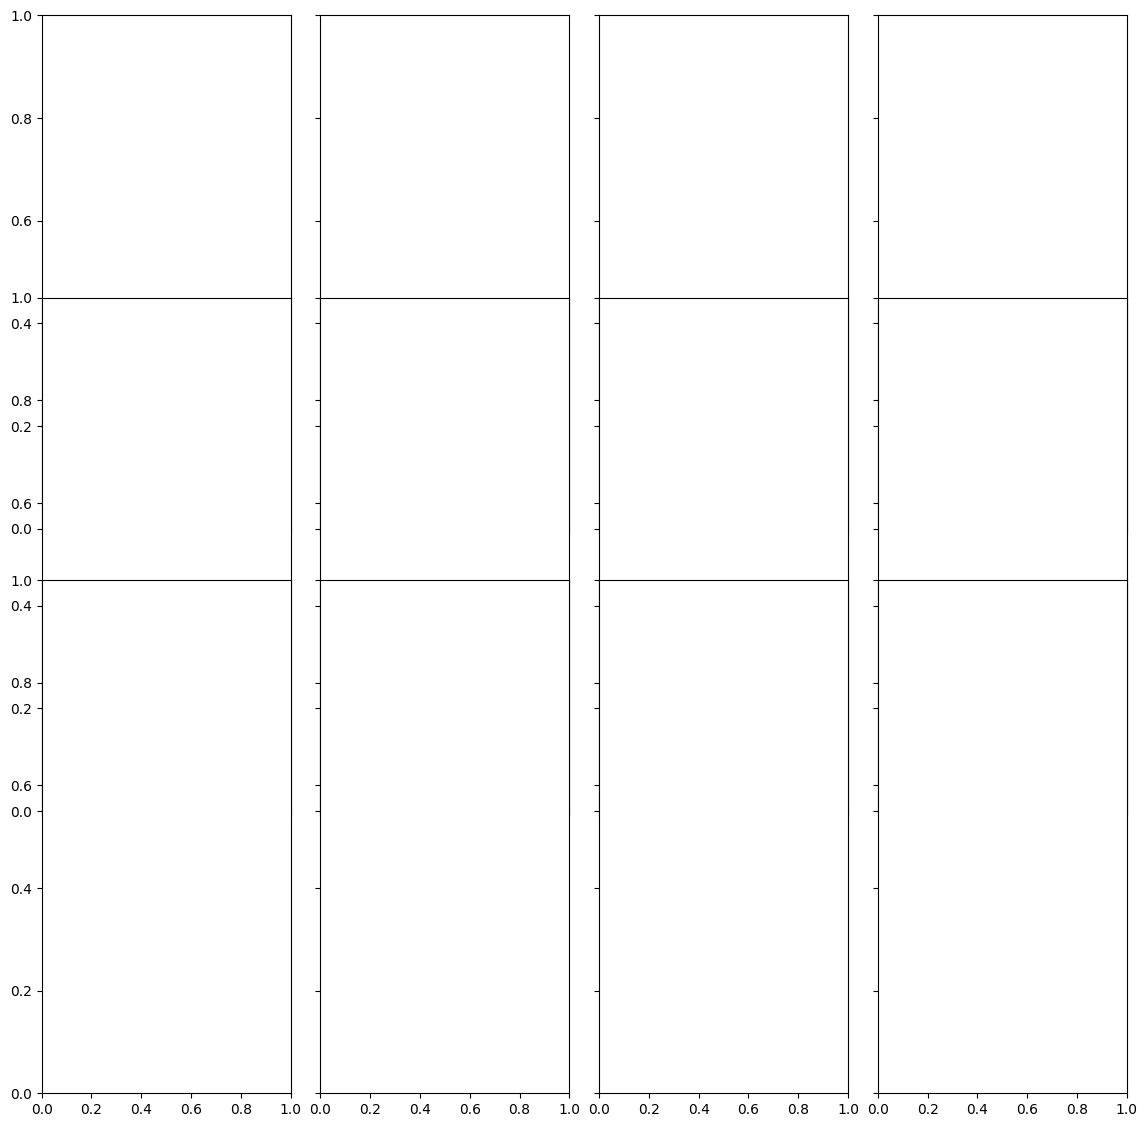

In [68]:
def plot_scatter_log_tot(stations, points):
    #plot in one figure
    fig, axs = plt.subplots(3, 4, figsize=(14, 14), sharex=True, sharey=True)
    #reduce space between subplots
    fig.subplots_adjust(hspace=-0.45, wspace=0.12)
    #flatten the axs
    axs = axs.flatten()

    for i, stn in enumerate(stations):
        # Calcula los valores para cada caso y la observación
        abs_mod_weakly = ut.calculate_absorption_cases(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                       SA=False, mode='by_station', points=points, model='monarch_best', case='strongly')
    
        abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)

        abs_oa = ut.calculate_absorption4oa(dict_of_names['acr_first'][stn], best=True, points=points,\
                                             mass_mode='best', mode='by_station', model='monarch_best_oa')

        axs[i].scatter(abs_observed, abs_mod_weakly, color='#27AE60', label='Case 3', alpha=0.8, edgecolor='black', marker='s')
        axs[i].scatter(abs_observed, abs_oa, color='#3498DB', label='Case 4', edgecolor='white', alpha=0.5)

        axs[i].minorticks_on()
        axs[i].set_xlim([0.01, 300])
        axs[i].set_ylim([0.01,300])
        #set title
        axs[i].set_title(stn)

        #plot a diagonal line
        axs[i].plot([0.01, 300], [0.01, 300], linestyle='--', color='black', alpha=0.5, linewidth=0.5)
        #set axis labels just in the bottom and left subplots
        if i in [8, 9, 10, 11]:
            axs[i].set_xlabel('Observed [Mm$^{-1}$]')
        if i in [0, 4, 8]:
            axs[i].set_ylabel('Modeled [Mm$^{-1}$]')
        #add annotation with correlation coefficient, and mean bias for each case/station using the function calculate_statistics
        #calculate statistics
        results = calculate_statistics(stn, points)
        #add annotation
        axs[i].annotate(f"r(c3)={results['strongly']['r']:.2f}\nFB={results['strongly']['fb']:.2f}", 
                        xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)

        # Suponiendo que tienes los resultados para el total, añadir la anotación para tot
        axs[i].annotate(f"r(c4)={results['total']['r']:.2f}\nFB={results['total']['fb']:.2f}", 
                        xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10)

        #set log scale
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')
        #set grid dotted
        axs[i].grid(True, linestyle=':', alpha=0.4)
        axs[i].set_aspect('equal', adjustable='box')
        #add legend in bottom of only first subplot
        axs[0].legend(loc='lower center', bbox_to_anchor=(0.82, 0.08), ncol=1, facecolor='gray')
    # Ajustar el layout para evitar la superposición
    plt.tight_layout()

    os.makedirs('figures_paper/scatter_opt/', exist_ok=True)
    #savefig 
    plt.savefig(f"figures_paper/scatter_opt/scatter_tot_best_{points}_strongly.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    

plot_scatter_log_tot(station_names[::-1], points='complete')

## Timeseries from absroption

In [16]:
def get_mod_abs(stn, points, case='strongly', soa=False):
    df = ut.calculate_absorption_cases(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                       SA=True, mode='by_station', points=points, model='monarch_best', case=case)
    if soa:
        df['soa'] = df['soares'] + df['soatrf'] + df['soashp'] + df['soagfs'] + df['soaoth'] 
        df = df.drop(columns=['soares', 'soatrf', 'soashp', 'soagfs', 'soaoth'])

        return df
    else:
        df['oares'] = df['poares'] + df['soares']
        df['oatrf'] = df['poatrf'] + df['soatrf']
        df['oashp'] = df['poashp'] + df['soashp']
        df['oagfs'] = df['poagfs'] + df['soagfs']
        df['oaoth'] = df['poaoth'] + df['soaoth']

        columnas_a_eliminar = ['poares', 'soares', 'poatrf', 'soatrf', 'poashp', 'soashp', 'poagfs', 'soagfs', 'poaoth', 'soaoth']
        df = df.drop(columns=columnas_a_eliminar)
        return df

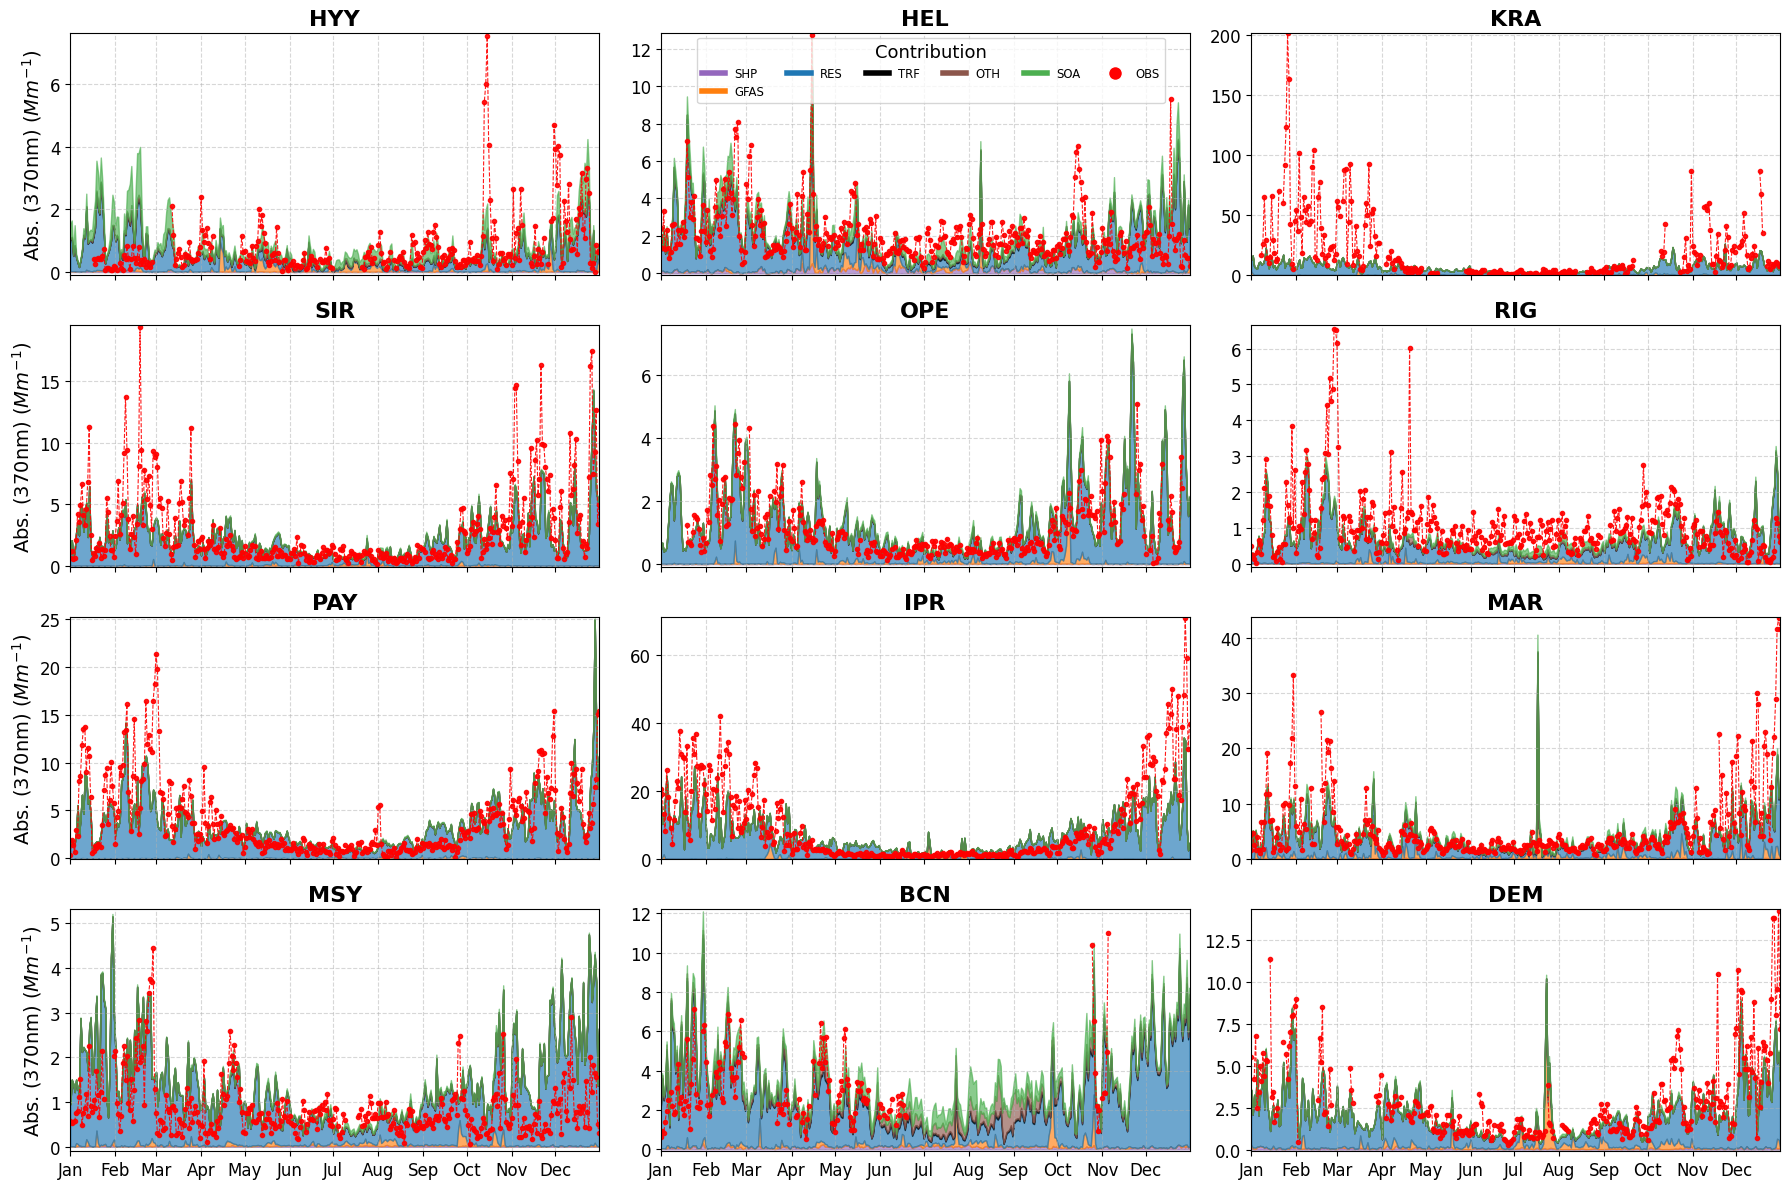

In [70]:

def plot_absorption_contributions_panel_wsoa(stations, m_o_y=True):
    fig, axs = plt.subplots(4, 3, figsize=(18, 12), sharex=True, sharey=False)
    axs = axs.flatten()  # Convertir la matriz de ejes en una lista para facilitar la iteración

    # Definir colores y etiquetas personalizadas fuera del bucle
    colores = {
        'oares': '#1f77b4',  # Azul claro
        'oagfs': '#ff7f0e',  # Naranja
        'oatrf': '#000000',  # Negro mate
        'oashp': '#9467bd',  # morado
        'oaoth': '#8c564b',   # Marrón
        'soa': '#4CAF50',
        'poares': '#1f77b4',  # Azul claro
        'poagfs': '#ff7f0e',  # Naranja
        'poatrf': '#000000',  # Negro mate
        'poashp': '#9467bd',  # morado
        'poaoth': '#8c564b',   # Marrón
    }
    
    etiquetas_personalizadas = {
        'oagfs': 'GFAS',
        'oares': 'RES',
        'oatrf': 'TRF',
        'oashp': 'SHP',
        'oaoth': 'OTH',
        'soa': 'SOA',
        'poagfs': 'GFAS',
        'poares': 'RES',
        'poatrf': 'TRF',
        'poashp': 'SHP',
        'poaoth': 'OTH',
    }

    for idx, stn in enumerate(stations):
        ax = axs[idx]
        # Obtener datos de observaciones y modelo
        if m_o_y:
            data_obs_i = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)
            data_mod_sa_i = get_mod_abs(stn, points='complete', case='strongly', soa=True)

            #collocation data
            data_obs_, data_mod_sa_ = st.preproc_data_collocation(data_obs_i, data_mod_sa_i, filled=True)
            #Resample to monthly mean
            data_obs = data_obs_.resample('MS').mean()
            df = data_mod_sa_.resample('MS').mean()
            #data_obs, df = data_obs.align(df, join='outer')
            #df.to_csv(f'data_mod_sa_{stn}.csv')
            #data_obs.to_csv(f'data_obs_{stn}.csv')

        else:
            data_obs = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)
            df = get_mod_abs(stn, points='complete', case='strongly', soa=True)

        # Ordenar las categorías
        orden_categorias = ['poashp', 'poagfs', 'poares', 'poatrf', 'poaoth', 'soa']

        df = df[orden_categorias]
        # Crear el gráfico de áreas en el eje correspondiente
        #df.plot.area(ax=ax, stacked=True, alpha=0.25, color=[colores.get(col, 'gray') for col in df.columns], legend=False)
        df['acumulado'] = 0

        # Iterar a través de cada categoría que deseas graficar
        for col in df.columns[:-1]:  # Excluye la columna 'acumulado' que agregaste
            # Sumar la columna actual a la columna 'acumulado'
            df['acumulado'] += df[col]
           
            # Graficar la columna 'acumulado'
            ax.fill_between(df.index, df['acumulado'], df['acumulado'] - df[col], 
                            color=colores.get(col, 'gray'), alpha=0.65)

        # Eliminar la columna 'acumulado' 
        df = df.drop(columns=['acumulado'])
        # Añadir puntos de observación
        color_obs = 'red'
        ax.plot(data_obs, color=color_obs, marker='o', linestyle='--', ms=3 if m_o_y==False else 6, lw=0.8, alpha=0.9)
        
        # Añadir títulos y etiquetas
        ax.set_title(stn, fontsize=16, fontweight='bold')
        #ax.set_xlabel('months', fontsize=14)
        #ax.set_ylabel(r'OA ($\mu g/m^3$)', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        if idx in [0, 3, 6, 9]:
            ax.set_title(stn, fontsize=16, fontweight='bold')
            ax.set_ylabel(r'Abs. (370nm) ($Mm^{-1}$)', fontsize=14)
        # Añadir rejilla
        ax.grid(True, linestyle='--', alpha=0.5)
        

        max_df = df.sum(axis=1).values.max()
        max_data_obs = data_obs.max().values[0]
        
        max_val = max(max_df, max_data_obs)
        ax.set_ylim(-0.1, max_val + 0.1)

    # Configurar el formato de las etiquetas del eje x para que muestren las iniciales de los meses
    #ax.xaxis.set_major_locator(mdates.MonthLocator())  # Colocar un tick por cada mes
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # %b da el nombre abreviado del mes en inglés
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Coloca un tick cada 1 mes
    #ax.set_xlim(df.index.min(), df.index.max())
    #set ticks as first letter of the month
        if m_o_y:
            if not isinstance(df.index, pd.DatetimeIndex):
                df.index = pd.to_datetime(df.index)

            # Establecer los xticks y xticklabels
            ax.set_xticks(df.index)
            ax.set_xticklabels([cal.month_abbr[i.month][0] for i in df.index])
        else:
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            ax.set_xlim(df.index.min(), df.index.max())
    
    # Rotar las etiquetas para que se muestren mejor
    for label in ax.get_xticklabels():
        label.set_rotation(0)  # Rotar las etiquetas a 0 grados (horizontal)
        label.set_horizontalalignment('center')

    # Ajustar espaciado entre subgráficos
    plt.tight_layout()

    # Crear una sola leyenda para todos los subgráficos
    etiquetas_con_colores = [
        (etiquetas_personalizadas.get(col, col), colores.get(col, None))
        for col in df.columns
    ]
    
    handles = [plt.Line2D([0], [0], color=color, lw=4) for etiqueta, color in etiquetas_con_colores]
    labels = [etiqueta for etiqueta, _ in etiquetas_con_colores]
    
    color_obs = 'red'  # Definir color de observaciones
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_obs, markersize=10))
    labels.append('OBS')

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.20, 0.95) if m_o_y else (0.52, 0.968),\
               fontsize='small', title='Contribution', title_fontsize='13', ncol=3 if m_o_y else 6)
    #bbox_to_anchor=(0.20, 0.95)
    # Crear carpeta para guardar figuras
    os.makedirs("figures_paper/ts_absorption/", exist_ok=True)
    # Guardar figura
    plt.savefig(f"figures_paper/ts_absorption/abs_contributions_panel_wsoa_dayli_collocated{'m' if m_o_y==True else 'y'}.png", dpi=300, bbox_inches='tight')
    # Mostrar el gráfico
    plt.show()


# Llama a la función con la lista de nombres de las estaciones
stations = list(dict_of_names['stations'].values())
#invertir el orden
stations = stations[::-1]
plot_absorption_contributions_panel_wsoa(stations, m_o_y=False)

## Abs Brc strongly, photobleached BrC moderetaly


In [17]:
from modules import conc2abs as ca
from modules import constants 

In [18]:
def calculate_statistics_4brc(stn, ri_brc_strng, ri_brc_blchd, factor=10):
    model = dr.get_explct4brcmass(dict_of_names['acr_first'][stn], remove_negatives=True)
    model_abs = ca.get_absorption4brc(model, WAVELENGTH=constants.WAVELENGTH,\
                                        REL_HUM=constants.RELATIVE_HUMIDITY,\
                                        ri_brc_strng=ri_brc_strng, ri_brc_blchd=ri_brc_blchd, SA=False)*factor
    obs = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)
    #hacer collocation de los datos para cada caso 
    obs, model_abs = st.preproc_data_collocation(obs, model_abs, filled=False)
    # Calcular las métricas
    corr = st.calculate_corr(obs, model_abs)
    fb = st.calculate_fb(obs, model_abs)
    fac2 = st.calculate_fac2(obs, model_abs)

    # Crear un diccionario para almacenar los resultados para cada caso
    resultados = {
        'r': corr,
        'fb': fb,
        'fac2': fac2
    }
    return resultados


In [19]:
df_all 
#rename columns c1: w, c2: m, c3: s
df_all.columns = ['w', 'm', 's', 'c4']

In [20]:
#calculate for all stations
results_brc = {}
for stn in station_names[::-1]:
    results_brc[stn] = calculate_statistics_4brc(stn, df_all.loc['gfas']['s'], df_all.loc['gfas']['m'], factor=5)


In [21]:
results_brc 

{'HYY': {'r': 0.29, 'fb': 16.6, 'fac2': 57.24},
 'HEL': {'r': 0.52, 'fb': -22.8, 'fac2': 54.79},
 'KRA': {'r': 0.54, 'fb': -84.58, 'fac2': 51.8},
 'SIR': {'r': 0.7, 'fb': 1.97, 'fac2': 61.71},
 'OPE': {'r': 0.7, 'fb': 15.06, 'fac2': 78.64},
 'RIG': {'r': 0.49, 'fb': 8.18, 'fac2': 69.27},
 'PAY': {'r': 0.62, 'fb': -95.38, 'fac2': 44.66},
 'IPR': {'r': 0.65, 'fb': -78.01, 'fac2': 54.12},
 'MAR': {'r': 0.21, 'fb': -71.58, 'fac2': 42.78},
 'MSY': {'r': 0.5, 'fb': 84.73, 'fac2': 35.33},
 'BCN': {'r': 0.5, 'fb': 12.8, 'fac2': 79.41},
 'DEM': {'r': 0.5, 'fb': -56.32, 'fac2': 62.9}}

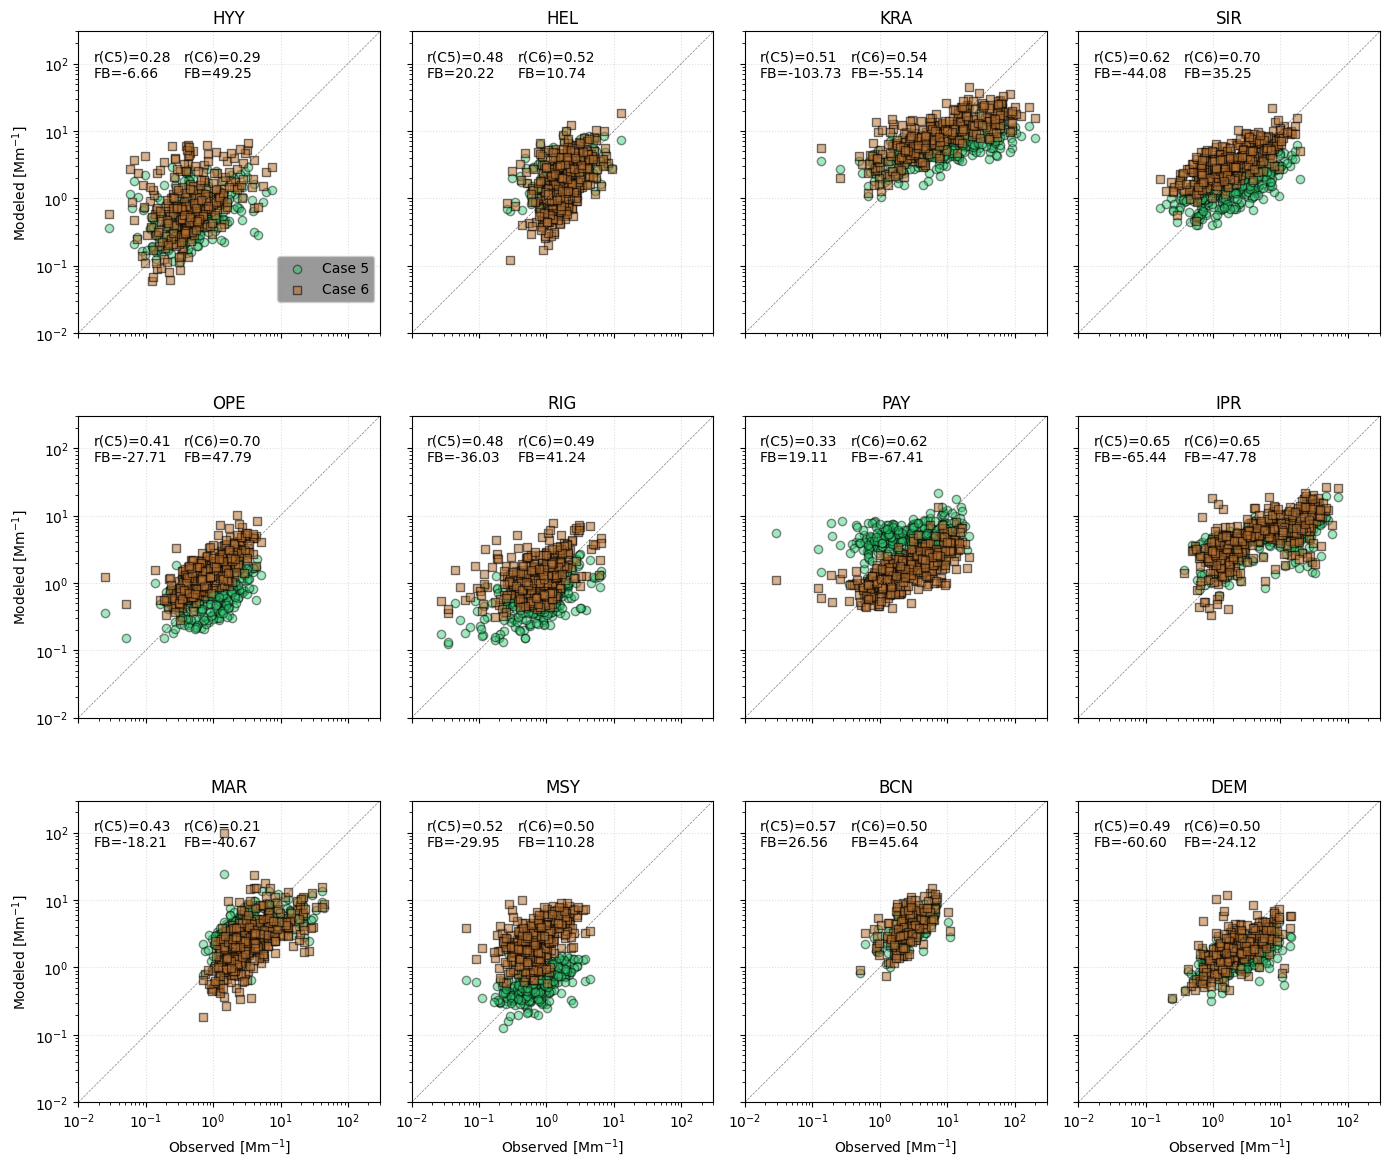

In [22]:
def plot_scatter_log_4brc(stations, points, factor=10):
    #plot in one figure
    fig, axs = plt.subplots(3, 4, figsize=(14, 14), sharex=True, sharey=True)
    #reduce space between subplots
    fig.subplots_adjust(hspace=-.45, wspace=0.12)
    #flatten the axs
    axs = axs.flatten()

    for i, stn in enumerate(stations):
        # Calcula los valores para cada caso y la observación
        abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)

        #getting ri for each case and stn
        ri_brc_strng = df_all.loc['gfas']['s'] #data_por_estacion[stn]['s']['poagfs']
        ri_brc_blchd = df_all.loc['gfas']['m'] #data_por_estacion[stn]['m']['soagfs']
        model = dr.get_explct4brcmass(dict_of_names['acr_first'][stn], remove_negatives=True)
        model_abs = ca.get_absorption4brc(model, WAVELENGTH=constants.WAVELENGTH,\
                                            REL_HUM=constants.RELATIVE_HUMIDITY,\
                                            ri_brc_strng=ri_brc_strng, ri_brc_blchd=ri_brc_blchd, SA=False)*factor

        #total
        abs_oa = ut.calculate_absorption4oa_ns(dict_of_names['acr_first'][stn], best=True, points=points,\
                                             mass_mode='best', mode='by_station', model='monarch_best_oa')

        axs[i].scatter(abs_observed, abs_oa, color='#2ECC71', label='Case 5', edgecolor='black', alpha=0.45)
        axs[i].scatter(abs_observed, model_abs, color='#B87333', label='Case 6', alpha=0.55, edgecolor='black', marker='s')

        axs[i].minorticks_on()
        axs[i].set_xlim([0.01, 300])
        axs[i].set_ylim([0.01,300])
        axs[i].plot([0.01, 300], [0.01, 300], linestyle='--', color='black', alpha=0.5, linewidth=0.5)
        #set title
        axs[i].set_title(stn)
        #set axis labels just in the bottom and left subplots
        if i in [8, 9, 10, 11]:
            axs[i].set_xlabel('Observed [Mm$^{-1}$]')
        if i in [0, 4, 8]:
            axs[i].set_ylabel('Modeled [Mm$^{-1}$]')
        #add annotation with correlation coefficient, and mean bias for each case/station using the function calculate_statistics
        #calculate statistics
        results_brc = calculate_statistics_4brc(stn, ri_brc_strng, ri_brc_blchd, factor=factor)
        results = calculate_statistics_nosoa(stn, points, mode='by_station')
        #add annotation
        axs[i].annotate(f"r(C6)={results_brc['r']:.2f}\nFB={results_brc['fb']:.2f}", 
                        xy=(0.35, 0.85), xycoords='axes fraction', fontsize=10)

        # Suponiendo que tienes los resultados para el total, añadir la anotación para tot
        axs[i].annotate(f"r(C5)={results['total']['r']:.2f}\nFB={results['total']['fb']:.2f}", 
                        xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)

        #set log scale
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')
        #set grid dotted
        axs[i].grid(True, linestyle=':', alpha=0.4)
        axs[i].set_aspect('equal', adjustable='box')
        #add legend in bottom of only first subplot
        axs[0].legend(loc='lower center', bbox_to_anchor=(0.82, 0.08), ncol=1, facecolor='gray')
    # Ajustar el layout para evitar la superposición
    plt.tight_layout()

    os.makedirs('figures_paper/scatter_opt/', exist_ok=True)
    #savefig 
    plt.savefig(f"figures_paper/scatter_opt/scatter_4brc_sm_{factor}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    

plot_scatter_log_4brc(station_names[::-1], points='complete', factor=7)

In [12]:
from scipy.optimize import minimize

#calculate the optimal factor for all stations
def calculate_factor(stn, points):
    def objective(factor):
        #getting ri for each case and stn
        ri_brc_strng = df_all.loc['gfas']['s'] #data_por_estacion[stn]['s']['poagfs']
        ri_brc_blchd = df_all.loc['gfas']['m'] #data_por_estacion[stn]['m']['soagfs']


        #calculate the FB to minimize
        results_brc = calculate_statistics_4brc(stn, ri_brc_strng, ri_brc_blchd, factor=factor)
        min_FB = results_brc['fb']
        #FB should approach 0
        return abs(min_FB)
        

    # initial guess
    x0 = 10.0
    # perform optimization
    result = minimize(objective, x0, method='nelder-mead')
    return result.x[0]

In [13]:
def calculate_factors(stations, points):
    factors = {}
    for stn in stations:
        factors[stn] = calculate_factor(stn, points)
    return factors

factors = calculate_factors(station_names[::-1], points='complete')
factors

NameError: name 'station_names' is not defined

In [79]:
# Calcular el promedio simple de los factores
factor_promedio = np.mean(list(factors.values()))
factor_promedio

7.340413411458333

In [80]:
df_all

w       m       s      c4
RI_name                                
gfas     0.0646  0.0656  0.1219     NaN
resi     0.0411  0.0410  0.0397     NaN
ship     0.0646  0.0656  0.1081     NaN
traf     0.0011  0.0011  0.0011     NaN
othr     0.0011  0.0011  0.0011     NaN
oa          NaN     NaN     NaN  0.0187

In [81]:
ri_brc_strng = df_all.loc['gfas']['m'] #data_por_estacion[stn]['m']['poagfs']
ri_brc_blchd = df_all.loc['gfas']['w'] #data_por_estacion[stn]['w']['soagfs']
model = dr.get_explct4brcmass(dict_of_names['acr_first']['BCN'], remove_negatives=True)
model_abs = ca.get_absorption4brc(model, WAVELENGTH=constants.WAVELENGTH,\
                                    REL_HUM=constants.RELATIVE_HUMIDITY,\
                                    ri_brc_strng=ri_brc_strng, ri_brc_blchd=ri_brc_blchd, SA=False)

In [82]:
abs_oa = ut.calculate_absorption4oa_ns(dict_of_names['acr_first']['BCN'], best=True, points='complete',\
                                             mass_mode='best', mode='by_station', model='monarch_best_oa')


## Abs Brc moderately, photobleached BrC weakly

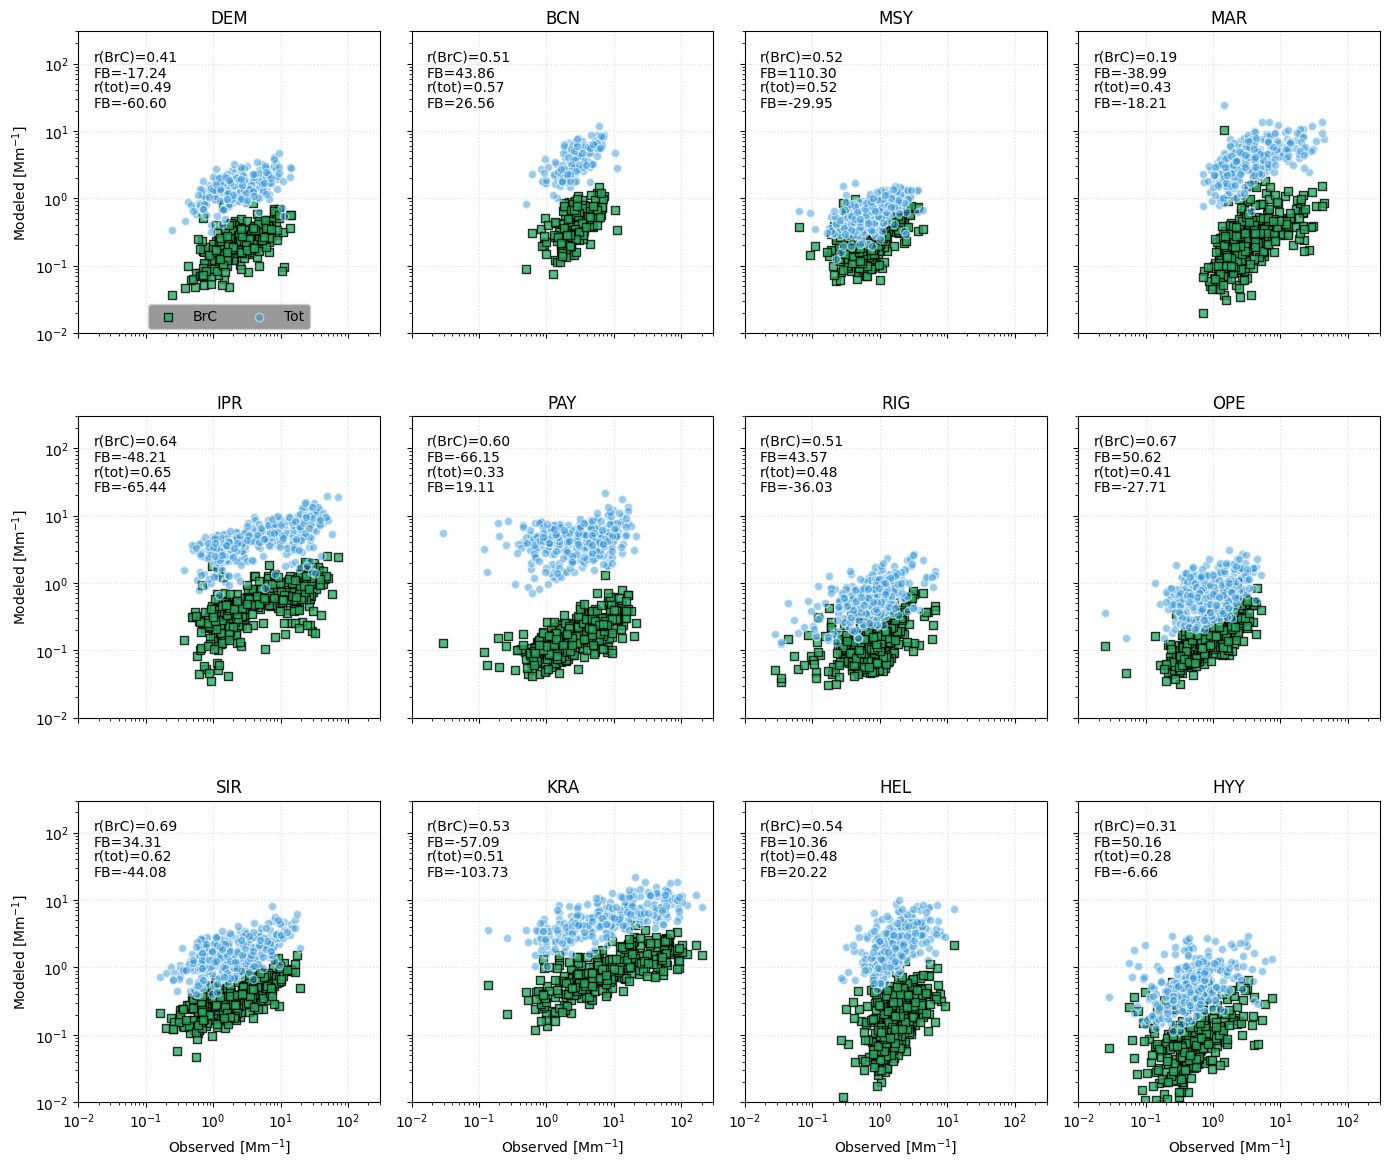

In [83]:
def plot_scatter_log_4brc_mw(stations, points='complete'):
    #plot in one figure
    fig, axs = plt.subplots(3, 4, figsize=(14, 14), sharex=True, sharey=True)
    #reduce space between subplots
    fig.subplots_adjust(hspace=-0.45, wspace=0.12)
    #flatten the axs
    axs = axs.flatten()

    for i, stn in enumerate(stations):
        # Calcula los valores para cada caso y la observación
        abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)

        #getting ri for each case and stn
        ri_brc_strng = df_all.loc['gfas']['m'] #data_por_estacion[stn]['m']['poagfs']
        ri_brc_blchd = df_all.loc['gfas']['w'] #data_por_estacion[stn]['w']['soagfs']
        model = dr.get_explct4brcmass(dict_of_names['acr_first'][stn], remove_negatives=True)
        model_abs = ca.get_absorption4brc(model, WAVELENGTH=constants.WAVELENGTH,\
                                            REL_HUM=constants.RELATIVE_HUMIDITY,\
                                            ri_brc_strng=ri_brc_strng, ri_brc_blchd=ri_brc_blchd, SA=False)


        abs_oa = ut.calculate_absorption4oa_ns(dict_of_names['acr_first'][stn], best=True, points=points,\
                                             mass_mode='best', mode='by_station', model='monarch_best_oa')

        axs[i].scatter(abs_observed, model_abs, color='#27AE60', label='BrC', alpha=0.8, edgecolor='black', marker='s')
        axs[i].scatter(abs_observed, abs_oa, color='#3498DB', label='Tot', edgecolor='white', alpha=0.5)

        axs[i].minorticks_on()
        axs[i].set_xlim([0.01, 300])
        axs[i].set_ylim([0.01,300])
        #set title
        axs[i].set_title(stn)
        #set axis labels just in the bottom and left subplots
        if i in [8, 9, 10, 11]:
            axs[i].set_xlabel('Observed [Mm$^{-1}$]')
        if i in [0, 4, 8]:
            axs[i].set_ylabel('Modeled [Mm$^{-1}$]')
        #add annotation with correlation coefficient, and mean bias for each case/station using the function calculate_statistics
        #calculate statistics
        results_brc = calculate_statistics_4brc(stn, ri_brc_strng, ri_brc_blchd)
        results = calculate_statistics_nosoa(stn, points, mode='by_station')
        #add annotation
        axs[i].annotate(f"r(BrC)={results_brc['r']:.2f}\nFB={results_brc['fb']:.2f}",
                        xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)

        # Suponiendo que tienes los resultados para el total, añadir la anotación para tot
        axs[i].annotate(f"r(tot)={results['total']['r']:.2f}\nFB={results['total']['fb']:.2f}", 
                        xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10)

        #set log scale
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')
        #set grid dotted
        axs[i].grid(True, linestyle=':', alpha=0.4)
        axs[i].set_aspect('equal', adjustable='box')
        #add legend in bottom of only first subplot
        axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 0.12), ncol=3, facecolor='gray')
    # Ajustar el layout para evitar la superposición
    plt.tight_layout()

    os.makedirs('figures_paper/scatter_opt/', exist_ok=True)
    #savefig 
    plt.savefig(f"figures_paper/scatter_opt/scatter_4brc_mw.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_scatter_log_4brc_mw(station_names)

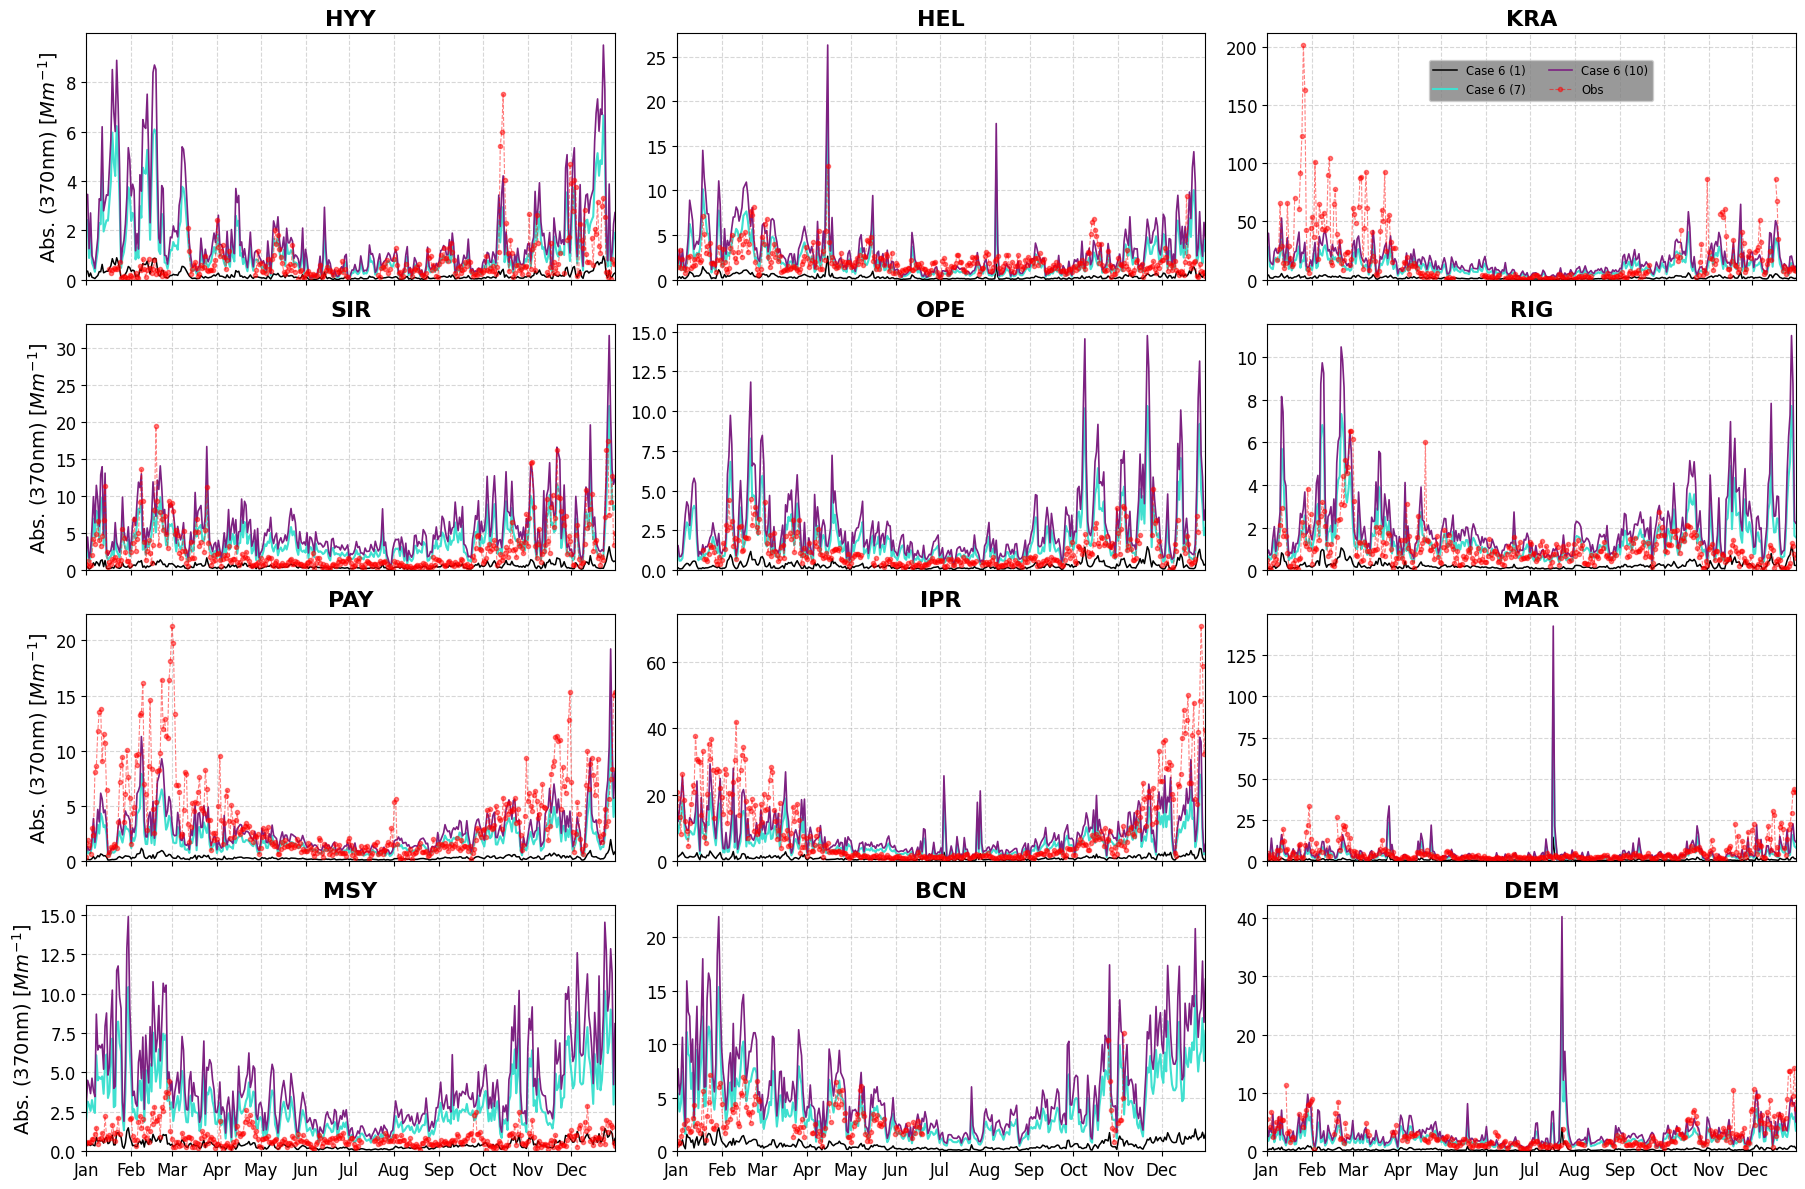

In [40]:

def plot_absorption_contributions_panel_wsoa_ts(stations, m_o_y=True, factor=False):
    fig, axs = plt.subplots(4, 3, figsize=(18, 12), sharex=True, sharey=False)
    axs = axs.flatten()  # Convertir la matriz de ejes en una lista para facilitar la iteración

    # Definir colores y etiquetas personalizadas fuera del bucle
    colores = {
        'oares': '#1f77b4',  # Azul claro
        'oagfs': '#ff7f0e',  # Naranja
        'oatrf': '#000000',  # Negro mate
        'oashp': '#9467bd',  # morado
        'oaoth': '#8c564b',   # Marrón
        'soa': '#4CAF50',
        'poares': '#1f77b4',  # Azul claro
        'poagfs': '#ff7f0e',  # Naranja
        'poatrf': '#000000',  # Negro mate
        'poashp': '#9467bd',  # morado
        'poaoth': '#8c564b',   # Marrón
    }
    
    etiquetas_personalizadas = {
        'oagfs': 'GFAS',
        'oares': 'RES',
        'oatrf': 'TRF',
        'oashp': 'SHP',
        'oaoth': 'OTH',
        'soa': 'SOA',
        'poagfs': 'GFAS',
        'poares': 'RES',
        'poatrf': 'TRF',
        'poashp': 'SHP',
        'poaoth': 'OTH',
    }
    if factor:
        factor_1 = 1
        factor_2 = 7
        factor_3 = 10
    else:
        factor_1 = 7
    for idx, stn in enumerate(stations):
        ax = axs[idx]
        # Obtener datos de observaciones y modelo
        if m_o_y:
            data_obs_i = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)
            data_mod_sa_i = get_mod_abs(stn, points='complete', case='strongly', soa=True)

            #collocation data
            data_obs_, data_mod_sa_ = st.preproc_data_collocation(data_obs_i, data_mod_sa_i, filled=True)
            #Resample to monthly mean
            data_obs = data_obs_.resample('MS').mean()
            df = data_mod_sa_.resample('MS').mean()
            #data_obs, df = data_obs.align(df, join='outer')
            #df.to_csv(f'data_mod_sa_{stn}.csv')
            #data_obs.to_csv(f'data_obs_{stn}.csv')

        else:
            data_obs = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)
            df = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                         SA=False, mode='by_station', points='complete', model='monarch_best', case='newcase')
            #df = get_mod_abs(stn, points='complete', case='newcase', soa=True).sum(axis=1)
            #convertir la serie a df
            df_case3 = df
            df_case3.columns = ['abs']
            df_case4 = ut.calculate_absorption4oa_ns(dict_of_names['acr_first'][stn], best=True, points='complete',\
                                             mass_mode='best', mode='by_station', model='monarch_best_oa')
            ri_brc_strng = df_all.loc['gfas']['s'] #data_por_estacion[stn]['s']['poagfs']
            ri_brc_blchd = df_all.loc['gfas']['m'] #data_por_estacion[stn]['m']['soagfs']
            model = dr.get_explct4brcmass(dict_of_names['acr_first'][stn], remove_negatives=True)

            
    
        #plot lines for each case
        if factor:
            df_case5 = ca.get_absorption4brc(model, WAVELENGTH=constants.WAVELENGTH,\
                                                REL_HUM=constants.RELATIVE_HUMIDITY,\
                                                ri_brc_strng=ri_brc_strng, ri_brc_blchd=ri_brc_blchd, SA=False)*factor_1
            
            df_case6 = ca.get_absorption4brc(model, WAVELENGTH=constants.WAVELENGTH,\
                                                REL_HUM=constants.RELATIVE_HUMIDITY,\
                                                ri_brc_strng=ri_brc_strng, ri_brc_blchd=ri_brc_blchd, SA=False)*factor_2

            df_case_7 = ca.get_absorption4brc(model, WAVELENGTH=constants.WAVELENGTH,\
                                                REL_HUM=constants.RELATIVE_HUMIDITY,\
                                                ri_brc_strng=ri_brc_strng, ri_brc_blchd=ri_brc_blchd, SA=False)*factor_3
            #ax.plot(df_case3, color='#2ECC71', label='Case 3', alpha=0.8, lw=1)
            #ax.plot(df_case4, color='#3498DB', label='Case 4', alpha=0.8, lw=1)
            ax.plot(df_case5, color='black', label='Case 6 (1)', alpha=1., lw=1.1)
            ax.plot(df_case6, color='turquoise', label='Case 6 (7)', alpha=1., lw=1.5)
            ax.plot(df_case_7, color='#7d2181', label='Case 6 (10)', alpha=1., lw=1.2)
        else:
            ax.plot(df_case3, color='#3498DB', label='Case 4 (by_stn)', alpha=0.8, lw=1)
            ax.plot(df_case4, color='#2ECC71', label='Case 5', alpha=0.8, lw=1)
            #ax.plot(df_case5, color='#B87333', label='Case 5 (f-7)', alpha=0.8, lw=1)
        # Añadir puntos de observación
        color_obs = 'red' #'firebrick'
        #remove negative
        data_obs = data_obs[data_obs > 0]
        ax.plot(data_obs, color=color_obs, marker='o', label='Obs', linestyle='--', ms=3 if m_o_y==False else 10, lw=0.8, alpha=0.5)

        
        # Añadir títulos y etiquetas
        ax.set_title(stn, fontsize=16, fontweight='bold')
        #ax.set_xlabel('months', fontsize=14)
        #ax.set_ylabel(r'OA ($\mu g/m^3$)', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        if idx in [0, 3, 6, 9]:
            ax.set_title(stn, fontsize=16, fontweight='bold')
            ax.set_ylabel(r'Abs. (370nm) [$Mm^{-1}$]', fontsize=14)
        # Añadir rejilla
        ax.grid(True, linestyle='--', alpha=0.5)


        if m_o_y:
            if not isinstance(df.index, pd.DatetimeIndex):
                df.index = pd.to_datetime(df.index)

            # Establecer los xticks y xticklabels
            ax.set_xticks(df.index)
            ax.set_xticklabels([cal.month_abbr[i.month][0] for i in df.index])
        else:
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            ax.set_xlim(df.index.min(), df.index.max())

    # Rotar las etiquetas para que se muestren mejor
    for label in ax.get_xticklabels():
        label.set_rotation(0)  # Rotar las etiquetas a 0 grados (horizontal)
        label.set_horizontalalignment('center')

    # Ajustar espaciado entre subgráficos
    plt.tight_layout()

    #set y inf limit
    for ax in axs:
        ax.set_ylim(0, None)

    # Crear una sola leyenda para todos los subgráficos
    #handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_obs, markersize=10))
    #labels.append('OBS')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.85, .95), fontsize='small',\
         title=None, title_fontsize='13', ncol=2, facecolor='gray')

    #bbox_to_anchor=(0.20, 0.95)
    # Crear carpeta para guardar figuras
    os.makedirs("figures_paper/ts_absorption/", exist_ok=True)
    # Guardar figura
    plt.savefig(f"figures_paper/ts_absorption/abs_ts_panel_lines{'m' if m_o_y==True else 'y'}_sm_factors_newcase_{'brc' if factor else ''}.png", dpi=300, bbox_inches='tight')
    # Mostrar el gráfico
    plt.show()


# Llama a la función con la lista de nombres de las estaciones
#stations = list(dict_of_names['stations'].values())
#invertir el orden
#stations = stations[::-1]
plot_absorption_contributions_panel_wsoa_ts(station_names[::-1], m_o_y=False, factor=True)

In [92]:
# get min and max values for each station for each case 
def get_min_max_values(stations, points, case='strongly'):
    min_max_values = {}
    #factors
    factor_1 = 1
    factor_2 = 7
    factor_3 = 10
    stn = stations
    data_obs = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)
    df = get_mod_abs(stn, points='complete', case='strongly', soa=True).sum(axis=1)
    #convertir la serie a df
    df_case3 = df.to_frame()
    df_case3.columns = ['abs']
    df_case4 = ut.calculate_absorption4oa_ns(dict_of_names['acr_first'][stn], best=True, points='complete',\
                                    mass_mode='best', mode='by_station', model='monarch_best_oa')
    ri_brc_strng = df_all.loc['gfas']['s'] #data_por_estacion[stn]['s']['poagfs']
    ri_brc_blchd = df_all.loc['gfas']['m'] #data_por_estacion[stn]['m']['soagfs']
    model = dr.get_explct4brcmass(dict_of_names['acr_first'][stn], remove_negatives=True)
    df_case5 = ca.get_absorption4brc(model, WAVELENGTH=constants.WAVELENGTH,\
                                        REL_HUM=constants.RELATIVE_HUMIDITY,\
                                        ri_brc_strng=ri_brc_strng, ri_brc_blchd=ri_brc_blchd, SA=False)*factor_1
    
    df_case6 = ca.get_absorption4brc(model, WAVELENGTH=constants.WAVELENGTH,\
                                        REL_HUM=constants.RELATIVE_HUMIDITY,\
                                        ri_brc_strng=ri_brc_strng, ri_brc_blchd=ri_brc_blchd, SA=False)*factor_2

    df_case_7 = ca.get_absorption4brc(model, WAVELENGTH=constants.WAVELENGTH,\
                                        REL_HUM=constants.RELATIVE_HUMIDITY,\
                                        ri_brc_strng=ri_brc_strng, ri_brc_blchd=ri_brc_blchd, SA=False)*factor_3

    #get min and max values for each case ro winter and summer
    min_max_values[stn] = {
        'case3': {'min': df_case3['abs'].min(), 'max': df_case3['abs'].max()},
        'case4': {'min': df_case4.min(), 'max': df_case4.max()},
        'case5': {'min': df_case5.min(), 'max': df_case5.max()},
        'case6': {'min': df_case6.min(), 'max': df_case6.max()},
        'case7': {'min': df_case_7.min(), 'max': df_case_7.max()},
        'obs': {'min': data_obs.min(), 'max': data_obs.max()}
    }
    #get min and max values for each case ro winter and summer
    

    return min_max_values

In [101]:
#PAY: MAX 25
#Regional stations
reg_stns = ['HYY', 'OPE', 'RIG', 'PAY', 'IPR', 'MSY']
sub_stns = ['SIR', 'KRA', 'DEM']
urb_stns = ['BCN', 'MAR', 'HEL']

In [98]:
#GET max observed in reg_stns
max_values = {}
for stn in reg_stns:
    max_values[stn] = get_min_max_values(stn, points='complete', case='strongly')

max_values

{'HYY': {'HYY': {'case3': {'min': 0.08536329342012375,
    'max': 4.238928051896165},
   'case4': {'min': AbsBrC370    0.114428
    dtype: float64,
    'max': AbsBrC370    2.95232
    dtype: float64},
   'case5': {'min': AbsBrC370    0.005164
    dtype: float64,
    'max': AbsBrC370    0.951107
    dtype: float64},
   'case6': {'min': AbsBrC370    0.036147
    dtype: float64,
    'max': AbsBrC370    6.657749
    dtype: float64},
   'case7': {'min': AbsBrC370    0.051638
    dtype: float64,
    'max': AbsBrC370    9.511071
    dtype: float64},
   'obs': {'min': AbsBrC370    0.008346
    dtype: float64,
    'max': AbsBrC370    7.509817
    dtype: float64}}},
 'OPE': {'OPE': {'case3': {'min': 0.19380623876593028,
    'max': 7.461827706603439},
   'case4': {'min': AbsBrC370    0.151091
    dtype: float64,
    'max': AbsBrC370    3.458437
    dtype: float64},
   'case5': {'min': AbsBrC370    0.040126
    dtype: float64,
    'max': AbsBrC370    1.474665
    dtype: float64},
   'case6': {'min

In [104]:
# get the mean value in each of reg_stns
mean_values = {}
for stn in urb_stns:
    data_obs = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)
    mean_values[stn] = data_obs.mean().values[0]

mean_values

{'BCN': 3.049290382295375, 'MAR': 5.170242377186142, 'HEL': 2.0603549606088607}

In [106]:
# get the max value in each of reg_stns
max_values = {}
for stn in sub_stns:
    data_obs = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)
    max_values[stn] = data_obs.max().values[0]

max_values

{'SIR': 19.437718703486848,
 'KRA': 201.49355257126408,
 'DEM': 14.204083671415404}

## TAYLOR DIAGRAMS 4 ABS

In [ ]:
def get_r_stdn_multiple(stations, points):
    # Crear un diccionario para almacenar los resultados
    results = {}
    for stn in stations:
        # Calcula los valores para cada caso y la observación
        abs_mod_weakly = ut.calculate_absorption_cases(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                       SA=False, mode='by_station', points=points, model='monarch_best', case='weakly')
        abs_mod_moderately = ut.calculate_absorption_cases(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                           SA=False, mode='by_station', points=points, model='monarch_best', case='moderately')
        abs_mod_strongly = ut.calculate_absorption_cases(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                         SA=False, mode='by_station', points=points, model='monarch_best', case='strongly')
        abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)

        # Calcular las métricas
        corr_weakly = st.calculate_corr(abs_observed, abs_mod_weakly)
        corr_moderately = st.calculate_corr(abs_observed, abs_mod_moderately)
        corr_strongly = st.calculate_corr(abs_observed, abs_mod_strongly)

        #calculate std
        std_weakly = abs_mod_weakly.std()
        std_moderately = abs_mod_moderately.std()
        std_strongly = abs_mod_strongly.std()
        std_obs = abs_observed.std()

        #calcular std normalizada
        stdn_weakly = std_weakly/std_obs
        stdn_moderately = std_moderately/std_obs
        stdn_strongly = std_strongly/std_obs

        #almacenar resultados
        results[stn] = {
            'r_weakly': corr_weakly,
            'r_moderately': corr_moderately,
            'r_strongly': corr_strongly,
            'stdn_weakly': stdn_weakly.values[0],
            'stdn_moderately': stdn_moderately.values[0],
            'stdn_strongly': stdn_strongly.values[0],
        }
    #devolver una lista por cada caso
    return results    

In [ ]:
r_weakly = [get_r_stdn_multiple(station_names, points='best')[stn]['r_weakly'] for stn in station_names]
r_moderately = [get_r_stdn_multiple(station_names, points='best')[stn]['r_moderately'] for stn in station_names]
r_strongly = [get_r_stdn_multiple(station_names, points='best')[stn]['r_strongly'] for stn in station_names]

stdn_weakly = [get_r_stdn_multiple(station_names, points='best')[stn]['stdn_weakly'] for stn in station_names]
stdn_moderately = [get_r_stdn_multiple(station_names, points='best')[stn]['stdn_moderately'] for stn in station_names]
stdn_strongly = [get_r_stdn_multiple(station_names, points='best')[stn]['stdn_strongly'] for stn in station_names]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x800 with 0 Axes>

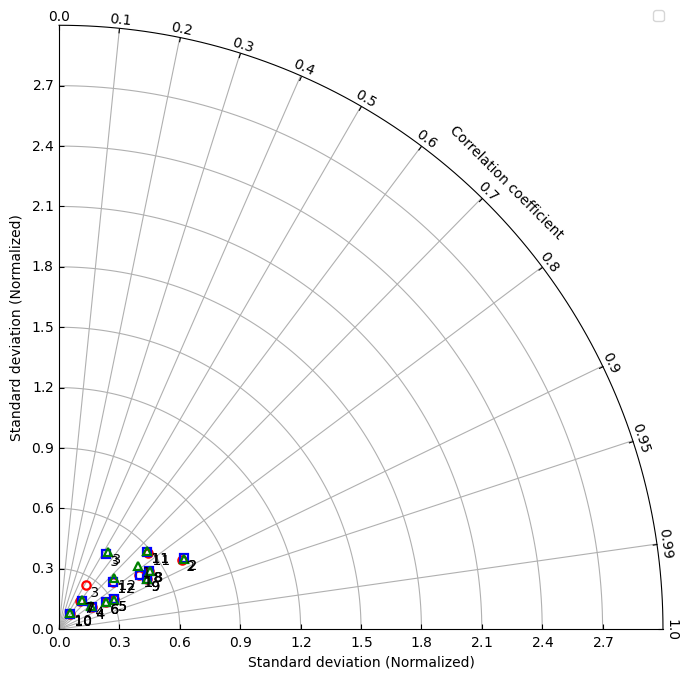

In [ ]:
def srl(obsSTD, r1, r2, r3, s1, s2, s3, l, fname):
    """
    Crea un diagrama de Taylor utilizando el paquete srl
    """
    fig = plt.figure(figsize=(8, 8))
    dia = TaylorDiagram(obsSTD, fig=fig, rect=111, label=None)
    identifier1 = 1  # Inicializa un identificador numérico para las muestras
    identifier2 = 1  # Inicializa un identificador numérico para las muestras
    identifier3 = 1  # Inicializa un identificador numérico para las muestras
    
    for std, corr, label in zip(s1, r1, l):
        # Añade la muestra sin pasar la etiqueta a add_sample
        dia.add_sample(std, corr, identifier=identifier1, marker='o', mec='red', mfc='none', mew=1.6)
        # Guarda la etiqueta con su identificador en el diccionario de labels
        dia.labels[identifier1] = label
        identifier1 += 1

    for std, corr, label in zip(s2, r2, l):
        dia.add_sample(std, corr, identifier=identifier2, marker='s', mec='blue', mfc='none', mew=1.6)
        dia.labels[identifier2] = label
        identifier2 += 1

    for std, corr, label in zip(s3, r3, l):
        dia.add_sample(std, corr, identifier=identifier3, marker='^', mec='green', mfc='none', mew=1.6)
        dia.labels[identifier3] = label
        identifier3 += 1


    # Añadir leyenda
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    #savefig
    plt.savefig(fname, dpi=300, bbox_inches='tight')

    # Mostrar la figura
    plt.show()
# Llamar a la función srl con los datos necesarios
fig = plt.figure(figsize=(8, 8))
srl(obsSTD=10, r1=r_weakly, r2=r_moderately, r3=r_strongly, s1=stdn_weakly, s2=stdn_moderately, s3=stdn_strongly, l=station_names, fname='figures_paper/taylor_diagram_abs_best.png')


In [ ]:
r

[0.4, 0.33, 0.21, 0.68, 0.68, 0.77, 0.7, 0.56, 0.78, 0.57, 0.56, 0.54]

In [ ]:
class TaylorDiagram(object):
  def __init__(self, STD ,fig=None, rect=111, label='_', sampleSTDs=None):
    self.STD = STD
    tr = PolarAxes.PolarTransform()
    self.labels = {} 
    # Correlation labels
    rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
    tlocs = np.arccos(rlocs) # Conversion to polar angles
    gl1 = gf.FixedLocator(tlocs) # Positions
    tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
    # Standard deviation axis extent
    self.smin = 0
    self.smax = .3 * self.STD
    gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
    if fig is None:
      fig = plt.figure()
    ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
    fig.add_subplot(ax)
    # Angle axis
    ax.axis['top'].set_axis_direction('bottom')
    ax.axis['top'].label.set_text("Correlation coefficient")
    ax.axis['top'].toggle(ticklabels=True, label=True)
    ax.axis['top'].major_ticklabels.set_axis_direction('top')
    ax.axis['top'].label.set_axis_direction('top')
    # X axis
    ax.axis['left'].set_axis_direction('bottom')
    ax.axis['left'].label.set_text("Standard deviation (Normalized)")
    ax.axis['left'].toggle(ticklabels=True, label=True)
    ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
    ax.axis['left'].label.set_axis_direction('bottom')
    # Y axis
    ax.axis['right'].set_axis_direction('top')
    ax.axis['right'].label.set_text("Standard deviation (Normalized)")
    ax.axis['right'].toggle(ticklabels=True, label=True)
    ax.axis['right'].major_ticklabels.set_axis_direction('left')
    ax.axis['right'].label.set_axis_direction('top')
    # Useless
    ax.axis['bottom'].set_visible(False)
    # Contours along standard deviations
    ax.grid()
    self._ax = ax # Graphical axes
    self.ax = ax.get_aux_axes(tr) # Polar coordinates
    # Add reference point and STD contour
    l , = self.ax.plot([0], self.STD, 'k*', ls='', ms=12, label=label)
    t = np.linspace(0, (np.pi / 2.0))
    r = np.zeros_like(t) + self.STD
    #self.ax.plot(t, r, 'k--', label='_')
    # Collect sample points for latter use (e.g. legend)
    self.samplePoints = [l]
    '''def add_sample(self,STD,r,*args,label=None,**kwargs):
      l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
      self.samplePoints.append(l)
      #añadir la etiqueta al punto
      if label is not None:
          # Calcula una posición ajustada para el texto si es necesario
          x_text = np.arccos(r)
          y_text = STD
          self.ax.text(x_text, y_text, ' ' + label, ha='left', va='top')
      return l'''

  def add_sample(self, STD, r, identifier, *args, **kwargs):
      l, = self.ax.plot(np.arccos(r), STD, *args, **kwargs)
      self.ax.text(np.arccos(r), STD, f' {identifier}', ha='left', va='top')
      if 'label' in kwargs:  # Aquí asumimos que 'label' se pasa como un kwarg
          self.labels[identifier] = kwargs['label']  # Asignación de la etiqueta al identificador
      return l


  def add_contours(self, levels=5, **kwargs):
    rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
    RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
    contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
    return contours

'''def srl(obsSTD, s, r, l, fname):
  fig=plt.figure(figsize=(8,8))
  dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='ref')
  #plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)
  srlc = zip(s, r, l)
   
  #for i in srlc:
  #  dia.add_sample(i[0], i[1], label=i[2], marker='o',mec = 'red', mfc = 'none', mew=1.6)
  for std, corr, label in srlc:
    dia.add_sample(std, corr, label=label, marker='o', mec='red', mfc='none', mew=1.6)


  spl = [p.get_label() for p in dia.samplePoints]
  #fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='small'), loc=[0.7,0.3])
  plt.show()'''
def srl(obsSTD, s, r, l, fname):
    fig = plt.figure(figsize=(8, 8))
    dia = TaylorDiagram(obsSTD, fig=fig, rect=111, label='Ref')
    identifier = 1  # Inicializa un identificador numérico para las muestras
    
    for std, corr, label in zip(s, r, l):
        # Añade la muestra sin pasar la etiqueta a add_sample
        dia.add_sample(std, corr, identifier=identifier, marker='o', mec='red', mfc='none', mew=1.6)
        # Guarda la etiqueta con su identificador en el diccionario de labels
        dia.labels[identifier] = label
        identifier += 1

    # Calcular la separación vertical entre las etiquetas
    vertical_spacing = 0.008 * dia.STD

    # Ajustar las coordenadas x e y de las etiquetas
    x_offset = 0.1  # Desplazamiento horizontal
    y_offset = 1.9  # Desplazamiento vertical
    
    # Recorrer el diccionario de etiquetas comenzando desde el ID 1
    for id in range(1, len(dia.labels) + 1):
        label = dia.labels[id]
        x = x_offset  # Ajustar el desplazamiento horizontal
        y = -(id * vertical_spacing) + y_offset  # Ajustar el desplazamiento vertical hacia arriba
        plt.text(x, y, f'{id}: {label}', fontsize=10, ha='center', va='top', color='blue')
    #save on figures_paper
    os.makedirs('figures_paper/taylor_diagram_mass', exist_ok=True)
    plt.savefig(f'figures_paper/taylor_diagram_mass/{fname}', dpi=300, bbox_inches='tight')

    plt.show()


'''

std_obs = [taylor_stats[site]['std_obs'] for site in taylor_stats]
obsSTD = refstd_global.values[0] #min(std_obs)

s = [taylor_stats[site]['std_mod']/taylor_stats[site]['std_obs'] for site in taylor_stats]
r = [taylor_stats[site]['corr'] for site in taylor_stats]

l = [site for site in taylor_stats]


fname = 'TaylorDiagram_mass.png'
srl(obsSTD, s, r, l, fname)'''

"\n\nstd_obs = [taylor_stats[site]['std_obs'] for site in taylor_stats]\nobsSTD = refstd_global.values[0] #min(std_obs)\n\ns = [taylor_stats[site]['std_mod']/taylor_stats[site]['std_obs'] for site in taylor_stats]\nr = [taylor_stats[site]['corr'] for site in taylor_stats]\n\nl = [site for site in taylor_stats]\n\n\nfname = 'TaylorDiagram_mass.png'\nsrl(obsSTD, s, r, l, fname)"